# TO-DO:

## Feature engineering:
### Race/Championship winners
1. race win count per driver plot
2. team wins per era
3. percentage of positions gained 
  a. 


Regression analysis:
1. Driver stats vs results (position)
2. Driver/team results vs circuit stats
3. 



### Qualification results

1. set times to milliseconds (This is hard. df.to_datetime converts to date included. But we only want the Time component.)
2. descriptive analysis on these results --> 3 descriptives each
2. found out how to rank --> predict every qualification round
3. features:
  1. Driver:
    1. driver age --> Done
    2. driver name
    3. driver years in formula 1 --> Ben
    4. qualification position for this circuit last season
    4. qualification time for this circuit last season
    5. Percentage difference in qualifying time from pole position * 100
    6. ending position last year
    7. DNF percentage
    8. starting position last year. 
  2. Circuit:
    1. turns 
    2. length 
    3. altitude
  3. Constructor:
    1. Name
    2. championship won 
    3. races won 
    4. average qualification position last time
  4. Other: 
    1. qualifying round


## Machine learning

* Build model that predicts positions 1-20 (ANN?)
*
*
*


## To do in Latex:
- plots and descriptive analysis after introduction to show the hhistory of the formula one
- plots after feature engineering with the experiment evaluation
- correlation matrix in the experiment evaluation. 
- explanation of the research question --> qualification results are known plus answers of subquestions.
- elaboration of the problem definition

# Data explanation
## Race Results
The value of the position attribute in the Result element is always an integer, giving the finishing order of all drivers. The value of the positionText attribute is either an integer (finishing position), “R” (retired), “D” (disqualified), “E” (excluded), “W” (withdrawn), “F” (failed to qualify) or “N” (not classified). Further information is given by the status element. A grid position value of ‘0’ indicates the driver started from the pit lane.

In [0]:
!pip install --upgrade -q gspread
!pip install -U -q PyDrive

In [0]:
import numpy as np #numpy
import pandas as pd #pandas
import re as re #regex

import math
import time
import datetime
from datetime import timedelta

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') #use style

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Using Spreadsheets from Google
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Data import

In [4]:
USENEWDATA = True
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

file_list = drive.ListFile({'q': "'1R_mO-WkW0yubFayXpU7dKFOP-Y8b5Trm' in parents and trashed=false"}).GetList()
for item in range(0,len(file_list)):
  print("Item {} is {} with id: {}".format(item,file_list[item].get('title'),file_list[item].get('id')))
print(USENEWDATA)

Item 0 is status.csv with id: 1hP3dIVOLbQODXqGNk1KJMVcq8_emKGF0
Item 1 is qualifying.csv with id: 1rfOJW_Xm52-7FdRByMo8qjn-peDyzso5
Item 2 is races.csv with id: 1veE0hw1SjIrcCELO7n5p-bjkAPzBmjtY
Item 3 is driver_standings.csv with id: 1-Nc_9J-nPzrLU1WMbfnZq1Bs4RPsV8yc
Item 4 is driver.csv with id: 1BNNGxhQE8jyC-1-NmJ63iO5uI9UgDi6x
Item 5 is seasons.csv with id: 1CNDq774Z6ob86IArk9YM5IBGPom7KzPE
Item 6 is pit_stops.csv with id: 1Oa0ylyHKbBWfG7Z44Yu0BturyeystMMF
Item 7 is constructor_standings.csv with id: 1u_O0h2K7_OWi_o9J0mmR0WH8fXDYXxUa
Item 8 is results.csv with id: 1YYeqyF-D3rDiHlwG3wqabvu0SKlm6dEV
Item 9 is lap_times.csv with id: 1moGNkEU9mPaoN5UqwYmmz2XE_lZYgOwy
Item 10 is constructor_results.csv with id: 1YbquZhagomMKUrt0foGsfvBSKlaRbxmd
Item 11 is constructors.csv with id: 1-zcKIFF7c_vwXWn4ZB-SAEmTwCGfWwOT
Item 12 is circuits.csv with id: 13Q3cW6k8DP7o6fFcr3pad5AlhSDt8aCQ
True


In [29]:
try:
  del races
except:
  print('no races')
# Open our new sheet and read some data.
worksheet = gc.open('races.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
races = pd.DataFrame.from_records(rows[1:], columns=rows[0])
# below we add new data to the old data
newraces = pd.read_csv(StringIO(drive.CreateFile({'id': file_list[2].get('id')}).GetContentString()), sep=",", header=None)
newraces.columns = rows[0]
newraces = newraces[~newraces.isin(races)].dropna()
# newraces = newraces.loc[newraces['year'] >= 2018]
if(USENEWDATA):                                  
  races = pd.concat([races,newraces]).drop_duplicates()
print("New data used: ",USENEWDATA)
races[['raceId','year','round','circuitId']] = races[['raceId','year','round','circuitId']].apply(pd.to_numeric)
# races = races.set_index('raceId')
print(list(races))
races['datetime'] = races[['date', 'time']].apply(lambda x: ''.join(" " + x), axis=1)
races['datetime'] = races['datetime'].apply(pd.to_datetime)

races.sort_values('year', ascending=False).head(50) #showing that it works.
# print("")

New data used:  True
['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url']


raceId  year  round  circuitId                      name        date  \
996    1009  2018     21         24      Abu Dhabi Grand Prix  2018-11-25   
986     999  2018     11         10         German Grand Prix  2018-07-22   
976     989  2018      1          1     Australian Grand Prix  2018-03-25   
977     990  2018      2          3        Bahrain Grand Prix  2018-04-08   
978     991  2018      3         17        Chinese Grand Prix  2018-05-15   
979     992  2018      4         73     Azerbaijan Grand Prix  2018-04-29   
980     993  2018      5          4        Spanish Grand Prix  2018-05-13   
981     994  2018      6          6         Monaco Grand Prix  2018-05-27   
983     996  2018      8         34         French Grand Prix  2018-06-24   
984     997  2018      9         70       Austrian Grand Prix  2018-07-01   
985     998  2018     10          9        British Grand Prix  2018-07-08   
982     995  2018      7          7       Canadian Grand Prix  2018-06-10   
987    1000  2018     12         11      Hungarian Grand Prix  2018-07-29   
992    1005  2018     17         22       Japanese Grand Prix  2018-10-07   
988    1001  2018     13         13        Belgian Grand Prix  2018-08-26   
994    1007  2018     19         32        Mexican Grand Prix  2018-10-28   
993    1006  2018     18         69  United States Grand Prix  2018-10-21   
995    1008  2018     20         18      Brazilian Grand Prix  2018-11-11   
991    1004  2018     16         71        Russian Grand Prix  2018-09-30   
990    1003  2018     15         15      Singapore Grand Prix  2018-09-16   
989    1002  2018     14         14        Italian Grand Prix  2018-09-02   
965     978  2017     10          9        British Grand Prix  2017-07-16   
956     969  2017      1          1     Australian Grand Prix  2017-03-26   
957     970  2017      2         17        Chinese Grand Prix  2017-04-09   
958     971  2017      3          3        Bahrain Grand Prix  2017-04-16   
959     972  2017      4         71        Russian Grand Prix  2017-04-30   
960     973  2017      5          4        Spanish Grand Prix  2017-05-14   
961     974  2017      6          6         Monaco Grand Prix  2017-05-28   
962     975  2017      7          7       Canadian Grand Prix  2017-06-11   
963     976  2017      8         73     Azerbaijan Grand Prix  2017-06-25   
964     977  2017      9         70       Austrian Grand Prix  2017-07-09   
971     984  2017     16         22       Japanese Grand Prix  2017-10-08   
966     979  2017     11         11      Hungarian Grand Prix  2017-07-30   
968     981  2017     13         14        Italian Grand Prix  2017-09-03   
969     982  2017     14         15      Singapore Grand Prix  2017-09-17   
970     983  2017     15          2      Malaysian Grand Prix  2017-10-01   
972     985  2017     17         69  United States Grand Prix  2017-10-22   
973     986  2017     18         32        Mexican Grand Prix  2017-10-29   
974     987  2017     19         18      Brazilian Grand Prix  2017-11-12   
975     988  2017     20         24      Abu Dhabi Grand Prix  2017-11-26   
967     980  2017     12         13        Belgian Grand Prix  2017-08-27   
939     952  2016      5          4        Spanish Grand Prix  2016-05-15   
943     956  2016      9         70       Austrian Grand Prix  2016-07-03   
942     955  2016      8         73       European Grand Prix  2016-06-19   
941     954  2016      7          7       Canadian Grand Prix  2016-06-12   
940     953  2016      6          6         Monaco Grand Prix  2016-05-29   
935     948  2016      1          1     Australian Grand Prix  2016-03-20   
938     951  2016      4         71        Russian Grand Prix  2016-05-01   
937     950  2016      3         17        Chinese Grand Prix  2016-04-17   
936     949  2016      2          3        Bahrain Grand Prix  2016-04-03   

         time                                                url  \
996  13:0

In [6]:
hour_0 = datetime.time(0,0)
hour_6 = datetime.time(6,0)
hour_12 = datetime.time(12,0)
hour_18 = datetime.time(18,0)


def convert_time_race(time):
  time = time.time()
  if time >= hour_0 and time < hour_6:
    return 'night'
  elif time >= hour_6 and time < hour_12:
    return 'morning'
  elif time >= hour_12 and time < hour_18:
    return 'afternoon'
  elif time >= hour_18:
    return 'evening'


races['time'] = races.apply(lambda row: convert_time_race(row['datetime']), axis=1)

races.head()

raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

        time                                                url  \
0    morning  http://en.wikipedia.org/wiki/2009_Australian_G...   
1    morning  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...   
2    morning  http://en.wikipedia.org/wiki/2009_Chinese_Gran...   
3  afternoon  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...   
4  afternoon  http://en.wikipedia.org/wiki/2009_Spanish_Gran...   

             datetime  
0 2009-03-29 06:00:00  
1 2009-04-05 09:00:00  
2 2009-04-19 07:00:00  
3 2009-04-26 12:00:00  
4 2009-05-10 12:00:00

In [0]:
# 1947–1953
# 1954–1960
# 1961–1965
# 1966–1986
# 1987–1988
# 1989–1994
# 1995–2005
# 2006–2013
# 2014–present

def getEra(x):
  eras = [1947,1953,1954,1960,1961,1965,1966,1986,1987,1988,1989,1994,1995,2005,2006,2013,2014,2020]
  newEra = 0
  if x >= eras[0] and x <= eras[1]:
    newEra = 1 # 1947–1953
  elif x >= eras[2] and x <= eras[3]:
    newEra = 2 # 1954–1960
  elif x >= eras[4] and x <= eras[5]:
    newEra = 3 # 1961–1965
  elif x >= eras[6] and x <= eras[7]:
    newEra = 4 # 1966–1986
  elif x >= eras[8] and x <= eras[9]:
    newEra = 5 # 1987–1988
  elif x >= eras[10] and x <= eras[11]:
    newEra = 6 # 1989–1994
  elif x >= eras[12] and x <= eras[13]:
    newEra = 7 # 1995–2005
  elif x >= eras[14] and x <= eras[15]:
    newEra = 8 # 2006–2013
  elif x >= eras[16] and x <= eras[17]:
    newEra = 9 # 2014–present
  return newEra
    
races['era'] = races.apply(lambda row: getEra(row['year']), axis=1)
#races.sort_values('year', ascending=False).head(20)

Circuit Data

In [8]:
# CircuitData
# Open our new sheet and read some data.
worksheet = gc.open('circuitData').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
circuitData = pd.DataFrame.from_records(rows[1:], columns=rows[0])
circuitData[['circuitId','circuitLength','circuitTurns','circuitLengthKM','guessedLaps']] = circuitData[['circuitId','circuitLength','circuitTurns','circuitLengthKM','guessedLaps']].apply(pd.to_numeric)
# circuitData = circuitData.set_index('circuitId')

circuitData['circuitDirection'] = circuitData['circuitDirection'].map(lambda x: 1 if 'Clockwise' else 0 )

circuitData.head() #showing that it works.
# circuitData.describe()
#print("")

circuitId                           name circuitType  circuitLength  \
0         65                Pescara Circuit        Road          25800   
1         63  Sebring International Raceway        Road           8660   
2         61                           AVUS      Street           8300   
3         51                Charade Circuit        Road           8055   
4         55                    Reims-Gueux        Road           7900   

   circuitTurns  circuitDirection  circuitLengthKM  guessedLaps  \
0            35                 1           25.800           12   
1            17                 1            8.660           36   
2             4                 1            8.300           37   
3            48                 1            8.055           38   
4             7                 1            7.900           39   

                                                 url  
0  http://search.espn.co.uk/f1/motorsport/circuit...  
1  http://search.espn.co.uk/f1/motorsport/circuit...  
2  http://search.espn.co.uk/f1/motorsport/circuit...  
3  http://search.espn.co.uk/f1/motorsport/circuit...  
4  http://search.espn.co.uk/f1/motorsport/circuit...

Circuits

In [31]:
# Circuits
# Open our new sheet and read some data.
worksheet = gc.open('circuits').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
circuits = pd.DataFrame.from_records(rows[1:], columns=rows[0])
circuits[['circuitId']] = circuits[['circuitId']].apply(pd.to_numeric)
# circuits = circuits.set_index('circuitId')
print(list(circuits))
circuits = circuits.merge(circuitData[['circuitId', 'circuitType', 'circuitLength', 'circuitTurns', 'circuitDirection']], on='circuitId')

def toCats(circuitType):
  if circuitType == 'Street':
    return 1
  elif circuitType == 'Race':
    return 2
  elif circuitType == 'Road':
    return 3
  else:
    return 0

circuits['circuitType'] = circuits.apply(lambda row: toCats(row['circuitType']), axis=1)

circuits.head()
# print("")

['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt', 'url']


circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya     MontmelÌ_   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat      lng alt  \
0  Australia  -37.8497  144.968  10   
1   Malaysia   2.76083  101.738       
2    Bahrain   26.0325  50.5106       
3      Spain     41.57  2.26111       
4     Turkey   40.9517   29.405       

                                                 url  circuitType  \
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...            1   
1  http://en.wikipedia.org/wiki/Sepang_Internatio...            2   
2  http://en.wikipedia.org/wiki/Bahrain_Internati...            2   
3  http://en.wikipedia.org/wiki/Circuit_de_Barcel...            2   
4         http://en.wikipedia.org/wiki/Istanbul_Park            2   

   circuitLength  circuitTurns  circuitDirection  
0           5303            16                 1  
1           5543            15                 1  
2           6299            23                 1  
3           4655            15                 1  
4           5338            14                 1

Driver Standings

In [10]:
# Open our new sheet and read some data.
worksheet = gc.open('driverStandings.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
driverStandings = pd.DataFrame.from_records(rows[1:], columns=rows[0])
driverStandings[['driverStandingsId','raceId','driverId','points','position','wins']] = driverStandings[['driverStandingsId','raceId','driverId','points','position','wins']].apply(pd.to_numeric)
# driverStandings = driverStandings.set_index('driverStandingsId')

driverStandings.head() #showing that it works.
#print("")

driverStandingsId  raceId  driverId  points  position positionText  wins
0                  1      18         1    10.0         1            1     1
1                  2      18         2     8.0         2            2     0
2                  3      18         3     6.0         3            3     0
3                  4      18         4     5.0         4            4     0
4                  5      18         5     4.0         5            5     0

Constructor Results

In [11]:
# constructorResults.csv
# Open our new sheet and read some data.
worksheet = gc.open('constructorResults.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
constructorResults = pd.DataFrame.from_records(rows[1:], columns=rows[0])
# constructorResults[['constructorResultsId','raceId','constructorId', 'points']] = constructorResults[['constructorResultsId','raceId','constructorId', 'points']].apply(pd.to_numeric)
# constructorResults = constructorResults.set_index('raceId','constructorResultsId')

#This is not merging?
# constructorResults = pd.merge(constructorResults, driverStandings[['raceId','era']], on = ['raceId'])
# constructorResults = constructorResults.loc[constructorResults['era'] >= 8]

# constructorResults.info()
constructorResults.head() #showing that it works.
# print("")

constructorResultsId raceId constructorId points status
0                    1     18             1     14   NULL
1                    2     18             2      8   NULL
2                    3     18             3      9   NULL
3                    4     18             4      5   NULL
4                    5     18             5      2   NULL

Drivers

In [33]:
try:
  del drivers
except:
  print('no drivers')
# Open our new sheet and read some data.
worksheet = gc.open('drivers.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
drivers = pd.DataFrame.from_records(rows[1:], columns=rows[0])
# below we add new data to the old data
newdriver = pd.read_csv(StringIO(drive.CreateFile({'id': file_list[4].get('id')}).GetContentString()), sep=",", header=None)
newdriver.columns = rows[0]
newdriver = newdriver[~newdriver.isin(drivers)].dropna()
if(USENEWDATA):                                  
  drivers = pd.concat([drivers,newdriver]).drop_duplicates()
print("New data used: ",USENEWDATA)
drivers[['driverId']] = drivers[['driverId']].apply(pd.to_numeric)
# drivers = drivers.set_index('driverId')
print(list(drivers))
#Waarom doen we dit?
#drivers = pd.merge(drivers, driverStandings[['driverId','era']], on = 'driverId')
#drivers = drivers.loc[drivers['era'] >= 8]
#drivers = drivers.drop(['era'], axis=1) # use this if we only want a driver info and no era then remove dupes
#drivers = drivers.drop_duplicates(subset=None, keep='first', inplace=False)

drivers.tail(10) #showing that it works.
#print("")

#drivers[drivers['driverRef'] == 'schumacher']

New data used:  True
['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']


driverId        driverRef number code forename     surname         dob  \
834       835    jolyon_palmer     30  PAL   Jolyon      Palmer  20/01/1991   
835       836         wehrlein     94  WEH   Pascal    Wehrlein  18/10/1994   
836       837         haryanto     88  HAR      Rio    Haryanto  22/01/1993   
837       838        vandoorne      2  VAN  Stoffel   Vandoorne  26/03/1992   
838       839             ocon     31  OCO  Esteban        Ocon  17/09/1996   
839       840           stroll     18  STR    Lance      Stroll  29/10/1998   
840       841       giovinazzi     36  GIO  Antonio  Giovinazzi  14/12/1993   
841       843  brendon_hartley     39  HAR  Brendon     Hartley  10/11/1989   
842       844          leclerc     16  LEC  Charles     Leclerc  1997-10-16   
843       845         sirotkin     35  SIR   Sergey    Sirotkin  1995-08-27   

       nationality                                                url  
834        British         http://en.wikipedia.org/wiki/Jolyon_Palmer  
835         German       http://en.wikipedia.org/wiki/Pascal_Wehrlein  
836     Indonesian          http://en.wikipedia.org/wiki/Rio_Haryanto  
837        Belgian     http://en.wikipedia.org/wiki/Stoffel_Vandoorne  
838         French          http://en.wikipedia.org/wiki/Esteban_Ocon  
839       Canadian          http://en.wikipedia.org/wiki/Lance_Stroll  
840        Italian    http://en.wikipedia.org/wiki/Antonio_Giovinazzi  
841  New Zealander       http://en.wikipedia.org/wiki/Brendon_Hartley  
842     Monegasque  http://en.wikipedia.org/wiki/Charles_Leclerc_%...  
843        Russian  http://en.wikipedia.org/wiki/Sergey_Sirotkin_%...

Constructors

In [13]:
# Open our new sheet and read some data.
worksheet = gc.open('constructors.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
constructors = pd.DataFrame.from_records(rows[1:], columns=rows[0])
constructors[['constructorId']] = constructors[['constructorId']].apply(pd.to_numeric)
# constructors = constructors.set_index('constructorId')

constructors.head() #showing that it works.
#print("")

constructorId constructorRef        name nationality  \
0              1        mclaren     McLaren     British   
1              2     bmw_sauber  BMW Sauber      German   
2              3       williams    Williams     British   
3              4        renault     Renault      French   
4              5     toro_rosso  Toro Rosso     Italian   

                                                 url  
0               http://en.wikipedia.org/wiki/McLaren  
1            http://en.wikipedia.org/wiki/BMW_Sauber  
2  http://en.wikipedia.org/wiki/Williams_Grand_Pr...  
3            http://en.wikipedia.org/wiki/Renault_F1  
4   http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso

Constructor Standings

In [14]:
# Open our new sheet and read some data.
worksheet = gc.open('constructorStandings.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
constructorStandings = pd.DataFrame.from_records(rows[1:], columns=rows[0])
constructorStandings[['constructorStandingsId','raceId','constructorId','points','position','wins']] = constructorStandings[['constructorStandingsId','raceId','constructorId','points','position','wins']].apply(pd.to_numeric)
# constructorStandings = constructorStandings.set_index('constructorStandingsId', 'raceId', 'constructorId')

constructorStandings.head() #showing that it works.
# print("")

constructorStandingsId  raceId  constructorId  points  position  \
0                       1      18              1    14.0         1   
1                       2      18              2     8.0         3   
2                       3      18              3     9.0         2   
3                       4      18              4     5.0         4   
4                       5      18              5     2.0         5   

  positionText  wins  
0            1     1  
1            3     0  
2            2     0  
3            4     0  
4            5     0

Seasons

In [15]:
# Open our new sheet and read some data.
worksheet = gc.open('seasons.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
seasons = pd.DataFrame.from_records(rows[1:], columns=rows[0])
seasons[['year']] = seasons[['year']].apply(pd.to_numeric)
# seasons = seasons.set_index('year')

seasons.head() #showing that it works.
# print("")

year                                                url
0  2009  http://en.wikipedia.org/wiki/2009_Formula_One_...
1  2008  http://en.wikipedia.org/wiki/2008_Formula_One_...
2  2007  http://en.wikipedia.org/wiki/2007_Formula_One_...
3  2006  http://en.wikipedia.org/wiki/2006_Formula_One_...
4  2005  http://en.wikipedia.org/wiki/2005_Formula_One_...

 Pit Stops

In [16]:
# Open our new sheet and read some data.
worksheet = gc.open('pitStops.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
pitStops = pd.DataFrame.from_records(rows[1:], columns=rows[0])
pitStops[['raceId','driverId','stop','lap','milliseconds']] = pitStops[['raceId','driverId','stop','lap','milliseconds']].apply(pd.to_numeric)
# pitStops = pitStops.set_index(['raceId','driverId'])

pitStops.head() #showing that it works.
# print("")

raceId  driverId  stop  lap      time duration  milliseconds
0     841       153     1    1  17:05:23   26.898         26898
1     841        30     1    1  17:05:52   25.021         25021
2     841        17     1   11  17:20:48   23.426         23426
3     841         4     1   12  17:22:34   23.251         23251
4     841        13     1   13  17:24:10   23.842         23842

Status

In [17]:
# Open our new sheet and read some data.
worksheet = gc.open('status.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
status = pd.DataFrame.from_records(rows[1:], columns=rows[0])
status[['statusId']] = status[['statusId']].apply(pd.to_numeric)
# status.set_index('statusId')

status.head() #showing that it works.
# status.describe()
# print("")

statusId        status
0         1      Finished
1         2  Disqualified
2         3      Accident
3         4     Collision
4         5        Engine

Results

In [0]:
def toMs(x):
  regex = '(\d+?):(\d+?)\.(\d*)'
  res = re.search(regex, x)
  if res:
    minutes = int(res.group(1))
    seconds = int(res.group(2))
    milliseconds = int(res.group(3))
    seconds = (minutes*60) + seconds
    milliseconds = seconds * 1000 + milliseconds
    return pd.to_numeric(milliseconds)
  return None

In [34]:
try:
  del results
except:
  print('no results')
# Open our new sheet and read some data.
worksheet = gc.open('results.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
results = pd.DataFrame.from_records(rows[1:], columns=rows[0])
# below we add new data to the old data
newresults = pd.read_csv(StringIO(drive.CreateFile({'id': file_list[8].get('id')}).GetContentString()), sep=",", header=None)
newresults.columns = rows[0]
newresults = newresults.loc[newresults['raceId'] > 988]
newresults = newresults.replace(to_replace=['\\N'],value=np.nan,inplace=False)
if(USENEWDATA):                                  
  results = pd.concat([results,newresults]).drop_duplicates()
print("New data used: ",USENEWDATA)
print(list(results))
results[['resultId','raceId','driverId','constructorId','number','grid','position','positionOrder','points','laps','fastestLap','rank','statusId']] = results[['resultId','raceId','driverId','constructorId','number','grid','position','positionOrder','points','laps','fastestLap','rank','statusId']].apply(pd.to_numeric)
# results.set_index('resultId')

results['fastestLapTime'] = results.apply(lambda row: toMs(str(row['fastestLapTime'])), axis=1)


results.sort_values('raceId', ascending=False).head() #showing that it works.
#print("")

New data used:  True
['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']


resultId  raceId  driverId  constructorId  number  grid  position  \
23876     23881     993       807              4    27.0    16       NaN   
23866     23871     993       844             15    16.0    14      10.0   
23857     23862     993         1            131    44.0     1       1.0   
23858     23863     993       822            131    77.0     2       2.0   
23859     23864     993       830              9    33.0     5       3.0   

      positionText  positionOrder  points  laps         time milliseconds  \
23876            R             20     0.0     0          NaN          NaN   
23866           10             10     1.0    64          NaN          NaN   
23857            1              1    25.0    66  1:35:29.972      5729972   
23858            2              2    18.0    66      +20.593      5750565   
23859            3              3    15.0    66      +26.873      5756845   

       fastestLap  rank  fastestLapTime fastestLapSpeed  statusId  
23876         NaN   0.0             NaN             NaN         4  
23866        51.0  14.0         82122.0         204.062        12  
23857        64.0   3.0         79133.0         211.770         1  
23858        56.0   5.0         79478.0         210.850         1  
23859        62.0   4.0         79422.0         210.999         1

In [20]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23877 entries, 0 to 23876
Data columns (total 18 columns):
resultId           23877 non-null int64
raceId             23877 non-null int64
driverId           23877 non-null int64
constructorId      23877 non-null int64
number             23871 non-null float64
grid               23877 non-null int64
position           13306 non-null float64
positionText       23877 non-null object
positionOrder      23877 non-null int64
points             23877 non-null float64
laps               23877 non-null int64
time               23834 non-null object
milliseconds       23834 non-null object
fastestLap         5476 non-null float64
rank               5631 non-null float64
fastestLapTime     5476 non-null float64
fastestLapSpeed    23870 non-null object
statusId           23877 non-null int64
dtypes: float64(6), int64(8), object(4)
memory usage: 3.5+ MB


Qualifying

In [35]:
try:
  del qualifying
except:
  print('no qualifying')
# Open our new sheet and read some data.
worksheet = gc.open('qualifying.csv').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
qualifying = pd.DataFrame.from_records(rows[1:], columns=rows[0])
# below we add new data to the old data
newqualifying = pd.read_csv(StringIO(drive.CreateFile({'id': file_list[1].get('id')}).GetContentString()), sep=",", header=None)
newqualifying.columns = rows[0]
newqualifying = newqualifying.loc[newqualifying['raceId'] > 988]
newqualifying = newqualifying.replace(to_replace=['\\N'],value=np.nan,inplace=False)
if(USENEWDATA):                                  
  qualifying = pd.concat([qualifying,newqualifying]).drop_duplicates()
print("New data used: ",USENEWDATA)
print(list(qualifying))
qualifying[['qualifyId','raceId','driverId','constructorId','number','position']] = qualifying[['qualifyId','raceId','driverId','constructorId','number','position']].apply(pd.to_numeric)
# qualifying.set_index('qualifyId')

qualifying['q1'] = qualifying.apply(lambda row: toMs(str(row['q1'])), axis=1)
qualifying['q2'] = qualifying.apply(lambda row: toMs(str(row['q2'])), axis=1)
qualifying['q3'] = qualifying.apply(lambda row: toMs(str(row['q3'])), axis=1)

qualifying.tail(30) #showing that it works.
# print("")

New data used:  True
['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']


qualifyId  raceId  driverId  constructorId  number  position        q1  \
7586       7610     992       840              3      18        11  104359.0   
7587       7611     992       845              3      35        12  104261.0   
7588       7612     992         4              1      14        13  104010.0   
7589       7613     992       844             15      16        14  103752.0   
7590       7614     992       825            210      20        15  103674.0   
7591       7615     992       838              1       2        16  104489.0   
7592       7616     992       842              5      10        17  104496.0   
7593       7617     992       828             15       9        18  105541.0   
7594       7618     992       843              5      28        19  117354.0   
7595       7619     992       154            210       8        20       NaN   
7596       7620     993         1            131      44         1   77633.0   
7597       7621     993       822            131      77         2   77674.0   
7598       7622     993        20              6       5         3   77031.0   
7599       7623     993         8              6       7         4   77483.0   
7600       7624     993       830              9      33         5   77411.0   
7601       7625     993       817              9       3         6   77623.0   
7602       7626     993       825            210      20         7   78169.0   
7603       7627     993         4              1      14         8   78276.0   
7604       7628     993       832              4      55         9   78480.0   
7605       7629     993       154            210       8        10   78305.0   
7606       7630     993       838              1       2        11   78885.0   
7607       7631     993       842              5      10        12   78550.0   
7608       7632     993       839             10      31        13   78813.0   
7609       7633     993       844             15      16        14   78661.0   
7610       7634     993       815             10      11        15   78740.0   
7611       7635     993       807              4      27        16   78923.0   
7612       7636     993       828             15       9        17   79493.0   
7613       7637     993       845              3      35        18   79695.0   
7614       7638     993       840              3      18        19   80225.0   
7615       7639     993       843              5      28        20       NaN   

            q2       q3  
7586  103585.0      NaN  
7587  103886.0      NaN  
7588  104019.0      NaN  
7589  104074.0      NaN  
7590  104759.0      NaN  
7591       NaN      NaN  
7592       NaN      NaN  
7593       NaN      NaN  
7594       NaN      NaN  
7595       NaN      NaN  
7596   77166.0  76173.0  
7597   77111.0  76213.0  
7598   76802.0  76305.0  
7599   77071.0  76612.0  
7600   77266.0  76816.0  
7601   77638.0  76818.0  
7602   77618.0  77676.0  
7603   78100.0  77721.0  
7604   77803.0  77790.0  
7605   77699.0  77835.0  
7606   78323.0      NaN  
7607   78463.0      NaN  
7608   78696.0      NaN  
7609   78910.0      NaN  
7610   79098.0      NaN  
7611       NaN      NaN  
7612       NaN      NaN  
7613       NaN      NaN  
7614       NaN      NaN  
7615       NaN      NaN

# why is this here?  Cause it is? No, just joking


In [28]:
list(circuits)

['circuitId',
 'circuitRef',
 'name',
 'location',
 'country',
 'lat',
 'lng',
 'alt',
 'url',
 'circuitType',
 'circuitLength',
 'circuitTurns',
 'circuitDirection']

In [0]:
# # comparing the different eras
# # which attribute should be chosen in order to group 
# year_results = pd.merge(races[['raceId', 'year', 'circuitId', 'era', 'name']], results[['raceId', 'milliseconds', 'laps']], on = 'raceId')
# year_results = pd.merge(year_results, circuits[['circuitId', 'name']], on = 'circuitId')
# #year_results.groupby(['era','name']).max()
# year_results = year_results[year_results['milliseconds'] != '']
# year_results['milliseconds'] = year_results['milliseconds'].astype('int64')
# year_results['average_laptime'] = year_results.apply(lambda x: x['milliseconds']/x['laps'], axis = 1)
# #year_results.groupby(['era', 'name']).max()


# #grandprix = list(year_results.unique())
# eras = list(year_results.era.unique())

# #maxes = []
# #for era in eras:
#  # for race in grandprix:
#   #  maxes.append(year_results[(year_results['era'] == era ) & (year_results['name'] == race)].average_laptime.idxmax())
  
# monza = year_results[year_results['name_y'] == 'Circuit de Monaco']
# # year_results.name_y.value_counts()

In [0]:
# maxLapTimePerEra = monza.groupby('year')['average_laptime'].min()
# dfPerEra = pd.DataFrame({'max':maxLapTimePerEra})
# dfPerEra = dfPerEra.reset_index()
# dfPerEra['Era'] = dfPerEra['year'].map(lambda x: getEra(x))
# # dfPerEra

In [0]:
# sns.lmplot( x="year", y="max", data=dfPerEra, fit_reg=False, hue='Era', legend=True, size = 7)
# plt.title('The best average laptime per era on Circuit de Monaco')
# plt.xlabel('Year')
# plt.ylabel('Milliseconds')


## Descripive representation

### Championship win count per driver

In [21]:
#Select only necessary columns of the result table
championships = results[['resultId','raceId', 'driverId', 'constructorId', 'position', 'points']]
#Merge the result comlumns with the their year and circuitId
championships =  pd.merge(championships, races[['raceId', 'year', 'circuitId', 'era']], on=['raceId'])
#Merge created table with the driver infromation.
championships = pd.merge(championships, drivers[['driverId', 'driverRef', 'code', 'nationality']], on='driverId')
championships = pd.merge(championships, constructors[['constructorId', 'constructorRef']], on='constructorId')


championships.head(20) #show result

resultId  raceId  driverId  constructorId  position  points  year  \
0          1      18         1              1       1.0    10.0  2008   
1         27      19         1              1       5.0     4.0  2008   
2         57      20         1              1      13.0     0.0  2008   
3         69      21         1              1       3.0     6.0  2008   
4         90      22         1              1       2.0     8.0  2008   
5        109      23         1              1       1.0    10.0  2008   
6        147      24         1              1       NaN     0.0  2008   
7        158      25         1              1      10.0     0.0  2008   
8        169      26         1              1       1.0    10.0  2008   
9        189      27         1              1       1.0    10.0  2008   
10       213      28         1              1       5.0     4.0  2008   
11       230      29         1              1       2.0     8.0  2008   
12       251      30         1              1       3.0     6.0  2008   
13       275      31         1              1       7.0     2.0  2008   
14       291      32         1              1       3.0     6.0  2008   
15       320      33         1              1      12.0     0.0  2008   
16       329      34         1              1       1.0    10.0  2008   
17       353      35         1              1       5.0     4.0  2008   
18       371      36         1              1       3.0     6.0  2007   
19       392      37         1              1       2.0     8.0  2007   

    circuitId  era driverRef code nationality constructorRef  
0           1    8  hamilton  HAM     British        mclaren  
1           2    8  hamilton  HAM     British        mclaren  
2           3    8  hamilton  HAM     British        mclaren  
3           4    8  hamilton  HAM     British        mclaren  
4           5    8  hamilton  HAM     British        mclaren  
5           6    8  hamilton  HAM     British        mclaren  
6           7    8  hamilton  HAM     British        mclaren  
7           8    8  hamilton  HAM     British        mclaren  
8           9    8  hamilton  HAM     British        mclaren  
9          10    8  hamilton  HAM     British        mclaren  
10         11    8  hamilton  HAM     British        mclaren  
11         12    8  hamilton  HAM     British        mclaren  
12         13    8  hamilton  HAM     British        mclaren  
13         14    8  hamilton  HAM     British        mclaren  
14         15    8  hamilton  HAM     British        mclaren  
15         16    8  hamilton  HAM     British        mclaren  
16         17    8  hamilton  HAM     British        mclaren  
17         18    8  hamilton  HAM     British        mclaren  
18          1    8  hamilton  HAM     British        mclaren  
19          2    8  hamilton  HAM     British        mclaren

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Driver name'), Text(0.5,0,'Season win amount')]

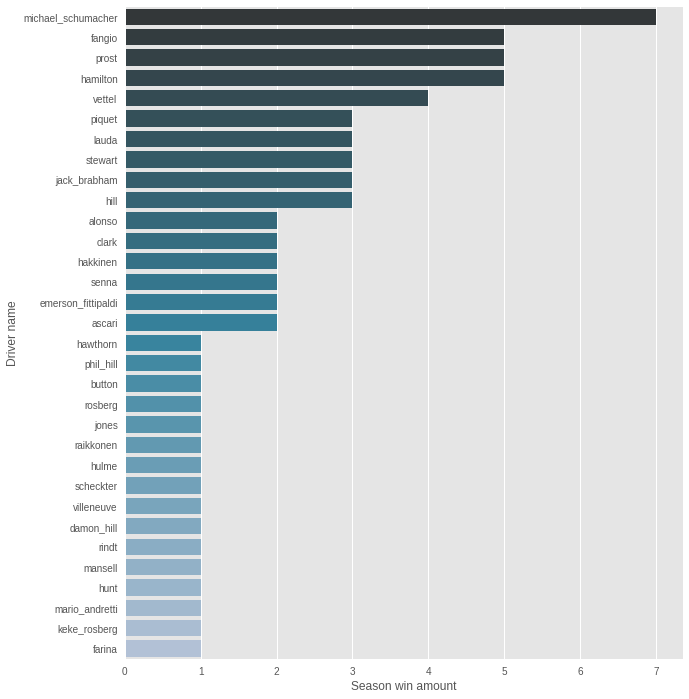

In [22]:
#Add a new column with the total amount of points for a driver over a season
#Create a new column, group by driverId and year, sum up the points (and put them in the column).
championships['driver_season_points'] = championships.groupby(['driverId', 'year'])['points'].transform(np.sum)

#Determine the winner of each championship:
#First order the data on drivers with high points first, then group by every year, taking the first driver of every year == winner
championship_winners = championships.sort_values(['driver_season_points'],ascending=False).groupby(['year'])[['driverId', 'driver_season_points', 'driverRef']].first()

#Count the number of wins per driver
#Create a new column, group by driver, count how many rows are in each group.
championship_winners['win-count'] = championship_winners.groupby(['driverId'])['driverId'].transform('count')

#Order the table from most to least wins
championship_winners  = championship_winners.sort_values(['win-count'], ascending=False)


#Plot a barplot with the findings
plt.figure(figsize=(10,12))
VI_1_plot = sns.barplot(y='driverRef', x='win-count', data=championship_winners, palette='PuBuGn_d')
VI_1_plot.set(xlabel='Season win amount', ylabel='Driver name')

### Race win count per constructor


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Constructor name'), Text(0.5,0,'Constructor win amount')]

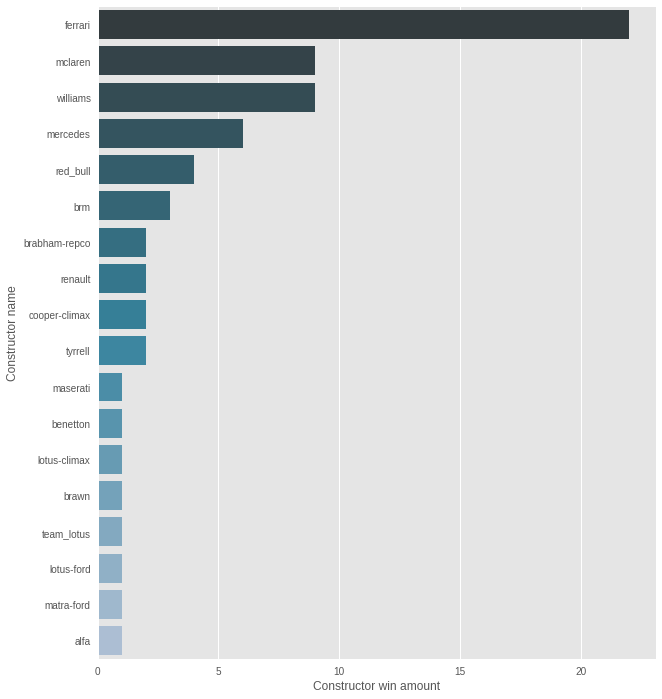

In [23]:
#Add the points per season to every constructor
championships['constructor_season_points'] = championships.groupby(['year', 'constructorId'])['points'].transform(np.sum)

#Sort the array on most points (descending), groupby year and take the first of very year (which is the winner)
championship_winners = championships.sort_values(['constructor_season_points'],ascending=False).groupby(['year'])[['constructorId', 'constructor_season_points', 'constructorRef']].first()

#Count the number of wins per constructor
championship_winners['cons_win-count'] = championship_winners.groupby(['constructorId'])['constructorId'].transform('count')

#Order the table from most to least wins0
championship_winners  = championship_winners.sort_values(['cons_win-count'], ascending=False)

#Plot a barplot with the findings
plt.figure(figsize=(10,12))
VI_1_plot = sns.barplot(y='constructorRef', x='cons_win-count', data=championship_winners, palette='PuBuGn_d')
VI_1_plot.set(xlabel='Constructor win amount', ylabel='Constructor name')

### Race/championship win count per driver nationality


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


driverId  driver_season_points driverRef nationality  nat_win-count
year                                                                     
2018         1                  95.0  hamilton     British             18
2009        18                  95.0    button     British             18
1976       231                  69.0      hunt     British             18
1971       328                  62.0   stewart     British             18
2008         1                  98.0  hamilton     British             18

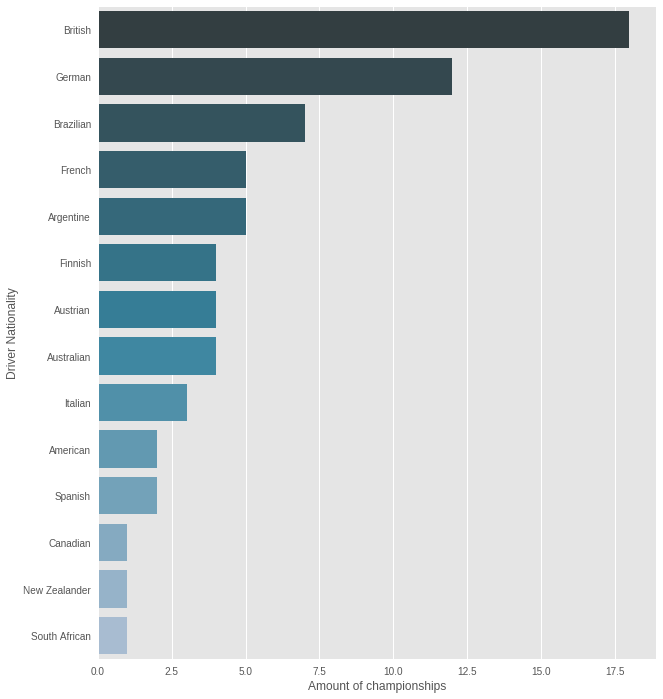

In [24]:
#Add a new column with the total amount of points for a driver over a season
championships['driver_season_points'] = championships.groupby(['driverId', 'year'])['points'].transform(np.sum)

#Determine the winner of each championship:
#First order the data on drivers with high points first, then group by every year, taking the first driver of every year == winner
championship_winners = championships.sort_values(['driver_season_points'],ascending=False).groupby(['year'])[['driverId', 'driver_season_points', 'driverRef', 'nationality']].first()

#Count the number of wins per driver
#Create a new column, group by driver, count how many rows are in each group.
championship_winners['nat_win-count'] = championship_winners.groupby(['nationality'])['nationality'].transform('count')

#Order the table from most to least wins
championship_winners  = championship_winners.sort_values(['nat_win-count'], ascending=False)


#Plot a barplot with the findings
plt.figure(figsize=(10,12))
VI_1_plot = sns.barplot(y='nationality', x='nat_win-count', data=championship_winners, palette='PuBuGn_d')
VI_1_plot.set(xlabel='Amount of championships', ylabel='Driver Nationality')
championship_winners.head()

### Race win count per driver and team


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Driver name'), Text(0.5,0,'Driver race wins')]

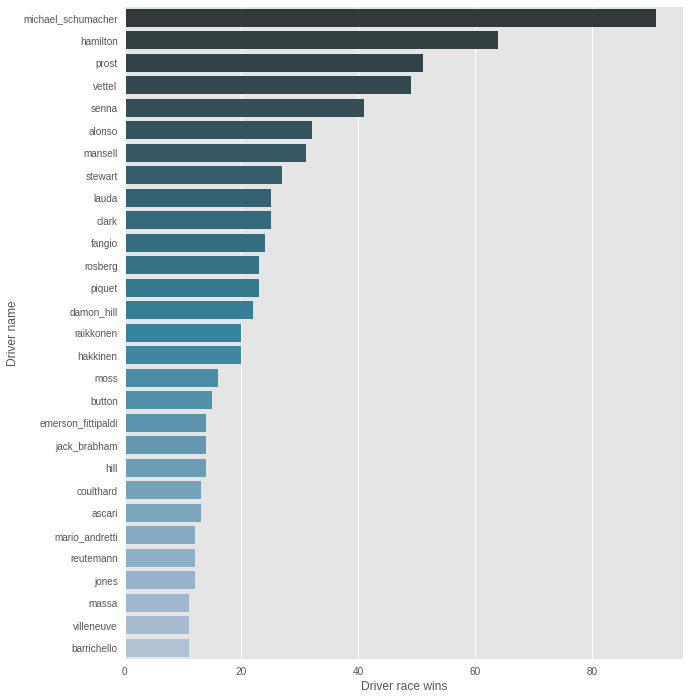

In [25]:
#Create a dataframe that contains every race winner
race_wins = results.loc[results['position'] == 1]

#For every racer count the numbers of wins, save them in a new column
race_wins['driver_race_wins'] = race_wins.groupby(['driverId'])['driverId'].transform('count')

#Only keep the racers that have 10 wins or more
race_wins = race_wins.loc[race_wins['driver_race_wins'] > 10]
#Order them on amount of wins descending 
race_wins = race_wins.sort_values(['driver_race_wins'], ascending=False)

#Get names of the drivers
race_wins_wNames = pd.merge(race_wins, drivers[['driverId','driverRef']], on='driverId')

#Plot the results
plt.figure(figsize=(10,12))
race_wins_plot = sns.barplot(y='driverRef', x='driver_race_wins', data=race_wins_wNames, palette='PuBuGn_d')
race_wins_plot.set(xlabel='Driver race wins', ylabel='Driver name')

### Team wins per era

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


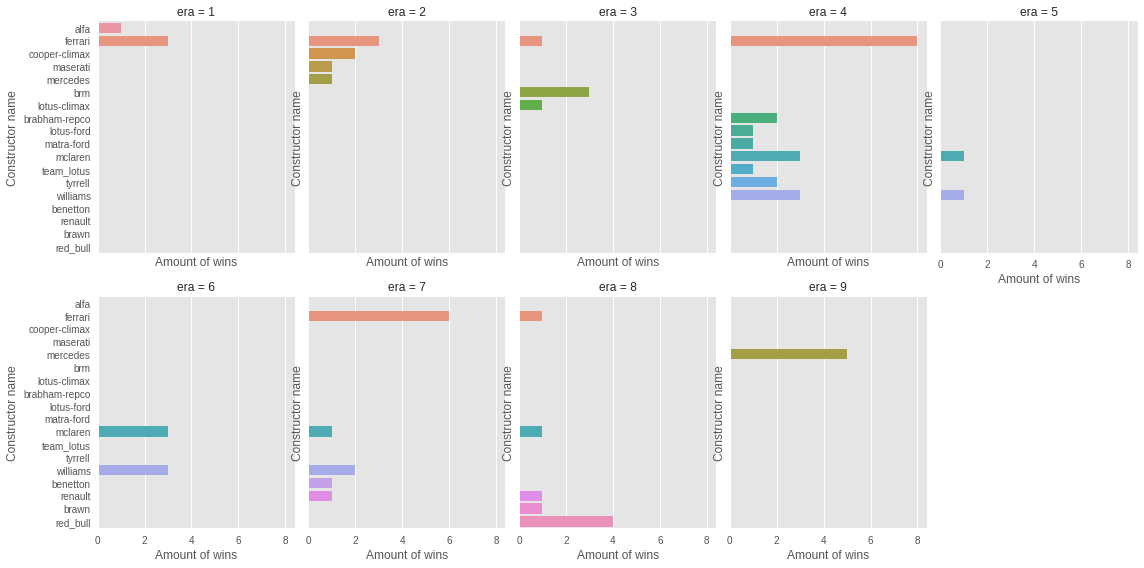

In [26]:
#Add the points per season to every constructor
championships['constructor_season_points'] = championships.groupby(['constructorId', 'year'])['points'].transform(np.sum)

#Sort the array on most points (descending), groupby year and take the first of very year (which is the winner)
championship_winners = championships.sort_values(['constructor_season_points'],ascending=False).groupby(['year'])[['constructorId', 'era', 'constructor_season_points', 'constructorRef']].first()

#Count the number of wins in an era per constructor
championship_winners['cons_win_era-count'] = championship_winners.groupby(['constructorId', 'era'])['constructorId'].transform('count')

#Plot a barplot with the findings
plt.figure(figsize=(10,12))

#Convert data into a form that is usefull for the factor plot
champs_eras = championship_winners.groupby(['era', 'constructorRef'])['era', 'constructorRef', 'cons_win_era-count'].first().reset_index()

#Plot the data
era_win_plot = sns.factorplot(y="constructorRef", col="era", data=champs_eras, x="cons_win_era-count", kind="bar", col_wrap=5, size=4, aspect=.8, legend=True, legend_out=False,sharex=True,sharey=True,orient='h')
era_win_plot.set(xlabel='Amount of wins', ylabel='Constructor name')

## Feature engineering

In [49]:
results_race = pd.merge(results, qualifying, how='left', on = ['raceId', 'driverId'], suffixes=('_res', '_quali'))
results_race = pd.merge(results_race, drivers, on = ['driverId'], suffixes=('_quali_res', '_driver'))
results_race = results_race.rename(index=str, columns={"constructorId_res": "constructorId"})
results_race = pd.merge(results_race, constructors, on = ['constructorId'], suffixes=('_quali_res', '_const'))
results_race = results_race.drop(["url_quali_res", "url_const"], axis=1)
results_race = results_race.rename(index=str, columns={"nationality_quali_res": "nationality_driver"})
results_race = pd.merge(results_race, races, on = ['raceId'], suffixes=('_quali_res', '_race'))
results_race = pd.merge(results_race, circuits, on = ['circuitId'], suffixes=('_quali_res', '_circuit'))
##results_race = results_race.drop(["qualifyId","resultId",'raceId', 'driverId', 'constructorId',"circuitId"], axis=1)
results_race = results_race.drop(["url_quali_res", "url_circuit"], axis=1)

results_race.head()
results_race.year.describe()

count    23877.000000
mean      1987.802069
std         18.041167
min       1950.000000
25%       1975.000000
50%       1989.000000
75%       2003.000000
max       2018.000000
Name: year, dtype: float64

In [0]:
results_race['retired'] = results_race.apply(lambda row: 1 if row['positionText'] == "R" else 0, axis=1)

In [51]:
results_race['dob'] = results_race['dob'].apply(pd.to_datetime).map(lambda x: pd.to_datetime(x, format = '%d/%m/%Y'))
results_race['date'] = results_race['date'].apply(pd.to_datetime).map(lambda x: pd.to_datetime(x, format = '%Y/%m/%d'))
results_race['age'] = ((results_race['date'] - results_race['dob']) / timedelta(days = 365))

results_race.head(5)

resultId  raceId  driverId  constructorId  number_res  grid  position_res  \
0         1      18         1              1        22.0     1           1.0   
1         5      18         5              1        23.0     3           5.0   
2         2      18         2              2         3.0     5           2.0   
3         9      18         9              2         4.0     2           NaN   
4         3      18         3              3         7.0     7           3.0   

  positionText  positionOrder  points    ...        country       lat  \
0            1              1    10.0    ...      Australia  -37.8497   
1            5              5     4.0    ...      Australia  -37.8497   
2            2              2     8.0    ...      Australia  -37.8497   
3            R              9     0.0    ...      Australia  -37.8497   
4            3              3     6.0    ...      Australia  -37.8497   

       lng  alt  circuitType  circuitLength circuitTurns  circuitDirection  \
0  144.968   10            1           5303           16                 1   
1  144.968   10            1           5303           16                 1   
2  144.968   10            1           5303           16                 1   
3  144.968   10            1           5303           16                 1   
4  144.968   10            1           5303           16                 1   

   retired        age  
0        0  22.723288  
1        0  26.424658  
2        0  30.465753  
3        1  23.693151  
4        0  22.734247  

[5 rows x 56 columns]

Here we  replace missing values for position_res with the number of drivers on the grid + 1. We do this to be able to calculate rolling averages when DNFs occured.

In [0]:
num_drivers_season = results_race.groupby('year')['grid'].max()

# num_drivers_season

In [53]:
def replace_DNF(retired, year, num_drivers_season, position_res):
  if retired == 1:
    return num_drivers_season[year]
  else:
    return position_res

  
results_race['position_res'] = results_race.apply(lambda row: replace_DNF(row['retired'], row['year'], num_drivers_season, row['position_res']), axis=1)

results_race.head()

resultId  raceId  driverId  constructorId  number_res  grid  position_res  \
0         1      18         1              1        22.0     1           1.0   
1         5      18         5              1        23.0     3           5.0   
2         2      18         2              2         3.0     5           2.0   
3         9      18         9              2         4.0     2          22.0   
4         3      18         3              3         7.0     7           3.0   

  positionText  positionOrder  points    ...        country       lat  \
0            1              1    10.0    ...      Australia  -37.8497   
1            5              5     4.0    ...      Australia  -37.8497   
2            2              2     8.0    ...      Australia  -37.8497   
3            R              9     0.0    ...      Australia  -37.8497   
4            3              3     6.0    ...      Australia  -37.8497   

       lng  alt  circuitType  circuitLength circuitTurns  circuitDirection  \
0  144.968   10            1           5303           16                 1   
1  144.968   10            1           5303           16                 1   
2  144.968   10            1           5303           16                 1   
3  144.968   10            1           5303           16                 1   
4  144.968   10            1           5303           16                 1   

   retired        age  
0        0  22.723288  
1        0  26.424658  
2        0  30.465753  
3        1  23.693151  
4        0  22.734247  

[5 rows x 56 columns]

In [54]:
# Rolling means for race and quali results

# results_race = results_race[:10]

results_race = results_race.sort_values(['driverId', 'datetime'], ascending=True)

#previous 5 races
results_race['avg_pos_5'] = results_race.groupby(['driverId'])['position_res'].shift(1).rolling(window=5, min_periods=3).mean()
#previous 2 races
results_race['avg_pos_2'] = results_race.groupby(['driverId'])['position_res'].shift(1).rolling(window=2, min_periods=1).mean()
#previous 2 races
results_race['pos_last'] = results_race['position_res'].shift()

# results_race['avg_pos_5'] = results_race['position_res'].shift().where(rankLastYear['driverId'].shift() == results_race['driverId'], '')

results_race['avg_grid_5'] = None
results_race['avg_grid_2'] = None
results_race['grid_last'] = None

#previous 5 races quali
results_race['avg_grid_5'] = results_race.groupby(['driverId'])['grid'].shift(1).rolling(window=5, min_periods=3).mean()
#previous 2 races quali
results_race['avg_grid_2'] = results_race.groupby(['driverId'])['grid'].shift(1).rolling(window=2, min_periods=1).mean()
#previous 1 races quali
results_race['grid_last'] = results_race.groupby(['driverId'])['grid'].shift(1)


#retirements over last x races
results_race['retired_5'] = results_race.groupby(['driverId'])['retired'].shift(1).rolling(window=10, min_periods=1).mean()


#position_quali vs. grid diff
results_race['quali_grid_diff'] = results_race['position_quali'] - results_race['grid']

# print(results_race.info())
results_race.sort_values(['resultId','driverId', 'datetime'], ascending=True).head(10)

resultId  raceId  driverId  constructorId  number_res  grid  position_res  \
0          1      18         1              1        22.0     1           1.0   
2          2      18         2              2         3.0     5           2.0   
4          3      18         3              3         7.0     7           3.0   
6          4      18         4              4         5.0    11           4.0   
1          5      18         5              1        23.0     3           5.0   
5          6      18         6              3         8.0    13           6.0   
10         7      18         7              5        14.0    17           7.0   
8          8      18         8              6         1.0    15           8.0   
3          9      18         9              2         4.0     2          22.0   
12        10      18        10              7        12.0    18          22.0   

   positionText  positionOrder  points       ...         retired        age  \
0             1              1    10.0       ...               0  22.723288   
2             2              2     8.0       ...               0  30.465753   
4             3              3     6.0       ...               0  22.734247   
6             4              4     5.0       ...               0  26.649315   
1             5              5     4.0       ...               0  26.424658   
5             6              6     3.0       ...               0  22.386301   
10            7              7     2.0       ...               0  29.065753   
8             8              8     1.0       ...               0  28.432877   
3             R              9     0.0       ...               1  23.693151   
12            R             10     0.0       ...               1  26.013699   

   avg_pos_5  avg_pos_2  pos_last  avg_grid_5 avg_grid_2  grid_last  \
0       7.20       14.5       7.0        2.00        1.5        2.0   
2       7.20        6.5       6.0        5.80        7.0        6.0   
4      10.80       10.0       4.0       10.80       12.5       10.0   
6       6.20        2.5       3.0        2.80        4.0        4.0   
1       9.60       15.5      22.0       11.40       15.0       17.0   
5      14.25       10.0      10.0       17.25       19.0       19.0   
10     13.50       20.0      13.0       12.75        9.0        NaN   
8       1.80        1.0       1.0        2.80        2.5        3.0   
3       9.60       13.5       5.0        9.00        8.0        7.0   
12     13.00       15.0      15.0       16.50       17.0       17.0   

    retired_5  quali_grid_diff  
0    0.100000              0.0  
2    0.000000              0.0  
4    0.200000              0.0  
6    0.100000              1.0  
1    0.100000              0.0  
5    0.000000              1.0  
10   0.111111              1.0  
8    0.100000              1.0  
3    0.100000              0.0  
12   0.111111             -9.0  

[10 rows x 64 columns]

In [55]:
#position on circuit last year
results_race['avg_pos_3y'] = None
results_race['pos_last_year'] = None

results_race = results_race.sort_values(['driverId', 'circuitId', 'year'])
results_race['avg_pos_3y'] = results_race.groupby(['driverId', 'circuitId'])['position_res'].shift(1).rolling(window=3, min_periods=1).mean()
results_race['pos_last_year'] = results_race.groupby(['driverId', 'circuitId'])['position_res'].shift(1)

#relative speed
results_race['rel_speed'] = None
results_race['fastestLapTime'] = results_race['fastestLapTime'].astype('float')

results_race['rel_speed'] = results_race['fastestLapTime']/(results_race.groupby(['raceId'])['fastestLapTime'].transform('min'))


#results_race = results_race.sort_values(['driverId', 'circuitId', 'year'], ascending=True)
results_race['rel_speed_last_year'] = results_race.groupby(['driverId', 'circuitId'])['rel_speed'].shift(1)
results_race['rel_speed_3y'] = results_race.groupby(['driverId', 'circuitId'])['rel_speed'].shift(1).rolling(window=3, min_periods=1).mean()

results_race.sort_values(['driverId', 'circuitId', 'year'], ascending=True)[['driverId','circuitId','raceId', 'year', 'fastestLapTime', 'rel_speed', 'rel_speed_last_year', 'rel_speed_3y', 'pos_last_year', 'avg_pos_3y']].head(20)

driverId  circuitId  raceId  year  fastestLapTime  rel_speed  \
22          1          1      36  2007         86004.0   1.011788   
0           1          1      18  2008         87005.0   1.000011   
44          1          1       1  2009         89000.0   1.022906   
64          1          1     338  2010         88005.0   1.000011   
88          1          1     841  2011         90003.0   1.022657   
112         1          1     860  2012         89005.0   1.000034   
438         1          1     880  2013         89008.0   1.000056   
460         1          1     900  2014        109009.0   1.184816   
482         1          1     926  2015         90009.0   1.000000   
138         1          1     948  2016         90006.0   1.011303   
160         1          1     969  2017         87000.0   1.011569   
180         1          1     989  2018         86444.0   1.005806   
520         1          2      37  2007         96007.0   1.000000   
498         1          2      19  2008         95005.0   1.000011   
542         1          2       2  2009         99001.0   1.031196   
562         1          2     339  2010         97007.0   1.000062   
586         1          2     842  2011        101005.0   1.009989   
610         1          2     861  2012        101005.0   1.009979   
868         1          2     881  2013        101000.0   1.020181   
890         1          2     901  2014        103001.0   1.000000   

     rel_speed_last_year  rel_speed_3y  pos_last_year  avg_pos_3y  
22                   NaN           NaN            NaN         NaN  
0               1.011788      1.011788            3.0    3.000000  
44              1.000011      1.005900            1.0    2.000000  
64              1.022906      1.011569            NaN    2.000000  
88              1.000011      1.007643            6.0    3.500000  
112             1.022657      1.015191            2.0    4.000000  
438             1.000034      1.007567            3.0    3.666667  
460             1.000056      1.007582            5.0    3.333333  
482             1.184816      1.061635           22.0   10.000000  
138             1.000000      1.061624            1.0    9.333333  
160             1.011303      1.065373            2.0    8.333333  
180             1.011569      1.007624            2.0    1.666667  
520                  NaN      1.011436            NaN    2.000000  
498             1.000000      1.005785            2.0    2.000000  
542             1.000011      1.000005            5.0    3.500000  
562             1.031196      1.010402            7.0    4.666667  
586             1.000062      1.010423            6.0    6.000000  
610             1.009989      1.013749            8.0    7.000000  
868             1.009979      1.006677            3.0    5.666667  
890             1.020181      1.013383            3.0    4.666667

In [56]:
results_race['avg_pos_3y'].isnull().sum()

2718

In [57]:
# Position gain/loss

# Absolute
results_race['abs_pos_gain'] = results_race['grid'] - results_race['position_res']

# Relative
results_race['rel_pos_gain'] = ((results_race['grid'] - results_race['position_res']))/(results_race['grid'])/(results_race['position_res'])


results_race['avg_abs_pos_gain'] = results_race.groupby(['driverId'])['abs_pos_gain'].transform('mean')
results_race['avg_rel_pos_gain'] = results_race.groupby(['driverId'])['rel_pos_gain'].transform('mean')


results_race = results_race.sort_values(['driverId', 'datetime'], ascending=True) 
#previous 5 races
results_race['abs_pos_gain_5'] = results_race['abs_pos_gain'].shift(1).rolling(window=5, min_periods=3).mean()
#previous 2 races
results_race['abs_pos_gain_2'] = results_race['abs_pos_gain'].shift(1).rolling(window=2).mean()
#previous 1 race
results_race['abs_pos_gain_1'] = results_race['abs_pos_gain'].shift(1)


#previous 5 races
results_race['rel_pos_gain_5'] = results_race['rel_pos_gain'].shift(1).rolling(window=5, min_periods=3).mean()
#previous 2 races
results_race['rel_pos_gain_2'] = results_race['rel_pos_gain'].shift(1).rolling(window=2).mean()
#previous 1 race
results_race['rel_pos_gain_1'] = results_race['rel_pos_gain'].shift(1)



#results_race = results_race.sort_values(['driverId', 'datetime'], ascending=True)
results_race.sort_values(['rel_pos_gain'], ascending=True).head(20)

resultId  raceId  driverId  constructorId  number_res  grid  \
172       23395     969       817              9         3.0     0   
686       23681     983         8              6         7.0     0   
2162      23043     953       831             15        12.0     0   
2147      22645     931       832              5        55.0     0   
2170      23044     953       830              9        33.0     0   
16110     11659     486       136             54         9.0     0   
10695     19626     816       647              6         4.0     1   
9025      19498     811       579            105         4.0     1   
12803     19131     794       659            129        23.0     1   
6088      18629     771       475            118         7.0     1   
12480     19881     826       699            113        18.0     1   
10615     18690     774       475            118        26.0     1   
3478      18508     766       479            118        30.0     1   
3423      18295     756       475            170        30.0     1   
17345     18895     784       579              6        30.0     1   
8765      19144     795       608            132        30.0     1   
12412     19687     818       615            113        28.0     1   
12649     18569     768       537            107        97.0     1   
17299     18083     746       475            170        36.0     1   
23804     18478     764       475            170         7.0     1   

       position_res positionText  positionOrder  points       ...        \
172            20.0            R             17     0.0       ...         
686            20.0            R             20     0.0       ...         
2162           22.0            R             17     0.0       ...         
2147           10.0           10             10     1.0       ...         
2170           22.0            R             18     0.0       ...         
16110          28.0            R             27     0.0       ...         
10695          34.0            R             17     0.0       ...         
9025           34.0            R             15     0.0       ...         
12803          33.0            R             31     0.0       ...         
6088           33.0            R             14     0.0       ...         
12480          33.0            R             10     0.0       ...         
10615          33.0            R             14     0.0       ...         
3478           33.0            R             15     0.0       ...         
3423           33.0            R              7     0.0       ...         
17345          33.0            R             13     0.0       ...         
8765           33.0            R             11     0.0       ...         
12412          33.0            R             27     0.0       ...         
12649          33.0            R             27     0.0       ...         
17299          33.0            R             17     0.0       ...         
23804          33.0            R             14     0.0       ...         

       abs_pos_gain rel_pos_gain avg_abs_pos_gain  avg_rel_pos_gain  \
172           -20.0         -inf        -0.537879              -inf   
686           -20.0         -inf        -1.880866              -inf   
2162          -22.0         -inf         1.538462              -inf   
2147          -10.0         -inf        -1.230769              -inf   
2170          -22.0         -inf        -2.338462              -inf   
16110         -28.0         -inf         0.913043              -inf   
10695         -33.0    -0.970588        -9.638889         -0.106596   
9025          -33.0    -0.970588        -7.275862         -0.128469   
12803         -32.0    -0.969697        -8.800000         -0.202294   
6088          -32.0    -0.969697       -11.911765         -0.099882   
12480         -32.0    -0.969697       -15.333333         -0.378982   
10615         -32.0    -0.969697       -11.911765         -0.099882   
3478          -32.0    -0.969697     

In [58]:
results_race.loc[results_race['driverId'] == 832][['datetime', 'grid']].sort_values(['grid']).head()


datetime  grid
2147  2015-05-24 12:00:00     0
1358  2015-05-10 12:00:00     5
2168  2016-05-29 12:00:00     6
7255  2016-07-24 12:00:00     6
10930 2016-09-18 12:00:00     6

In [59]:
# Quali time difference

# Absolute
results_race['rel_q1_diff'] = results_race['q1']/results_race.groupby(['raceId'])['q1'].transform('min')
results_race['rel_q2_diff'] = results_race['q2']/results_race.groupby(['raceId'])['q2'].transform('min')
results_race['rel_q3_diff'] = results_race['q3']/results_race.groupby(['raceId'])['q3'].transform('min')


results_race[['raceId', 'driverId', 'q1', 'q2', 'q3', 'rel_q1_diff', 'rel_q2_diff', 'rel_q3_diff']].sort_values(['raceId', 'q2']).head(25)

raceId  driverId       q1       q2       q3  rel_q1_diff  rel_q2_diff  \
63        1        22  85006.0  84783.0  86505.0     1.000000     1.000000   
62        1        18  85211.0  84855.0  86202.0     1.002412     1.000849   
59        1        20  85938.0  85121.0  86830.0     1.010964     1.003987   
48        1         3  85846.0  85123.0  86973.0     1.009882     1.004010   
47        1         9  85922.0  85152.0  86914.0     1.010776     1.004352   
58        1        17  85427.0  85241.0  87246.0     1.004953     1.005402   
57        1        15  86194.0  85265.0  87127.0     1.013975     1.005685   
56        1        10  85499.0  85281.0  86975.0     1.005800     1.005874   
53        1        13  85844.0  85319.0  87033.0     1.009858     1.006322   
52        1         8  85899.0  85380.0  87163.0     1.010505     1.007042   
46        1         2  85827.0  85504.0      NaN     1.009658     1.008504   
50        1         4  86026.0  85605.0      NaN     1.011999     1.009695   
49        1         6  86074.0  85607.0      NaN     1.012564     1.009719   
45        1         5  86184.0  85726.0      NaN     1.013858     1.011123   
44        1         1  86454.0      NaN      NaN     1.017034          NaN   
54        1         7  86964.0      NaN      NaN     1.023034          NaN   
51        1        12  86598.0      NaN      NaN     1.018728          NaN   
60        1        16  86742.0      NaN      NaN     1.020422          NaN   
61        1        21  86677.0      NaN      NaN     1.019657          NaN   
55        1        67  86503.0      NaN      NaN     1.017611          NaN   
560       2        18  95058.0  93784.0  95181.0     1.003982     1.000000   
555       2        15  94745.0  93990.0  95273.0     1.000676     1.002197   
556       2        17  95027.0  94222.0  95797.0     1.003654     1.004670   
554       2        10  94907.0  94258.0  95690.0     1.002387     1.005054   
557       2        20  94935.0  94276.0  95518.0     1.002683     1.005246   

     rel_q3_diff  
63      1.003515  
62      1.000000  
59      1.007285  
48      1.008944  
47      1.008260  
58      1.012111  
57      1.010731  
56      1.008967  
53      1.009640  
52      1.011148  
46           NaN  
50           NaN  
49           NaN  
45           NaN  
44           NaN  
54           NaN  
51           NaN  
60           NaN  
61           NaN  
55           NaN  
560     1.000000  
555     1.000967  
556     1.006472  
554     1.005348  
557     1.003541

In [60]:
# Number of races started

def race_counter(driverId, driver_race_count):
  '''
  Similar as DNF count but for the amount of races.
  '''
  if driverId in driver_race_count:
    driver_race_count[driverId] += 1
    return driver_race_count[driverId]
  else:
    driver_race_count[driverId] = 0
    return driver_race_count[driverId]

driver_race_count = {}


results_race['num_races'] = results_race.sort_values(['driverId', 'datetime']).driverId.map(lambda x: race_counter(x, driver_race_count))

results_race.sort_values(['num_races'], ascending=False).head(20)

resultId  raceId  driverId  constructorId  number_res  grid  \
11506     21221     859        22              3        11.0    12   
14501     21195     858        22              3        11.0    24   
14747     21174     857        22              3        11.0    15   
14677     21147     856        22              3        11.0    18   
13810     21128     855        22              3        11.0    13   
10853     21100     854        22              3        11.0    12   
9179      21075     853        22              3        11.0    13   
8061      21055     852        22              3        11.0    14   
7178      21028     851        22              3        11.0    15   
12852     21014     850        22              3        11.0    14   
5007      20980     849        22              3        11.0    15   
7927      20955     848        22              3        11.0    13   
3615      20928     847        22              3        11.0    16   
2091      20905     846        22              3        11.0    11   
1302      20889     845        22              3        11.0    19   
1939      20863     844        22              3        11.0    11   
11184     20837     843        22              3        11.0    15   
590       20822     842        22              3        11.0    15   
2455      23496     974        18              1        22.0    20   
92        20794     841        22              3        11.0    17   

       position_res positionText  positionOrder  points    ...      \
11506          14.0           14             14     0.0    ...       
14501          12.0           12             12     0.0    ...       
14747          15.0           15             15     0.0    ...       
14677          12.0           12             12     0.0    ...       
13810          17.0           17             17     0.0    ...       
10853          13.0           13             13     0.0    ...       
9179           12.0           12             12     0.0    ...       
8061           16.0           16             16     0.0    ...       
7178           13.0           13             13     0.0    ...       
12852          24.0            R             23     0.0    ...       
5007           13.0           13             13     0.0    ...       
7927           12.0           12             12     0.0    ...       
3615            9.0            9              9     2.0    ...       
2091            9.0            9              9     2.0    ...       
1302           17.0           17             17     0.0    ...       
1939           15.0           15             15     0.0    ...       
11184          13.0           13             13     0.0    ...       
590            24.0            R             22     0.0    ...       
2455           20.0            R             18     0.0    ...       
92             24.0            R             16     0.0    ...       

       abs_pos_gain_5 abs_pos_gain_2 abs_pos_gain_1  rel_pos_gain_5  \
11506             2.6            6.0           12.0        0.008987   
14501             0.4            3.0            0.0        0.001936   
14747             0.0            1.0            6.0        0.000150   
14677            -0.8           -2.5           -4.0       -0.003354   
13810            -2.0            0.0           -1.0       -0.005687   
10853            -1.4           -0.5            1.0       -0.002353   
9179             -1.4            0.0           -2.0       -0.002353   
8061              0.4           -4.0            2.0        0.009154   
7178              0.4           -4.0          -10.0        0.011144   
12852             2.8            1.5            2.0        0.018334   
5007              1.6            4.0            1.0        0.011435   
7927              1.8            4.5            7.0        0.012204   
3615             -1.4            2.0            2.0       -0.002518   
2091             -3.2           -1.0            2.0       -0.009990   


In [0]:
# Number of races won

def win_counter(driverId, position_res, driver_win_count):
  '''
  Similar as DNF count but for the amount of races.
  '''
  if (driverId in driver_win_count) and position_res == 1:
    driver_win_count[driverId] += 1
  elif (driverId not in driver_win_count) and position_res == 1:
    driver_win_count[driverId] = 1
  elif (driverId not in driver_win_count) and position_res != 1:
    driver_win_count[driverId] = 0
  return driver_win_count[driverId]

driver_win_count = {}


# For calculating win percentage
def win_percentage(win_count, num_races):
  if num_races == 0:
    return 0
  else:
    return win_count/num_races

  
#results_race['win_count'] = map(lambda x, y: win_counter(x, y, driver_win_count), results_race['driverId'], results_race['position_res'])
results_race['win_count'] = results_race.sort_values(['driverId', 'datetime']).apply(lambda row: win_counter(row['driverId'], row['position_res'], driver_win_count), axis=1)
results_race['win_count'] = results_race.groupby(['driverId'])['win_count'].shift(1)
results_race['win_count'].fillna(0, inplace=True)
results_race['win_count'] = results_race['win_count'].astype('int')

# Win percentage
results_race['win_perc'] = results_race.apply(lambda row: win_percentage(row['win_count'], row['num_races']), axis=1)

## Feature pair correlation

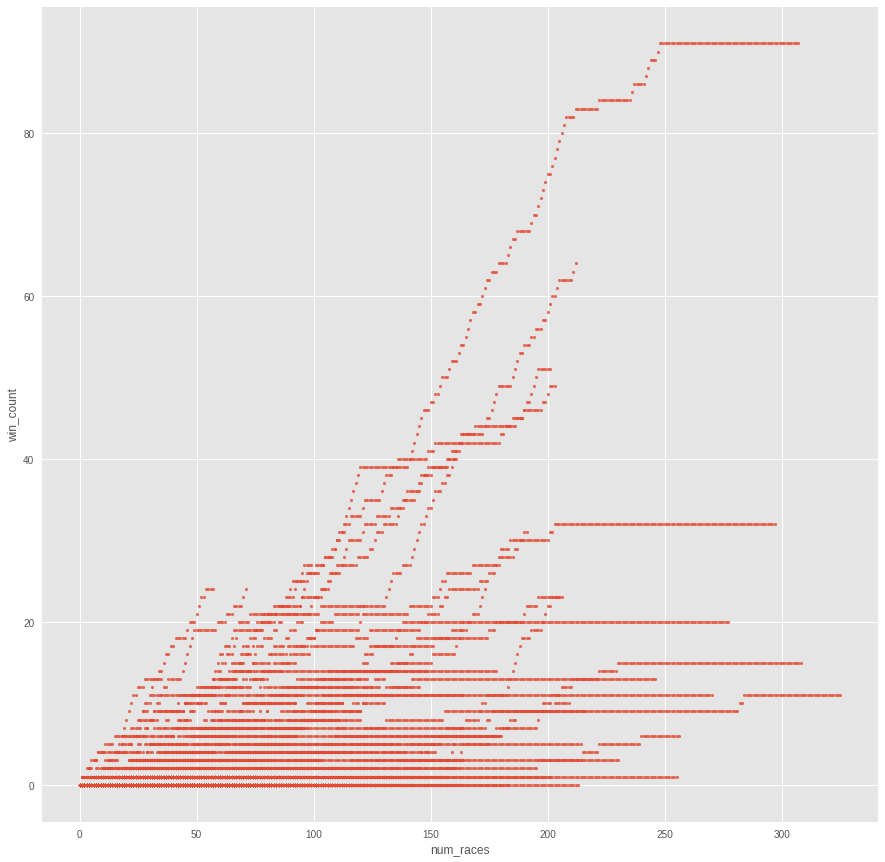

In [39]:
plt.figure(figsize=(15,15))
sns.regplot(x=results_race.num_races, y=results_race.win_count, scatter_kws={"s": 10}, fit_reg=False)

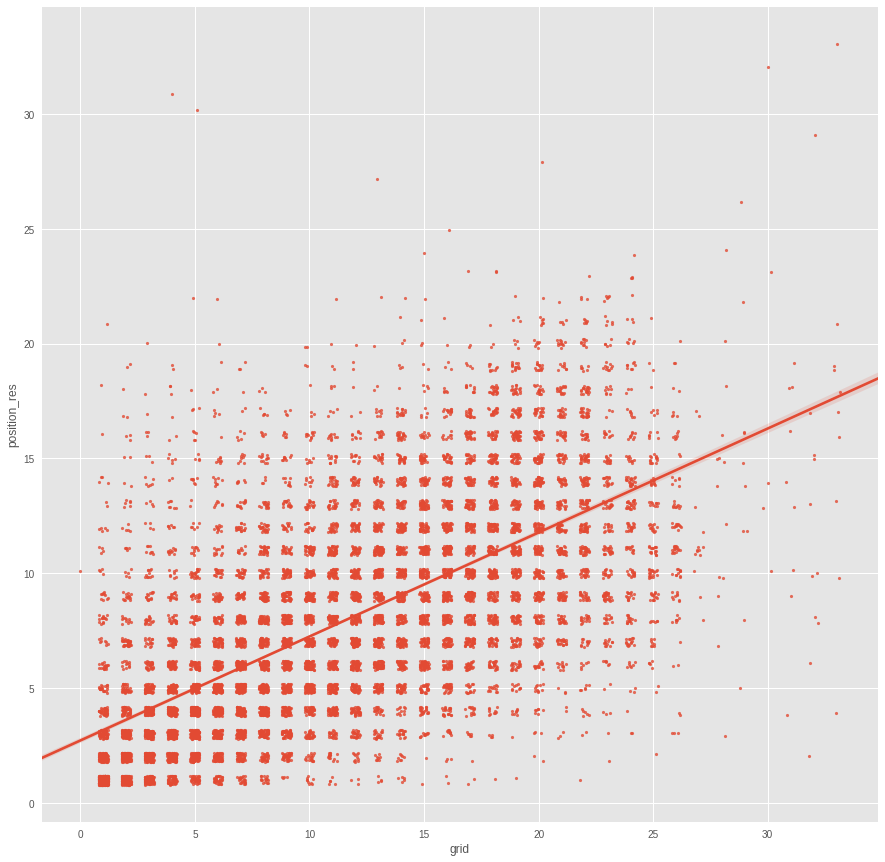

In [40]:
plt.figure(figsize=(15,15))
sns.regplot(x='grid', y='position_res', data=results_race[results_race['retired']==0], x_jitter=0.2, y_jitter=.2, scatter_kws={"s": 10})

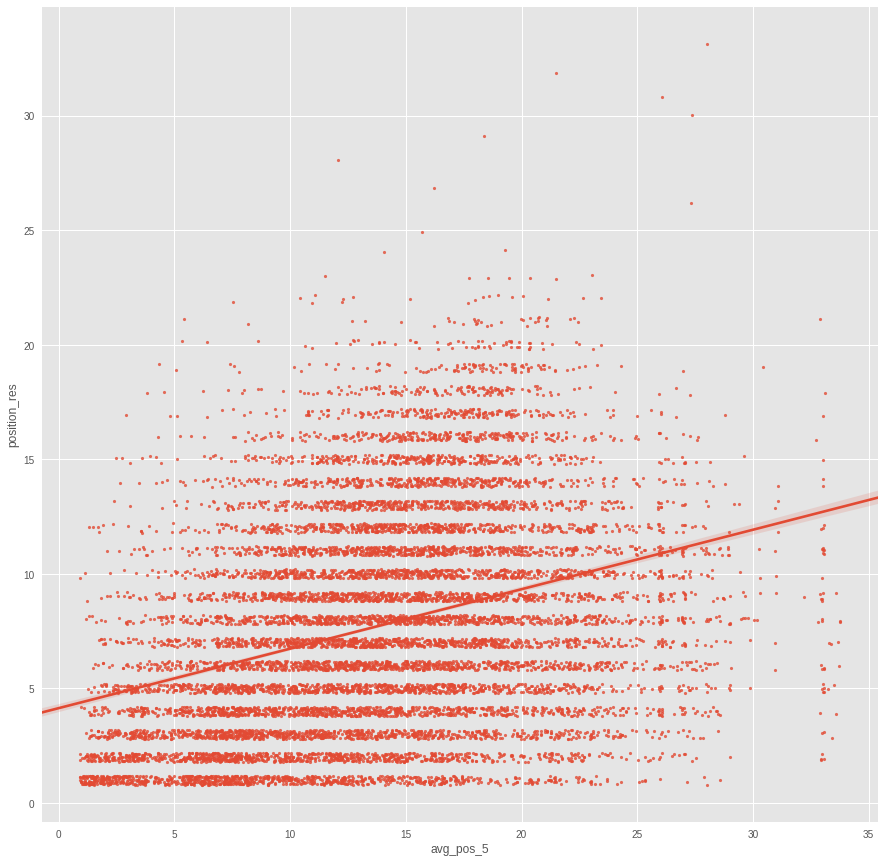

In [41]:
plt.figure(figsize=(15,15))
sns.regplot(x='avg_pos_5', y='position_res', data=results_race[results_race['retired']==0], x_jitter=0.1, y_jitter=.2, scatter_kws={"s": 10})

[Text(0,0.5,'Position result'), Text(0.5,0,'Average grid over last 5 races')]

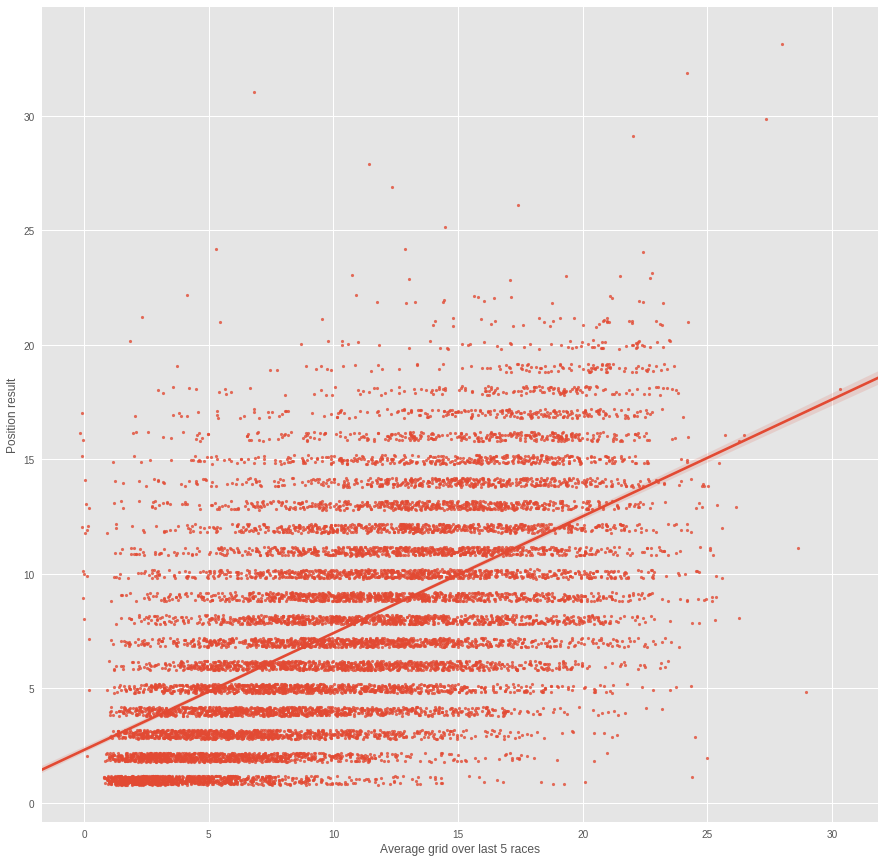

In [42]:
plt.figure(figsize=(15,15))
sns.regplot(x='avg_grid_5', y='position_res', data=results_race[results_race['retired']==0], x_jitter=0.2, y_jitter=.2, scatter_kws={"s": 10}).set(xlabel='Average grid over last 5 races', ylabel='Position result')

[Text(0,0.5,'Position result'), Text(0.5,0,'Win percentage')]

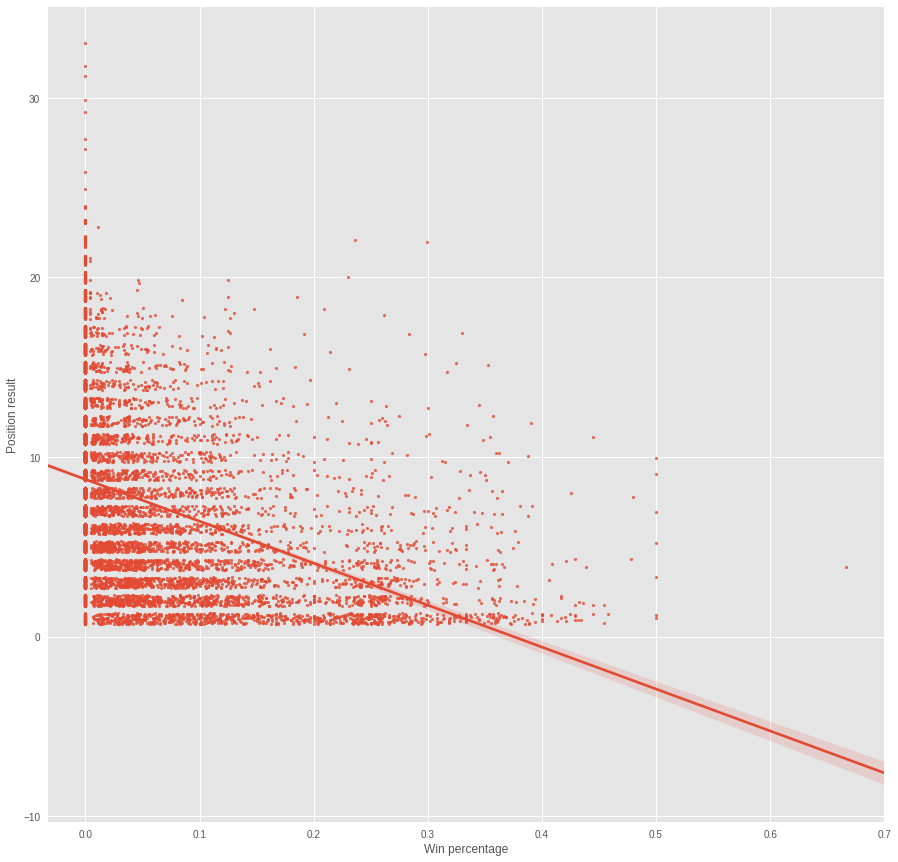

In [43]:
plt.figure(figsize=(15,15))
sns.regplot(x='win_perc', y='position_res', data=results_race[results_race['retired']==0], x_jitter=.0, y_jitter=.3, scatter_kws={"s": 10}).set(xlabel='Win percentage', ylabel='Position result')

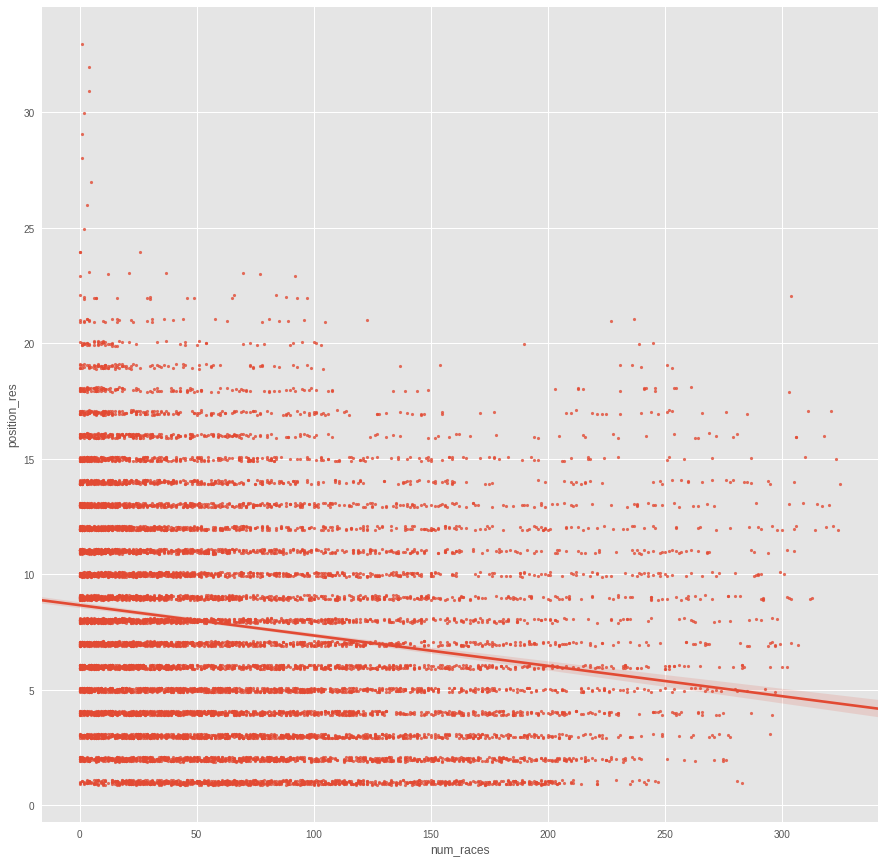

In [44]:
plt.figure(figsize=(15,15))
sns.regplot(x='num_races', y='position_res', data=results_race[results_race['retired']==0], x_jitter=0.0, y_jitter=.1, scatter_kws={"s": 10})

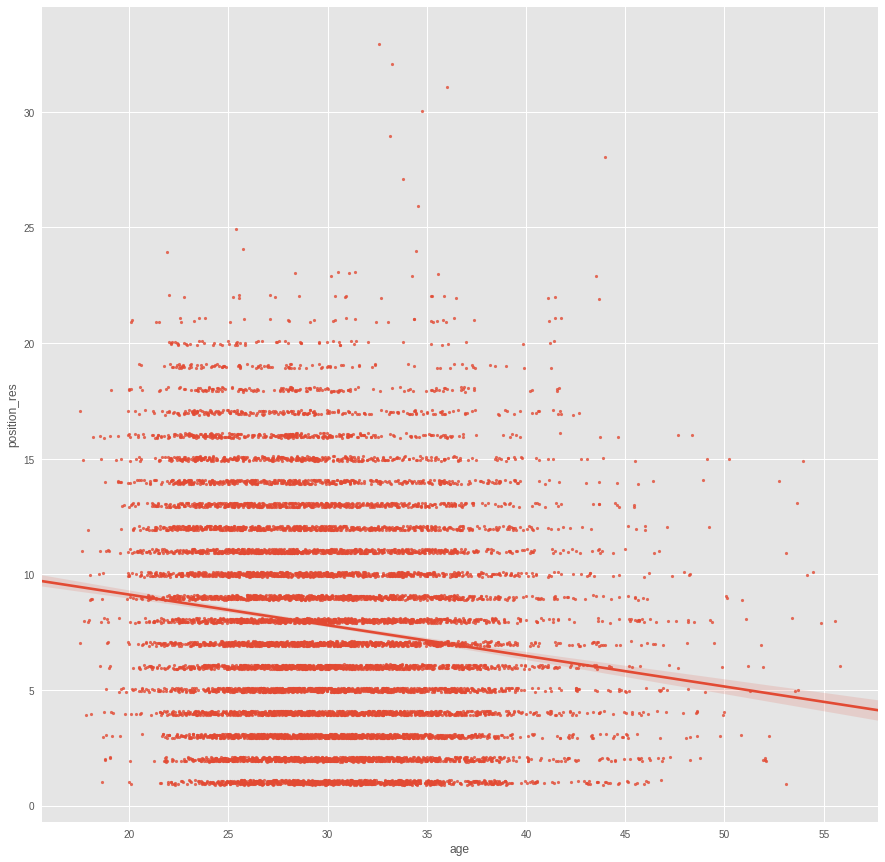

In [45]:
plt.figure(figsize=(15,15))
sns.regplot(x='age', y='position_res', data=results_race[results_race['retired']==0], x_jitter=0.0, y_jitter=.1, scatter_kws={"s": 10})

## Correlation Matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5]),
 <a list of 52 Text yticklabel objects>)

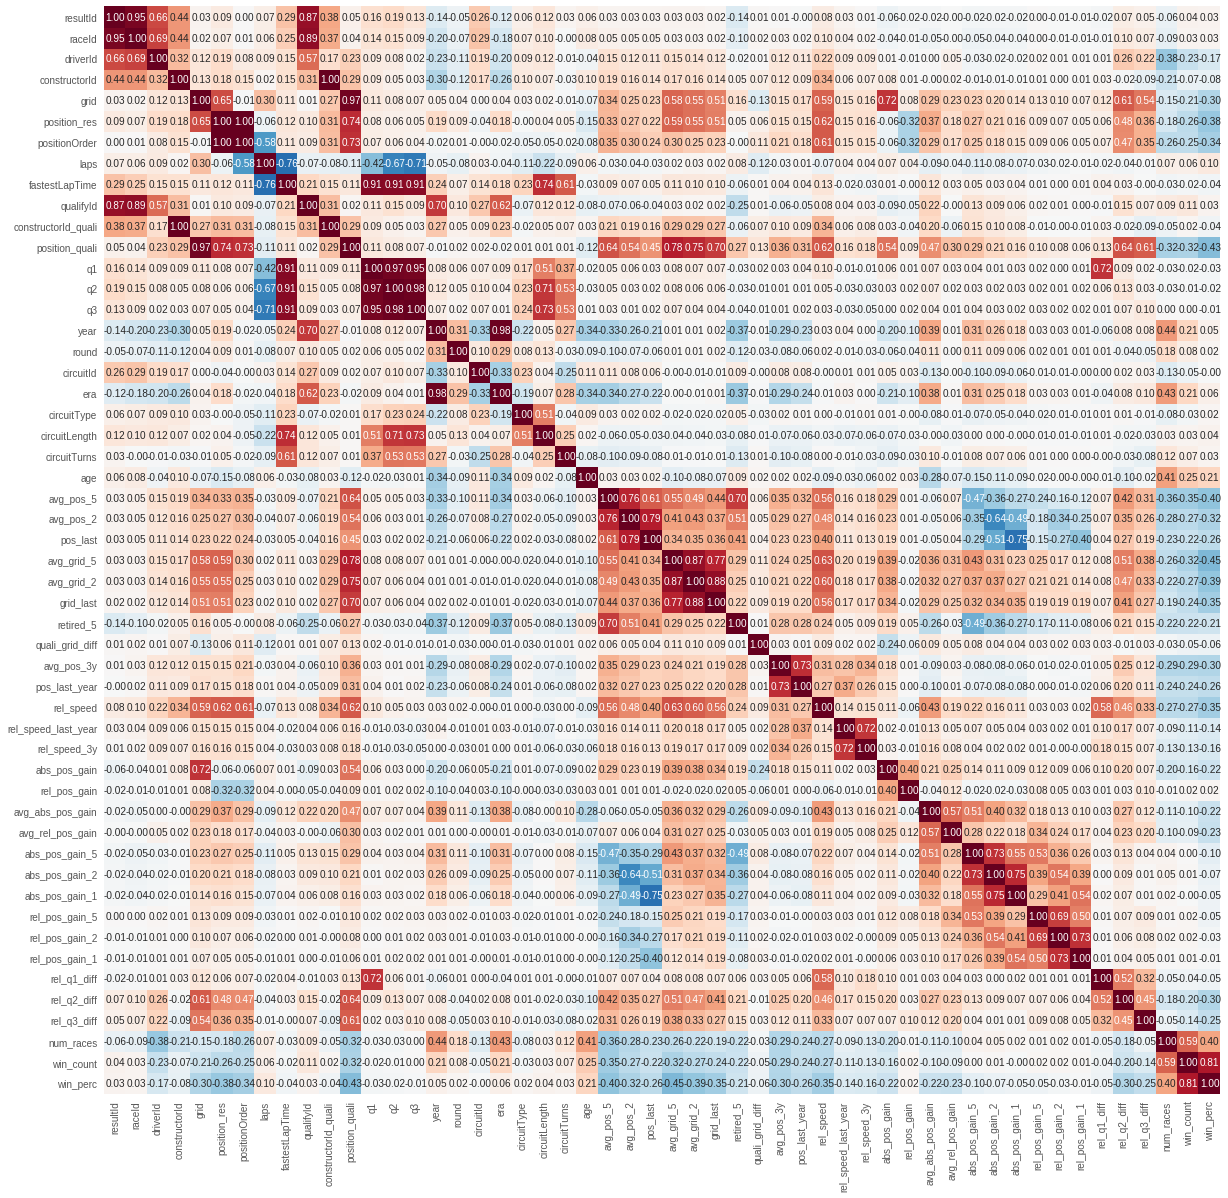

In [46]:
drop_cols = ["number_res", "points", "fastestLap", "number_quali", 'rank', 'statusId', 'circuitDirection', 'retired']

corr_plot = results_race[results_race['retired']==0].drop(drop_cols, axis=1)

plt.figure(figsize=(20,20))
sns.heatmap(corr_plot.corr() ,annot = True, fmt = ".2f", cbar = False)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)  

# Predictive analysis

### Dropping irrelevant columns

In [0]:
results_race_cols = list(results_race)

drop_cols = ['resultId',
'alt',
#'raceId',
'positionText',
'positionOrder',
'points',
'laps',
'time_quali_res',
'milliseconds',
'fastestLap',
'rank',
'rel_speed',
'fastestLapTime',
'fastestLapSpeed',
'statusId',
'qualifyId',
'constructorId_quali',
'number_quali',
'position_quali',
'q1',
'q2',
'q3',
'number',
'code',
'forename',
'surname',
'dob',
'name_quali_res',
'circuitId',
'name_race',
'date',
'name',
'location',
'lat',
'lng',
'abs_pos_gain',
'rel_pos_gain',
'number_res',
'driverRef',
'constructorRef',
'datetime'
]

# results_race_cols

### Filling/removing null values

In [0]:
max_q1_diff = results_race.groupby('raceId')['rel_q1_diff'].max()

In [0]:
def fillQualiDiff(rel_q_diff, raceId, max_q1_diff):
  if math.isnan(rel_q_diff):
    return max_q1_diff[raceId]
  else:
    return rel_q_diff

results_race['rel_q1_diff'] = results_race.apply(lambda row: fillQualiDiff(row['rel_q1_diff'], row['raceId'], max_q1_diff), axis = 1)

In [65]:
results_race.sort_values('raceId', ascending=False)

resultId  raceId  driverId  constructorId  number_res  grid  \
1417      23868     993       832              4        55.0     9   
1411      23863     993       822            131        77.0     2   
1426      23879     993       154            210         8.0    10   
1427      23867     993       825            210        20.0     7   
1419      23865     993        20              6         5.0     3   
1409      23876     993       838              1         2.0    11   
1412      23872     993       840              3        18.0    18   
1416      23881     993       807              4        27.0    16   
1424      23870     993       815             10        11.0    15   
1410      23862     993         1            131        44.0     1   
1422      23866     993       817              9         3.0     6   
1408      23869     993         4              1        14.0     8   
1414      23874     993       828             15         9.0    17   
1420      23880     993       842              5        10.0    12   
1413      23875     993       845              3        35.0    19   
1421      23873     993       843              5        28.0    20   
1423      23864     993       830              9        33.0     5   
1425      23877     993       839             10        31.0    13   
1418      23878     993         8              6         7.0     4   
1415      23871     993       844             15        16.0    14   
15601     23857     992       830              9        33.0     5   
15594     23859     992       807              4        27.0    14   
15605     23854     992       825            210        20.0    15   
15591     23861     992       845              3        35.0    11   
15597     23845     992        20              6         5.0     1   
15595     23846     992       832              4        55.0     9   
15596     23843     992         8              6         7.0     6   
15587     23850     992       838              1         2.0    16   
15590     23849     992       840              3        18.0    10   
15593     23847     992       844             15        16.0    13   
...         ...     ...       ...            ...         ...   ...   
543        7593       2         5              1         2.0    14   
558        7590       2        16             10        20.0    19   
549        7586       2        12              4         8.0    17   
559        7591       2        21             10        21.0    18   
555        7577       2        15              7         9.0     2   
557        7588       2        20              9        15.0    13   
548        7584       2         4              4         7.0     9   
542        7580       2         1              1         1.0    12   
560        7574       2        18             23        22.0     1   
546        7581       2         3              3        16.0     4   
62         7554       1        18             23        22.0     1   
54         7561       1         7              5        11.0    17   
48         7559       1         3              3        16.0     5   
52         7568       1         8              6         4.0     7   
50         7558       1         4              4         7.0    10   
46         7563       1         2              2         6.0     9   
59         7566       1        20              9        15.0     3   
63         7555       1        22             23        23.0     2   
47         7567       1         9              2         5.0     4   
58         7565       1        17              9        14.0     8   
56         7557       1        10              7        10.0    19   
61         7564       1        21             10        21.0    15   
55         7560       1        67              5        12.0    13   
57         7556       1        15              7         9.0    20   
45         7572       1         5              1         2.0    12   
49         7571  

Checking for empty nulls,nans and otherstuff

In [66]:
ml_df = results_race.drop(drop_cols, axis=1)
ml_df = ml_df.loc[ml_df['era'] >= 8]
ml_df = ml_df.loc[ml_df['position_res'] < 21]

print(ml_df.shape)
print(ml_df.isnull().sum())  

(4198, 45)
raceId                    0
driverId                  0
constructorId             0
grid                      0
position_res              0
nationality_driver        0
nationality_const         0
year                      0
round                     0
time_race                 0
era                       0
circuitRef                0
country                   0
circuitType               0
circuitLength             0
circuitTurns              0
circuitDirection          0
retired                   0
age                       0
avg_pos_5                 8
avg_pos_2                 4
pos_last                 39
avg_grid_5                5
avg_grid_2                2
grid_last                41
retired_5                 1
quali_grid_diff          16
avg_pos_3y              186
pos_last_year           989
rel_speed_last_year    1110
rel_speed_3y            256
avg_abs_pos_gain          0
avg_rel_pos_gain          0
abs_pos_gain_5            6
abs_pos_gain_2           72
abs_pos_g

In [0]:
#results_2018 = ml_df.loc[ml_df['year'] == 2018]

#results_2018 = results_2018.drop_duplicates()
#results_2018.head()

We see that there are a lot of null values, that are going to be an issue with the prediction. So we decided to either change or drop these values. 

In [0]:
fill_cols = ['avg_grid_5','avg_grid_2','abs_pos_gain_2','retired_5','avg_pos_2','avg_pos_5','pos_last','grid_last','quali_grid_diff','abs_pos_gain_5','avg_pos_3y','rel_speed_3y','abs_pos_gain_1','rel_pos_gain_5','rel_pos_gain_1']

In [69]:
# For every value with ess than 100 values missing we think it's not too bad to take to median for this value

for col in fill_cols:
  ml_df[col] = ml_df[col].fillna(ml_df[col].median())

print("Result after setting median to values with < 400 missing.")
print(ml_df.shape)
print(ml_df.isnull().sum()) 

Result after setting median to values with < 400 missing.
(4198, 45)
raceId                    0
driverId                  0
constructorId             0
grid                      0
position_res              0
nationality_driver        0
nationality_const         0
year                      0
round                     0
time_race                 0
era                       0
circuitRef                0
country                   0
circuitType               0
circuitLength             0
circuitTurns              0
circuitDirection          0
retired                   0
age                       0
avg_pos_5                 0
avg_pos_2                 0
pos_last                  0
avg_grid_5                0
avg_grid_2                0
grid_last                 0
retired_5                 0
quali_grid_diff           0
avg_pos_3y                0
pos_last_year           989
rel_speed_last_year    1110
rel_speed_3y              0
avg_abs_pos_gain          0
avg_rel_pos_gain          0
abs_pos

In [70]:
# We now still have a lot of missing values. We think for these it's best to drop them. Since there are simply too many missing. 
# This is a big loss due to it might be important data 
drop_cols = ["pos_last_year",'rel_speed_last_year','rel_q2_diff','rel_q3_diff','rel_pos_gain_2']
ml_df = ml_df.drop(drop_cols, axis=1) #drop column

print(ml_df.shape)
print(ml_df.isnull().sum()) 

(4198, 40)
raceId                0
driverId              0
constructorId         0
grid                  0
position_res          0
nationality_driver    0
nationality_const     0
year                  0
round                 0
time_race             0
era                   0
circuitRef            0
country               0
circuitType           0
circuitLength         0
circuitTurns          0
circuitDirection      0
retired               0
age                   0
avg_pos_5             0
avg_pos_2             0
pos_last              0
avg_grid_5            0
avg_grid_2            0
grid_last             0
retired_5             0
quali_grid_diff       0
avg_pos_3y            0
rel_speed_3y          0
avg_abs_pos_gain      0
avg_rel_pos_gain      0
abs_pos_gain_5        0
abs_pos_gain_2        0
abs_pos_gain_1        0
rel_pos_gain_5        0
rel_pos_gain_1        0
rel_q1_diff           0
num_races             0
win_count             0
win_perc              0
dtype: int64


In [71]:

ml_df = ml_df.dropna(axis=0, how='any')
print(ml_df.shape)

#isnan().values.any()

# def replaceNanNone(df):
#   for col in list(df):
    
#     for i in 


(4198, 40)


In [72]:
#ml_df.ix[ml_df.index[(ml_df.T == np.nan).sum() >= 1]]
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4198 entries, 22 to 11295
Data columns (total 40 columns):
raceId                4198 non-null int64
driverId              4198 non-null int64
constructorId         4198 non-null int64
grid                  4198 non-null int64
position_res          4198 non-null float64
nationality_driver    4198 non-null object
nationality_const     4198 non-null object
year                  4198 non-null int64
round                 4198 non-null int64
time_race             4198 non-null object
era                   4198 non-null int64
circuitRef            4198 non-null object
country               4198 non-null object
circuitType           4198 non-null int64
circuitLength         4198 non-null int64
circuitTurns          4198 non-null int64
circuitDirection      4198 non-null int64
retired               4198 non-null int64
age                   4198 non-null float64
avg_pos_5             4198 non-null float64
avg_pos_2             4198 non-null floa

### Transforming categorical variables

The non categorical values need to be categorical. So we are preprocessing them here.

In [0]:
encode_cols = ['driverId', 'constructorId', 'year', 'round', 'era', 'nationality_driver', 'nationality_const', 'time_race', 'circuitRef', 'country', 'circuitType']

In [0]:
float_cols = list(ml_df.select_dtypes(include=[np.float64]))

for col in float_cols:
  ml_df[col] = ml_df[float_cols].astype(np.float32)
  #results_2018[col] = results_2018[float_cols].astype(np.float32)

In [75]:
scale_cols = list(set(ml_df) - set(encode_cols))
#scale_cols = scale_cols.remove('position_res')
scale_cols = list(set(scale_cols) - set(['position_res', 'raceId']))
scale_cols

['circuitTurns',
 'grid',
 'abs_pos_gain_5',
 'retired_5',
 'rel_pos_gain_5',
 'grid_last',
 'avg_pos_5',
 'num_races',
 'age',
 'abs_pos_gain_2',
 'pos_last',
 'quali_grid_diff',
 'circuitLength',
 'retired',
 'circuitDirection',
 'rel_pos_gain_1',
 'abs_pos_gain_1',
 'rel_q1_diff',
 'avg_pos_2',
 'win_count',
 'avg_grid_5',
 'avg_abs_pos_gain',
 'avg_rel_pos_gain',
 'win_perc',
 'avg_grid_2',
 'rel_speed_3y',
 'avg_pos_3y']

In [0]:
ml_df_backup = ml_df.copy()

In [0]:
#ml_df = ml_df_backup

In [78]:
ml_df.sort_values('raceId').tail()

raceId  driverId  constructorId  grid  position_res nationality_driver  \
1418     993         8              6     4          20.0            Finnish   
1408     993         4              1     8           8.0            Spanish   
1409     993       838              1    11          20.0            Belgian   
1414     993       828             15    17          13.0            Swedish   
1427     993       825            210     7           6.0             Danish   

     nationality_const  year  round  time_race    ...     avg_rel_pos_gain  \
1418           Italian  2018      5  afternoon    ...                 20.0   
1408           British  2018      5  afternoon    ...                  8.0   
1409           British  2018      5  afternoon    ...                 20.0   
1414             Swiss  2018      5  afternoon    ...                 13.0   
1427          American  2018      5  afternoon    ...                  6.0   

     abs_pos_gain_5 abs_pos_gain_2  abs_pos_gain_1  rel_pos_gain_5  \
1418           20.0           20.0            20.0            20.0   
1408            8.0            8.0             8.0             8.0   
1409           20.0           20.0            20.0            20.0   
1414           13.0           13.0            13.0            13.0   
1427            6.0            6.0             6.0             6.0   

      rel_pos_gain_1  rel_q1_diff  num_races  win_count  win_perc  
1418            20.0         20.0        276         20      20.0  
1408             8.0          8.0        296         32       8.0  
1409            20.0         20.0         24          0      20.0  
1414            13.0         13.0         79          0      13.0  
1427             6.0          6.0         64          0       6.0  

[5 rows x 40 columns]

In [79]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
le = preprocessing.LabelEncoder()
# FIT AND TRANSFORM
ml_df = pd.get_dummies(ml_df, prefix=encode_cols, columns=encode_cols)



scaler = MinMaxScaler()
ml_df[scale_cols] = scaler.fit_transform(ml_df[scale_cols])

ml_df.head()

raceId      grid  position_res  circuitLength  circuitTurns  \
22        36  0.166667           3.0       0.535753      0.500000   
520       37  0.166667           2.0       0.601255      0.444444   
932       38  0.083333           2.0       0.807587      0.888889   
1232      39  0.166667           2.0       0.358897      0.444444   
2021      40  0.083333           2.0       0.000000      0.666667   

      circuitDirection  retired       age  avg_pos_5  avg_pos_2  \
22                 0.0      0.0  0.105263   0.105263   0.105263   
520                0.0      0.0  0.052632   0.052632   0.052632   
932                0.0      0.0  0.052632   0.052632   0.052632   
1232               0.0      0.0  0.052632   0.052632   0.052632   
2021               0.0      0.0  0.052632   0.052632   0.052632   

          ...        country_Russia  country_Singapore  country_Spain  \
22        ...                     0                  0              0   
520       ...                     0                  0              0   
932       ...                     0                  0              0   
1232      ...                     0                  0              1   
2021      ...                     0                  0              0   

      country_Turkey  country_UAE  country_UK  country_USA  circuitType_1  \
22                 0            0           0            0              1   
520                0            0           0            0              0   
932                0            0           0            0              0   
1232               0            0           0            0              0   
2021               0            0           0            0              1   

      circuitType_2  circuitType_3  
22                0              0  
520               1              0  
932               1              0  
1232              1              0  
2021              0              0  

[5 rows x 272 columns]

In [0]:
# ml_df.dtypes #easy method for checking dtypes for all columns

In [0]:
ml_df_2018 = ml_df.loc[ml_df['raceId'] > 989]
ml_df = ml_df.loc[ml_df['raceId'] < 990]

#ml_df = ml_df.drop('raceId', axis=1)
#ml_df_2018 = ml_df_2018.drop('raceId', axis=1)

In [0]:
from sklearn.model_selection import train_test_split
rnd_state = 4

# # from the dataframes we create X : features, Y : target 
y = pd.get_dummies(ml_df['position_res']).values
X = ml_df.drop('position_res', axis=1).values

y_2018 = pd.get_dummies(ml_df_2018['position_res']).values
x_2018 = ml_df_2018.drop('position_res', axis=1).values


x_train, x_test, y_train, y_test = train_test_split  (X, y, test_size=0.30, random_state=rnd_state)

In [525]:
pd.DataFrame(X).sort_values(0).tail()


0         1         2    3    4    5         6         7         8    \
2645  989.0  0.250000  0.535753  0.5  0.0  1.0  1.000000  1.000000  1.000000   
3943  989.0  0.375000  0.535753  0.5  0.0  0.0  0.473684  0.473684  0.473684   
2044  989.0  0.125000  0.535753  0.5  0.0  0.0  0.000000  0.000000  0.000000   
4116  989.0  0.750000  0.535753  0.5  0.0  0.0  0.631579  0.631579  0.631579   
4117  989.0  0.791667  0.535753  0.5  0.0  1.0  1.000000  1.000000  1.000000   

           9         10        11        12        13        14        15   \
2645  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3943  0.473684  0.473684  0.473684  0.473684  0.473684  0.473684  0.473684   
2044  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4116  0.631579  0.631579  0.631579  0.631579  0.631579  0.631579  0.631579   
4117  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

           16        17        18        19        20        21        22   \
2645  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3943  0.473684  0.473684  0.473684  0.473684  0.473684  0.473684  0.473684   
2044  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4116  0.631579  0.631579  0.631579  0.631579  0.631579  0.631579  0.631579   
4117  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

           23        24        25        26        27   28   29   30   31   \
2645  1.000000  1.000000  0.381538  0.000000  1.000000  0.0  0.0  0.0  0.0   
3943  0.473684  0.473684  0.184615  0.000000  0.473684  0.0  0.0  0.0  0.0   
2044  0.000000  0.000000  0.612308  0.516484  0.000000  0.0  0.0  0.0  0.0   
4116  0.631579  0.631579  0.000000  0.000000  0.631579  0.0  0.0  0.0  0.0   
4117  1.000000  1.000000  0.000000  0.000000  1.000000  0.0  0.0  0.0  0.0   

      32   33   34   35   36   37   38   39   40   41   42   43   44   45   \
2645  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3943  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2044  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4116  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4117  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
2645  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3943  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2044  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4116  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4117  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      60   61   62   63   64   65   66   67   68   69   70   71   72   73   \
2645  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3943  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2044  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4116  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4117  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      74   75   76   77   78   79   80   81   82   83   84   85   86   87   \
2645  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3943  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2044  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4116  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4117  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      88   89   90   91   92   93   94   95   96   97   98   99   100  101  \
2645  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3943  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2044  0.0 

### SKlearn algorithms

In [0]:
#Import of sklearn algorithms
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

#used to easily set random state across models
rnd_state = 10

#Create classifiers
DTC = DecisionTreeClassifier(random_state=rnd_state)
RF = RandomForestClassifier(n_estimators=200, random_state=rnd_state)
RFE = RandomForestClassifier(n_jobs=-1, criterion='entropy')
LR = LogisticRegression(random_state=rnd_state)
GNB = GaussianNB()
KNN = KNeighborsClassifier()
NN = MLPClassifier(random_state=rnd_state)
SVC = LinearSVC(random_state=rnd_state)
ADA = AdaBoostClassifier()
EXTR = ExtraTreesClassifier(n_jobs=-1)
EXTC = ExtraTreeClassifier()
BNB = BernoulliNB()

In [85]:
print('KNN score: %f' % KNN.fit(x_train, y_train).score(x_test, y_test))
# print('LogisticRegression score: %f' % LR.fit(x_train, y_train).score(x_test, y_test))
# print('SVM score: %f' % SVC.fit(x_train, y_train).score(x_test, y_test) )

NameError: ignored

In [0]:
# classifiers = [('RandomForestClassifier', RF),
#                ('MLPClassifier', NN),
#                ('RandomForestClassifierE', RFE),
#                ('AdaBoostClassifier', ADA),
#                ('ExtraTreesClassifier', EXTR),
#                ('KNeighborsClassifier', KNN),
#                ('DecisionTreeClassifier', DTC),
#                ('ExtraTreeClassifier', EXTC),
#                ('LogisticRegression', LR),
#                ('GaussianNB', GNB),
#                ('BernoulliNB', BNB), 
#                ('SupportVectorMachine', SVC)
#               ]
# allscores = []
# cv = 10

# # cross_val_score()

# #should below x and y be changed to the train versions? ->  cross_val_score(classifier, x_train, y_train, cv=cv)

# # t0 = time()
# for name, classifier in classifiers:
# #     scores = []
# #     for i in range(20): # 20 runs
#     roc = cross_val_score(classifier, X, y, cv=cv) # Evaluates a score by cross-validation
#     print(roc)
#         # by default with argument cv=None, the c_v_s uses the default 3-fold cross validation, 
# #     scores.extend(list(roc))
# #     scores = np.array(scores) # all the scores per run 
#     print(name, "Curve: %0.2f (+/- %0.2f)" % (roc.mean(), roc.std() * 2)) #print(name, scores.mean())
#     new_data = [(name, score) for score in roc]
#     allscores.extend(new_data)
# # print("done in %0.3fs" % (time() - t0))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


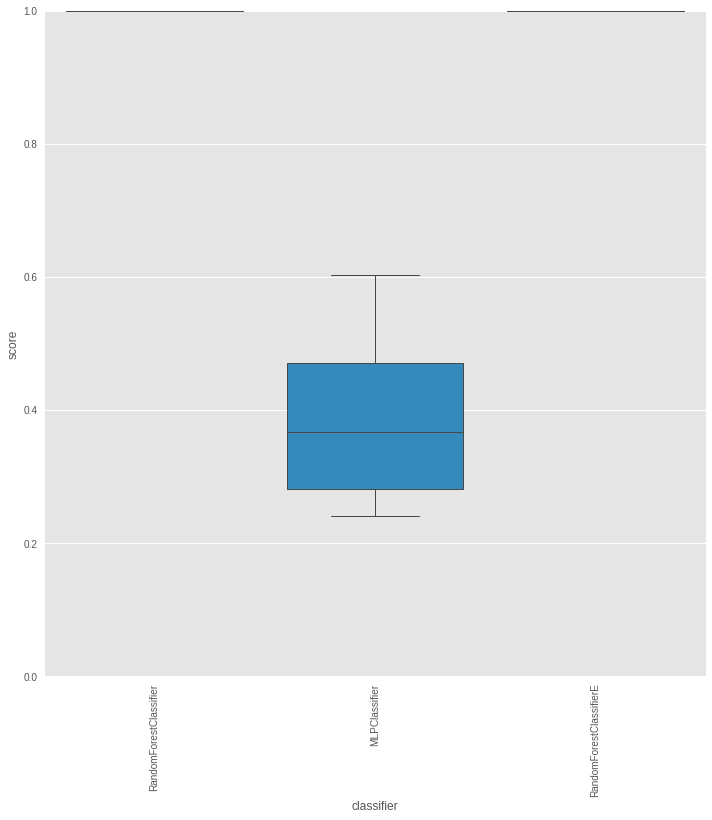

In [57]:
temp = pd.DataFrame(allscores, columns=['classifier', 'score'])
g= sns.factorplot(x='classifier', 
               y="score",
               data=temp, 
               saturation=1, 
               kind="box", 
               ci=None, 
               aspect=1, 
               linewidth=1, 
               size = 10)     
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
g.set(ylim=(0, 1))

### KERAS RNN

In [86]:
x_train.shape

NameError: ignored

In [371]:
y_train.shape

(2938, 20)

In [0]:
input_layer = x_train.shape[1]

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import RNN


model = Sequential()
model.add(Dense(input_layer, input_shape=(input_layer,), activation='softmax'))
model.add(Dense(100, activation='softmax'))
model.add(Dense(20, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=150, batch_size=10, validation_split=0.3)

model.summary()

Train on 2007 samples, validate on 861 samples
Epoch 1/150
2007/2007 [==============================] - 1s 698us/step - loss: 2.9892 - acc: 0.0493 - val_loss: 2.9837 - val_acc: 0.0720
Epoch 2/150
2007/2007 [==============================] - 1s 688us/step - loss: 2.9776 - acc: 0.0762 - val_loss: 2.9753 - val_acc: 0.0720
Epoch 3/150
2007/2007 [==============================] - 1s 689us/step - loss: 2.9666 - acc: 0.0668 - val_loss: 2.9638 - val_acc: 0.0720
Epoch 4/150
2007/2007 [==============================] - 1s 690us/step - loss: 2.9491 - acc: 0.1156 - val_loss: 2.9422 - val_acc: 0.1231
Epoch 5/150
2007/2007 [==============================] - 1s 692us/step - loss: 2.9178 - acc: 0.1276 - val_loss: 2.9024 - val_acc: 0.1231
Epoch 6/150
2007/2007 [==============================] - 1s 704us/step - loss: 2.8668 - acc: 0.1261 - val_loss: 2.8429 - val_acc: 0.1231
Epoch 7/150
2007/2007 [==============================] - 1s 677us/step - loss: 2.7982 - acc: 0.1281 - val_loss: 2.7688 - val_acc: 0

2007/2007 [==============================] - 1s 703us/step - loss: 2.7213 - acc: 0.1281 - val_loss: 2.6932 - val_acc: 0.1231
Epoch 9/150
2007/2007 [==============================] - 1s 699us/step - loss: 2.6465 - acc: 0.1281 - val_loss: 2.6220 - val_acc: 0.1243
Epoch 10/150
2007/2007 [==============================] - 1s 691us/step - loss: 2.5791 - acc: 0.1330 - val_loss: 2.5608 - val_acc: 0.1243
Epoch 11/150
2007/2007 [==============================] - 1s 693us/step - loss: 2.5223 - acc: 0.1330 - val_loss: 2.5085 - val_acc: 0.1301
Epoch 12/150
2007/2007 [==============================] - 1s 673us/step - loss: 2.4750 - acc: 0.1360 - val_loss: 2.4661 - val_acc: 0.1336
Epoch 13/150
2007/2007 [==============================] - 1s 663us/step - loss: 2.4370 - acc: 0.1390 - val_loss: 2.4316 - val_acc: 0.1440
Epoch 14/150
2007/2007 [==============================] - 1s 689us/step - loss: 2.4057 - acc: 0.1440 - val_loss: 2.4028 - val_acc: 0.1452
Epoch 15/150
1230/2007 [=================>......

2007/2007 [==============================] - 1s 680us/step - loss: 2.3790 - acc: 0.1510 - val_loss: 2.3778 - val_acc: 0.1556
Epoch 16/150
2007/2007 [==============================] - 1s 682us/step - loss: 2.3557 - acc: 0.1614 - val_loss: 2.3559 - val_acc: 0.1626
Epoch 17/150
2007/2007 [==============================] - 1s 683us/step - loss: 2.3334 - acc: 0.1814 - val_loss: 2.3329 - val_acc: 0.1789
Epoch 18/150
2007/2007 [==============================] - 1s 685us/step - loss: 2.3105 - acc: 0.1873 - val_loss: 2.3083 - val_acc: 0.1963
Epoch 19/150
2007/2007 [==============================] - 1s 695us/step - loss: 2.2829 - acc: 0.2287 - val_loss: 2.2773 - val_acc: 0.2613
Epoch 20/150
2007/2007 [==============================] - 1s 687us/step - loss: 2.2481 - acc: 0.3024 - val_loss: 2.2395 - val_acc: 0.3031
Epoch 21/150
2007/2007 [==============================] - 1s 704us/step - loss: 2.2053 - acc: 0.3358 - val_loss: 2.1952 - val_acc: 0.3078
Epoch 22/150
1080/2007 [===============>.......

2007/2007 [==============================] - 1s 697us/step - loss: 2.1586 - acc: 0.3428 - val_loss: 2.1511 - val_acc: 0.3020
Epoch 23/150
2007/2007 [==============================] - 1s 700us/step - loss: 2.1116 - acc: 0.3284 - val_loss: 2.1065 - val_acc: 0.2950
Epoch 24/150
2007/2007 [==============================] - 1s 685us/step - loss: 2.0676 - acc: 0.3189 - val_loss: 2.0647 - val_acc: 0.3078
Epoch 25/150
2007/2007 [==============================] - 1s 696us/step - loss: 2.0269 - acc: 0.3463 - val_loss: 2.0270 - val_acc: 0.3124
Epoch 26/150
2007/2007 [==============================] - 1s 709us/step - loss: 1.9896 - acc: 0.3378 - val_loss: 1.9937 - val_acc: 0.3449
Epoch 27/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.9559 - acc: 0.3757 - val_loss: 1.9614 - val_acc: 0.3682
Epoch 28/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.9237 - acc: 0.4061 - val_loss: 1.9321 - val_acc: 0.4239
Epoch 29/150
1140/2007 [================>......

2007/2007 [==============================] - 1s 691us/step - loss: 1.8924 - acc: 0.4669 - val_loss: 1.9019 - val_acc: 0.4472
Epoch 30/150
2007/2007 [==============================] - 1s 684us/step - loss: 1.8618 - acc: 0.4828 - val_loss: 1.8722 - val_acc: 0.4681
Epoch 31/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.8319 - acc: 0.4868 - val_loss: 1.8428 - val_acc: 0.4669
Epoch 32/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.8018 - acc: 0.4973 - val_loss: 1.8141 - val_acc: 0.4611
Epoch 33/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.7728 - acc: 0.5032 - val_loss: 1.7849 - val_acc: 0.4750
Epoch 34/150
2007/2007 [==============================] - 1s 683us/step - loss: 1.7445 - acc: 0.5082 - val_loss: 1.7575 - val_acc: 0.4797
Epoch 35/150
2007/2007 [==============================] - 1s 697us/step - loss: 1.7176 - acc: 0.5252 - val_loss: 1.7311 - val_acc: 0.5145
Epoch 36/150
1330/2007 [==================>....

2007/2007 [==============================] - 1s 698us/step - loss: 1.6920 - acc: 0.5192 - val_loss: 1.7077 - val_acc: 0.4890
Epoch 37/150
2007/2007 [==============================] - 1s 683us/step - loss: 1.6675 - acc: 0.5341 - val_loss: 1.6829 - val_acc: 0.5354
Epoch 38/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.6438 - acc: 0.5501 - val_loss: 1.6597 - val_acc: 0.5343
Epoch 39/150
2007/2007 [==============================] - 1s 713us/step - loss: 1.6216 - acc: 0.5556 - val_loss: 1.6385 - val_acc: 0.5575
Epoch 40/150
2007/2007 [==============================] - 1s 698us/step - loss: 1.6000 - acc: 0.5600 - val_loss: 1.6183 - val_acc: 0.5482
Epoch 41/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.5795 - acc: 0.5805 - val_loss: 1.5980 - val_acc: 0.5366
Epoch 42/150
2007/2007 [==============================] - 1s 703us/step - loss: 1.5592 - acc: 0.5800 - val_loss: 1.5789 - val_acc: 0.5621
Epoch 43/150
1050/2007 [==============>........

2007/2007 [==============================] - 1s 701us/step - loss: 1.5393 - acc: 0.5845 - val_loss: 1.5600 - val_acc: 0.5598
Epoch 44/150
2007/2007 [==============================] - 1s 681us/step - loss: 1.5205 - acc: 0.6049 - val_loss: 1.5417 - val_acc: 0.5621
Epoch 45/150
2007/2007 [==============================] - 1s 678us/step - loss: 1.5014 - acc: 0.6039 - val_loss: 1.5234 - val_acc: 0.5830
Epoch 46/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.4827 - acc: 0.6178 - val_loss: 1.5053 - val_acc: 0.5935
Epoch 47/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.4642 - acc: 0.6273 - val_loss: 1.4882 - val_acc: 0.6028
Epoch 48/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.4460 - acc: 0.6328 - val_loss: 1.4707 - val_acc: 0.6132
Epoch 49/150
2007/2007 [==============================] - 1s 686us/step - loss: 1.4283 - acc: 0.6403 - val_loss: 1.4544 - val_acc: 0.6492
Epoch 50/150
1350/2007 [===================>...

2007/2007 [==============================] - 1s 680us/step - loss: 1.4113 - acc: 0.6542 - val_loss: 1.4378 - val_acc: 0.6051
Epoch 51/150
2007/2007 [==============================] - 1s 701us/step - loss: 1.3944 - acc: 0.6552 - val_loss: 1.4213 - val_acc: 0.6504
Epoch 52/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.3780 - acc: 0.6647 - val_loss: 1.4071 - val_acc: 0.6434
Epoch 53/150
2007/2007 [==============================] - 1s 698us/step - loss: 1.3623 - acc: 0.6781 - val_loss: 1.3924 - val_acc: 0.6620
Epoch 54/150
2007/2007 [==============================] - 1s 702us/step - loss: 1.3467 - acc: 0.6846 - val_loss: 1.3784 - val_acc: 0.6469
Epoch 55/150
2007/2007 [==============================] - 1s 692us/step - loss: 1.3314 - acc: 0.6996 - val_loss: 1.3644 - val_acc: 0.6609
Epoch 56/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.3162 - acc: 0.7000 - val_loss: 1.3510 - val_acc: 0.6864
Epoch 57/150
1140/2007 [================>......

2007/2007 [==============================] - 1s 701us/step - loss: 1.3014 - acc: 0.7100 - val_loss: 1.3372 - val_acc: 0.6574
Epoch 58/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.2863 - acc: 0.7125 - val_loss: 1.3253 - val_acc: 0.6469
Epoch 59/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.2714 - acc: 0.7215 - val_loss: 1.3108 - val_acc: 0.6899
Epoch 60/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.2567 - acc: 0.7235 - val_loss: 1.2997 - val_acc: 0.7108
Epoch 61/150
2007/2007 [==============================] - 1s 707us/step - loss: 1.2422 - acc: 0.7280 - val_loss: 1.2845 - val_acc: 0.6841
Epoch 62/150
2007/2007 [==============================] - 1s 684us/step - loss: 1.2278 - acc: 0.7329 - val_loss: 1.2705 - val_acc: 0.6957
Epoch 63/150
2007/2007 [==============================] - 1s 661us/step - loss: 1.2137 - acc: 0.7294 - val_loss: 1.2576 - val_acc: 0.6852
Epoch 64/150
1230/2007 [=================>.....

2007/2007 [==============================] - 1s 684us/step - loss: 1.2001 - acc: 0.7349 - val_loss: 1.2462 - val_acc: 0.7131
Epoch 65/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.1865 - acc: 0.7304 - val_loss: 1.2337 - val_acc: 0.7003
Epoch 66/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.1736 - acc: 0.7404 - val_loss: 1.2215 - val_acc: 0.7015
Epoch 67/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.1602 - acc: 0.7389 - val_loss: 1.2106 - val_acc: 0.6748
Epoch 68/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.1483 - acc: 0.7434 - val_loss: 1.1994 - val_acc: 0.7062
Epoch 69/150
2007/2007 [==============================] - 1s 691us/step - loss: 1.1364 - acc: 0.7419 - val_loss: 1.1886 - val_acc: 0.7073
Epoch 70/150
2007/2007 [==============================] - 1s 680us/step - loss: 1.1247 - acc: 0.7404 - val_loss: 1.1774 - val_acc: 0.7213
Epoch 71/150
1320/2007 [==================>....

2007/2007 [==============================] - 1s 699us/step - loss: 1.1129 - acc: 0.7474 - val_loss: 1.1665 - val_acc: 0.7120
Epoch 72/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.1014 - acc: 0.7449 - val_loss: 1.1552 - val_acc: 0.7050
Epoch 73/150
2007/2007 [==============================] - 1s 697us/step - loss: 1.0904 - acc: 0.7509 - val_loss: 1.1454 - val_acc: 0.6934
Epoch 74/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.0797 - acc: 0.7489 - val_loss: 1.1352 - val_acc: 0.7154
Epoch 75/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.0689 - acc: 0.7504 - val_loss: 1.1245 - val_acc: 0.6806
Epoch 76/150
2007/2007 [==============================] - 1s 717us/step - loss: 1.0585 - acc: 0.7484 - val_loss: 1.1131 - val_acc: 0.7050
Epoch 77/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.0481 - acc: 0.7464 - val_loss: 1.1016 - val_acc: 0.7027
Epoch 78/150
1220/2007 [=================>.....

2007/2007 [==============================] - 1s 709us/step - loss: 1.0376 - acc: 0.7519 - val_loss: 1.0921 - val_acc: 0.7201
Epoch 79/150
2007/2007 [==============================] - 1s 696us/step - loss: 1.0270 - acc: 0.7539 - val_loss: 1.0807 - val_acc: 0.7178
Epoch 80/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.0164 - acc: 0.7509 - val_loss: 1.0708 - val_acc: 0.6911
Epoch 81/150
2007/2007 [==============================] - 1s 676us/step - loss: 1.0056 - acc: 0.7484 - val_loss: 1.0589 - val_acc: 0.7178
Epoch 82/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.9953 - acc: 0.7559 - val_loss: 1.0483 - val_acc: 0.7154
Epoch 83/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.9856 - acc: 0.7573 - val_loss: 1.0413 - val_acc: 0.6841
Epoch 84/150
2007/2007 [==============================] - 1s 674us/step - loss: 0.9759 - acc: 0.7608 - val_loss: 1.0307 - val_acc: 0.7271
Epoch 85/150
1140/2007 [================>......

2007/2007 [==============================] - 1s 683us/step - loss: 0.9667 - acc: 0.7613 - val_loss: 1.0210 - val_acc: 0.7247
Epoch 86/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.9576 - acc: 0.7643 - val_loss: 1.0113 - val_acc: 0.7282
Epoch 87/150
2007/2007 [==============================] - 1s 710us/step - loss: 0.9486 - acc: 0.7658 - val_loss: 1.0048 - val_acc: 0.7038
Epoch 88/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.9402 - acc: 0.7663 - val_loss: 0.9964 - val_acc: 0.7375
Epoch 89/150
2007/2007 [==============================] - 1s 692us/step - loss: 0.9322 - acc: 0.7678 - val_loss: 0.9871 - val_acc: 0.7247
Epoch 90/150
2007/2007 [==============================] - 1s 695us/step - loss: 0.9236 - acc: 0.7713 - val_loss: 0.9824 - val_acc: 0.6992
Epoch 91/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.9155 - acc: 0.7703 - val_loss: 0.9704 - val_acc: 0.7317
Epoch 92/150
1230/2007 [=================>.....

2007/2007 [==============================] - 1s 691us/step - loss: 0.9075 - acc: 0.7683 - val_loss: 0.9622 - val_acc: 0.7236
Epoch 93/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.8999 - acc: 0.7748 - val_loss: 0.9539 - val_acc: 0.7317
Epoch 94/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.8923 - acc: 0.7753 - val_loss: 0.9473 - val_acc: 0.7329
Epoch 95/150
2007/2007 [==============================] - 1s 710us/step - loss: 0.8846 - acc: 0.7803 - val_loss: 0.9390 - val_acc: 0.7352
Epoch 96/150
2007/2007 [==============================] - 1s 697us/step - loss: 0.8770 - acc: 0.7783 - val_loss: 0.9324 - val_acc: 0.7387
Epoch 97/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.8698 - acc: 0.7828 - val_loss: 0.9248 - val_acc: 0.7398
Epoch 98/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.8623 - acc: 0.7823 - val_loss: 0.9172 - val_acc: 0.7433
Epoch 99/150
1040/2007 [==============>........

2007/2007 [==============================] - 1s 697us/step - loss: 0.8551 - acc: 0.7942 - val_loss: 0.9082 - val_acc: 0.7468
Epoch 100/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.8482 - acc: 0.7902 - val_loss: 0.9027 - val_acc: 0.7480
Epoch 101/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.8414 - acc: 0.8007 - val_loss: 0.8958 - val_acc: 0.7538
Epoch 102/150
2007/2007 [==============================] - 1s 692us/step - loss: 0.8346 - acc: 0.8072 - val_loss: 0.8894 - val_acc: 0.7561
Epoch 103/150
2007/2007 [==============================] - 1s 701us/step - loss: 0.8276 - acc: 0.8047 - val_loss: 0.8818 - val_acc: 0.7898
Epoch 104/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.8214 - acc: 0.8151 - val_loss: 0.8764 - val_acc: 0.8386
Epoch 105/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.8151 - acc: 0.8430 - val_loss: 0.8724 - val_acc: 0.8420
Epoch 106/150
1160/2007 [================

2007/2007 [==============================] - 1s 685us/step - loss: 0.8088 - acc: 0.8625 - val_loss: 0.8638 - val_acc: 0.8362
Epoch 107/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.8023 - acc: 0.8555 - val_loss: 0.8591 - val_acc: 0.8548
Epoch 108/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.7963 - acc: 0.8665 - val_loss: 0.8530 - val_acc: 0.8513
Epoch 109/150
2007/2007 [==============================] - 1s 673us/step - loss: 0.7899 - acc: 0.8650 - val_loss: 0.8446 - val_acc: 0.8293
Epoch 110/150
2007/2007 [==============================] - 1s 697us/step - loss: 0.7840 - acc: 0.8705 - val_loss: 0.8397 - val_acc: 0.8537
Epoch 111/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.7779 - acc: 0.8665 - val_loss: 0.8370 - val_acc: 0.8002
Epoch 112/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.7721 - acc: 0.8695 - val_loss: 0.8271 - val_acc: 0.8502
Epoch 113/150
1170/2007 [================

2007/2007 [==============================] - 1s 694us/step - loss: 0.7661 - acc: 0.8719 - val_loss: 0.8207 - val_acc: 0.8374
Epoch 114/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.7602 - acc: 0.8670 - val_loss: 0.8160 - val_acc: 0.8374
Epoch 115/150
2007/2007 [==============================] - 1s 694us/step - loss: 0.7539 - acc: 0.8744 - val_loss: 0.8086 - val_acc: 0.8467
Epoch 116/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.7485 - acc: 0.8789 - val_loss: 0.8050 - val_acc: 0.8839
Epoch 117/150
2007/2007 [==============================] - 1s 670us/step - loss: 0.7429 - acc: 0.8774 - val_loss: 0.8018 - val_acc: 0.8839
Epoch 118/150
2007/2007 [==============================] - 1s 694us/step - loss: 0.7373 - acc: 0.8824 - val_loss: 0.7979 - val_acc: 0.8026
Epoch 119/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.7316 - acc: 0.8829 - val_loss: 0.7869 - val_acc: 0.8722
Epoch 120/150
1260/2007 [================

2007/2007 [==============================] - 1s 669us/step - loss: 0.7260 - acc: 0.8804 - val_loss: 0.7819 - val_acc: 0.8351
Epoch 121/150
2007/2007 [==============================] - 1s 693us/step - loss: 0.7202 - acc: 0.8779 - val_loss: 0.7774 - val_acc: 0.8328
Epoch 122/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.7145 - acc: 0.8804 - val_loss: 0.7739 - val_acc: 0.8839
Epoch 123/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.7090 - acc: 0.8799 - val_loss: 0.7648 - val_acc: 0.8374
Epoch 124/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.7033 - acc: 0.8789 - val_loss: 0.7609 - val_acc: 0.8316
Epoch 125/150
2007/2007 [==============================] - 1s 676us/step - loss: 0.6980 - acc: 0.8854 - val_loss: 0.7535 - val_acc: 0.8653
Epoch 126/150
2007/2007 [==============================] - 1s 706us/step - loss: 0.6925 - acc: 0.8844 - val_loss: 0.7511 - val_acc: 0.8281
Epoch 127/150
1130/2007 [===============>

2007/2007 [==============================] - 1s 686us/step - loss: 0.6872 - acc: 0.8854 - val_loss: 0.7432 - val_acc: 0.8618
Epoch 128/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.6815 - acc: 0.8874 - val_loss: 0.7401 - val_acc: 0.8804
Epoch 129/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.6758 - acc: 0.8804 - val_loss: 0.7334 - val_acc: 0.8386
Epoch 130/150
2007/2007 [==============================] - 1s 668us/step - loss: 0.6706 - acc: 0.8849 - val_loss: 0.7264 - val_acc: 0.8606
Epoch 131/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.6652 - acc: 0.8824 - val_loss: 0.7221 - val_acc: 0.8618
Epoch 132/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.6597 - acc: 0.8779 - val_loss: 0.7149 - val_acc: 0.8525
Epoch 133/150
2007/2007 [==============================] - 1s 690us/step - loss: 0.6541 - acc: 0.8839 - val_loss: 0.7086 - val_acc: 0.8537
Epoch 134/150
1210/2007 [================

2007/2007 [==============================] - 1s 701us/step - loss: 0.6491 - acc: 0.8809 - val_loss: 0.7065 - val_acc: 0.8316
Epoch 135/150
2007/2007 [==============================] - 1s 706us/step - loss: 0.6437 - acc: 0.8834 - val_loss: 0.6985 - val_acc: 0.8606
Epoch 136/150
2007/2007 [==============================] - 1s 681us/step - loss: 0.6383 - acc: 0.8859 - val_loss: 0.6937 - val_acc: 0.8537
Epoch 137/150
2007/2007 [==============================] - 1s 675us/step - loss: 0.6329 - acc: 0.8859 - val_loss: 0.6879 - val_acc: 0.8711
Epoch 138/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.6275 - acc: 0.8884 - val_loss: 0.6822 - val_acc: 0.8792
Epoch 139/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.6223 - acc: 0.8819 - val_loss: 0.6774 - val_acc: 0.8804
Epoch 140/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.6170 - acc: 0.8864 - val_loss: 0.6747 - val_acc: 0.8328
Epoch 141/150
1230/2007 [================

2007/2007 [==============================] - 1s 692us/step - loss: 0.6118 - acc: 0.8874 - val_loss: 0.6669 - val_acc: 0.8583
Epoch 142/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.6060 - acc: 0.8879 - val_loss: 0.6614 - val_acc: 0.8432
Epoch 143/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.6015 - acc: 0.8864 - val_loss: 0.6550 - val_acc: 0.8513
Epoch 144/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.5965 - acc: 0.8899 - val_loss: 0.6584 - val_acc: 0.8107
Epoch 145/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.5911 - acc: 0.8874 - val_loss: 0.6453 - val_acc: 0.8595
Epoch 146/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.5868 - acc: 0.8894 - val_loss: 0.6390 - val_acc: 0.8664
Epoch 147/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.5816 - acc: 0.8904 - val_loss: 0.6364 - val_acc: 0.8850
Epoch 148/150
1320/2007 [================

2007/2007 [==============================] - 1s 689us/step - loss: 0.5767 - acc: 0.8894 - val_loss: 0.6309 - val_acc: 0.8699
Epoch 149/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.5714 - acc: 0.8924 - val_loss: 0.6271 - val_acc: 0.8537
Epoch 150/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.5669 - acc: 0.8919 - val_loss: 0.6253 - val_acc: 0.8815
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 266)               71022     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               26700     
_________________________________________________________________
dense_15 (Dense)             (None, 20)                2020      
Total params: 99,742
Trainable params: 99,742
Non-trainable params: 0
_________________________________________________________________

In [119]:
model2 = Sequential()
model2.add(Dense(input_layer, input_shape=(input_layer,), activation='softmax'))
model2.add(Dense(50, activation='softmax'))
model2.add(Dense(20, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model2.fit(x_train, y_train, epochs=150, batch_size=10, validation_split=0.3)

model2.summary()

Train on 2007 samples, validate on 861 samples
Epoch 1/150
2007/2007 [==============================] - 1s 743us/step - loss: 2.9900 - acc: 0.0583 - val_loss: 2.9848 - val_acc: 0.0511
Epoch 2/150
2007/2007 [==============================] - 1s 686us/step - loss: 2.9772 - acc: 0.0932 - val_loss: 2.9750 - val_acc: 0.1231
Epoch 3/150
2007/2007 [==============================] - 1s 712us/step - loss: 2.9650 - acc: 0.1006 - val_loss: 2.9621 - val_acc: 0.1231
Epoch 4/150
2007/2007 [==============================] - 1s 688us/step - loss: 2.9465 - acc: 0.1281 - val_loss: 2.9399 - val_acc: 0.1231
Epoch 5/150
2007/2007 [==============================] - 1s 709us/step - loss: 2.9156 - acc: 0.1281 - val_loss: 2.9010 - val_acc: 0.1231
Epoch 6/150
2007/2007 [==============================] - 1s 699us/step - loss: 2.8660 - acc: 0.1281 - val_loss: 2.8430 - val_acc: 0.1231
Epoch 7/150
2007/2007 [==============================] - 1s 679us/step - loss: 2.7997 - acc: 0.1281 - val_loss: 2.7720 - val_acc: 0

2007/2007 [==============================] - 1s 679us/step - loss: 2.7238 - acc: 0.1281 - val_loss: 2.6963 - val_acc: 0.1231
Epoch 9/150
2007/2007 [==============================] - 1s 677us/step - loss: 2.6489 - acc: 0.1315 - val_loss: 2.6260 - val_acc: 0.1243
Epoch 10/150
2007/2007 [==============================] - 1s 682us/step - loss: 2.5820 - acc: 0.1365 - val_loss: 2.5656 - val_acc: 0.1336
Epoch 11/150
2007/2007 [==============================] - 1s 687us/step - loss: 2.5251 - acc: 0.1420 - val_loss: 2.5142 - val_acc: 0.1382
Epoch 12/150
2007/2007 [==============================] - 1s 688us/step - loss: 2.4778 - acc: 0.1495 - val_loss: 2.4722 - val_acc: 0.1452
Epoch 13/150
2007/2007 [==============================] - 1s 698us/step - loss: 2.4391 - acc: 0.1545 - val_loss: 2.4373 - val_acc: 0.1475
Epoch 14/150
2007/2007 [==============================] - 1s 680us/step - loss: 2.4074 - acc: 0.1604 - val_loss: 2.4084 - val_acc: 0.1545
Epoch 15/150
1230/2007 [=================>......

2007/2007 [==============================] - 1s 700us/step - loss: 2.3804 - acc: 0.1679 - val_loss: 2.3832 - val_acc: 0.1614
Epoch 16/150
2007/2007 [==============================] - 1s 689us/step - loss: 2.3570 - acc: 0.1749 - val_loss: 2.3608 - val_acc: 0.1661
Epoch 17/150
2007/2007 [==============================] - 1s 674us/step - loss: 2.3352 - acc: 0.1789 - val_loss: 2.3395 - val_acc: 0.1835
Epoch 18/150
2007/2007 [==============================] - 1s 695us/step - loss: 2.3133 - acc: 0.1883 - val_loss: 2.3162 - val_acc: 0.2021
Epoch 19/150
2007/2007 [==============================] - 1s 708us/step - loss: 2.2889 - acc: 0.2177 - val_loss: 2.2900 - val_acc: 0.2427
Epoch 20/150
2007/2007 [==============================] - 1s 694us/step - loss: 2.2602 - acc: 0.2765 - val_loss: 2.2592 - val_acc: 0.2613
Epoch 21/150
2007/2007 [==============================] - 1s 689us/step - loss: 2.2260 - acc: 0.2785 - val_loss: 2.2241 - val_acc: 0.2799
Epoch 22/150
1230/2007 [=================>.....

2007/2007 [==============================] - 1s 702us/step - loss: 2.1868 - acc: 0.2975 - val_loss: 2.1848 - val_acc: 0.2846
Epoch 23/150
2007/2007 [==============================] - 1s 678us/step - loss: 2.1451 - acc: 0.2845 - val_loss: 2.1446 - val_acc: 0.2718
Epoch 24/150
2007/2007 [==============================] - 1s 710us/step - loss: 2.1036 - acc: 0.2790 - val_loss: 2.1064 - val_acc: 0.2648
Epoch 25/150
2007/2007 [==============================] - 1s 707us/step - loss: 2.0637 - acc: 0.3109 - val_loss: 2.0682 - val_acc: 0.3078
Epoch 26/150
2007/2007 [==============================] - 1s 698us/step - loss: 2.0266 - acc: 0.3129 - val_loss: 2.0334 - val_acc: 0.3101
Epoch 27/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.9923 - acc: 0.3293 - val_loss: 2.0019 - val_acc: 0.3240
Epoch 28/150
2007/2007 [==============================] - 1s 711us/step - loss: 1.9606 - acc: 0.3468 - val_loss: 1.9728 - val_acc: 0.3438
Epoch 29/150
 980/2007 [=============>.........

2007/2007 [==============================] - 1s 701us/step - loss: 1.9307 - acc: 0.3752 - val_loss: 1.9451 - val_acc: 0.3496
Epoch 30/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.9024 - acc: 0.3787 - val_loss: 1.9193 - val_acc: 0.3856
Epoch 31/150
2007/2007 [==============================] - 1s 678us/step - loss: 1.8752 - acc: 0.4066 - val_loss: 1.8931 - val_acc: 0.3728
Epoch 32/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.8486 - acc: 0.4215 - val_loss: 1.8682 - val_acc: 0.3879
Epoch 33/150
2007/2007 [==============================] - 1s 705us/step - loss: 1.8227 - acc: 0.4380 - val_loss: 1.8429 - val_acc: 0.4111
Epoch 34/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.7974 - acc: 0.4564 - val_loss: 1.8189 - val_acc: 0.4379
Epoch 35/150
2007/2007 [==============================] - 1s 709us/step - loss: 1.7728 - acc: 0.4788 - val_loss: 1.7950 - val_acc: 0.4483
Epoch 36/150
 950/2007 [=============>.........

2007/2007 [==============================] - 1s 718us/step - loss: 1.7494 - acc: 0.4868 - val_loss: 1.7731 - val_acc: 0.4379
Epoch 37/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.7267 - acc: 0.4983 - val_loss: 1.7498 - val_acc: 0.4669
Epoch 38/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.7048 - acc: 0.5107 - val_loss: 1.7288 - val_acc: 0.4866
Epoch 39/150
2007/2007 [==============================] - 1s 710us/step - loss: 1.6842 - acc: 0.5012 - val_loss: 1.7086 - val_acc: 0.5017
Epoch 40/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.6644 - acc: 0.5316 - val_loss: 1.6888 - val_acc: 0.5075
Epoch 41/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.6457 - acc: 0.5501 - val_loss: 1.6735 - val_acc: 0.5319
Epoch 42/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.6277 - acc: 0.5526 - val_loss: 1.6562 - val_acc: 0.5482
Epoch 43/150
 980/2007 [=============>.........

2007/2007 [==============================] - 1s 688us/step - loss: 1.6110 - acc: 0.5575 - val_loss: 1.6365 - val_acc: 0.5447
Epoch 44/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.5950 - acc: 0.5730 - val_loss: 1.6212 - val_acc: 0.5238
Epoch 45/150
2007/2007 [==============================] - 1s 684us/step - loss: 1.5800 - acc: 0.5715 - val_loss: 1.6072 - val_acc: 0.5528
Epoch 46/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.5654 - acc: 0.5755 - val_loss: 1.5925 - val_acc: 0.5192
Epoch 47/150
2007/2007 [==============================] - 1s 683us/step - loss: 1.5518 - acc: 0.5755 - val_loss: 1.5795 - val_acc: 0.5285
Epoch 48/150
2007/2007 [==============================] - 1s 730us/step - loss: 1.5387 - acc: 0.5675 - val_loss: 1.5675 - val_acc: 0.5598
Epoch 49/150
2007/2007 [==============================] - 1s 681us/step - loss: 1.5259 - acc: 0.5825 - val_loss: 1.5549 - val_acc: 0.5389
Epoch 50/150
 980/2007 [=============>.........

2007/2007 [==============================] - 1s 685us/step - loss: 1.5132 - acc: 0.5840 - val_loss: 1.5421 - val_acc: 0.5528
Epoch 51/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.5006 - acc: 0.5944 - val_loss: 1.5310 - val_acc: 0.5877
Epoch 52/150
2007/2007 [==============================] - 1s 707us/step - loss: 1.4878 - acc: 0.6059 - val_loss: 1.5204 - val_acc: 0.6005
Epoch 53/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.4752 - acc: 0.6183 - val_loss: 1.5075 - val_acc: 0.5470
Epoch 54/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.4628 - acc: 0.6084 - val_loss: 1.4937 - val_acc: 0.5830
Epoch 55/150
2007/2007 [==============================] - 1s 679us/step - loss: 1.4493 - acc: 0.6253 - val_loss: 1.4831 - val_acc: 0.5575
Epoch 56/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.4361 - acc: 0.6338 - val_loss: 1.4685 - val_acc: 0.5738
Epoch 57/150
1190/2007 [================>......

2007/2007 [==============================] - 1s 695us/step - loss: 1.4224 - acc: 0.6373 - val_loss: 1.4547 - val_acc: 0.6225
Epoch 58/150
2007/2007 [==============================] - 1s 703us/step - loss: 1.4083 - acc: 0.6403 - val_loss: 1.4400 - val_acc: 0.6005
Epoch 59/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.3937 - acc: 0.6413 - val_loss: 1.4261 - val_acc: 0.6249
Epoch 60/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.3789 - acc: 0.6552 - val_loss: 1.4107 - val_acc: 0.6202
Epoch 61/150
2007/2007 [==============================] - 1s 713us/step - loss: 1.3633 - acc: 0.6721 - val_loss: 1.3969 - val_acc: 0.6051
Epoch 62/150
2007/2007 [==============================] - 1s 703us/step - loss: 1.3473 - acc: 0.6811 - val_loss: 1.3806 - val_acc: 0.6318
Epoch 63/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.3312 - acc: 0.6921 - val_loss: 1.3644 - val_acc: 0.6492
Epoch 64/150
1140/2007 [================>......

2007/2007 [==============================] - 1s 692us/step - loss: 1.3145 - acc: 0.7030 - val_loss: 1.3500 - val_acc: 0.6144
Epoch 65/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.2982 - acc: 0.6956 - val_loss: 1.3337 - val_acc: 0.6481
Epoch 66/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.2820 - acc: 0.7090 - val_loss: 1.3185 - val_acc: 0.6771
Epoch 67/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.2662 - acc: 0.7080 - val_loss: 1.3055 - val_acc: 0.6969
Epoch 68/150
2007/2007 [==============================] - 1s 681us/step - loss: 1.2516 - acc: 0.7120 - val_loss: 1.2915 - val_acc: 0.6504
Epoch 69/150
2007/2007 [==============================] - 1s 683us/step - loss: 1.2375 - acc: 0.7165 - val_loss: 1.2808 - val_acc: 0.7050
Epoch 70/150
2007/2007 [==============================] - 1s 671us/step - loss: 1.2238 - acc: 0.7150 - val_loss: 1.2664 - val_acc: 0.6922
Epoch 71/150
1360/2007 [===================>...

2007/2007 [==============================] - 1s 681us/step - loss: 1.2106 - acc: 0.7230 - val_loss: 1.2557 - val_acc: 0.6841
Epoch 72/150
2007/2007 [==============================] - 1s 684us/step - loss: 1.1982 - acc: 0.7255 - val_loss: 1.2443 - val_acc: 0.6945
Epoch 73/150
2007/2007 [==============================] - 1s 692us/step - loss: 1.1858 - acc: 0.7265 - val_loss: 1.2333 - val_acc: 0.6713
Epoch 74/150
2007/2007 [==============================] - 1s 667us/step - loss: 1.1740 - acc: 0.7270 - val_loss: 1.2226 - val_acc: 0.7015
Epoch 75/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.1621 - acc: 0.7304 - val_loss: 1.2142 - val_acc: 0.7120
Epoch 76/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.1505 - acc: 0.7364 - val_loss: 1.2028 - val_acc: 0.7085
Epoch 77/150
2007/2007 [==============================] - 1s 683us/step - loss: 1.1392 - acc: 0.7424 - val_loss: 1.1947 - val_acc: 0.7201
Epoch 78/150
1230/2007 [=================>.....

2007/2007 [==============================] - 1s 680us/step - loss: 1.1290 - acc: 0.7424 - val_loss: 1.1833 - val_acc: 0.6934
Epoch 79/150
2007/2007 [==============================] - 1s 697us/step - loss: 1.1184 - acc: 0.7419 - val_loss: 1.1745 - val_acc: 0.7003
Epoch 80/150
2007/2007 [==============================] - 1s 684us/step - loss: 1.1083 - acc: 0.7459 - val_loss: 1.1647 - val_acc: 0.6980
Epoch 81/150
2007/2007 [==============================] - 1s 686us/step - loss: 1.0988 - acc: 0.7469 - val_loss: 1.1564 - val_acc: 0.7154
Epoch 82/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.0887 - acc: 0.7524 - val_loss: 1.1478 - val_acc: 0.7073
Epoch 83/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.0797 - acc: 0.7459 - val_loss: 1.1398 - val_acc: 0.6922
Epoch 84/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.0710 - acc: 0.7474 - val_loss: 1.1324 - val_acc: 0.6771
Epoch 85/150
1340/2007 [===================>...

2007/2007 [==============================] - 1s 676us/step - loss: 1.0621 - acc: 0.7519 - val_loss: 1.1223 - val_acc: 0.7120
Epoch 86/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.0533 - acc: 0.7544 - val_loss: 1.1138 - val_acc: 0.6969
Epoch 87/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.0449 - acc: 0.7504 - val_loss: 1.1059 - val_acc: 0.7108
Epoch 88/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.0366 - acc: 0.7564 - val_loss: 1.1011 - val_acc: 0.7247
Epoch 89/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.0283 - acc: 0.7524 - val_loss: 1.1014 - val_acc: 0.7247
Epoch 90/150
2007/2007 [==============================] - 1s 680us/step - loss: 1.0202 - acc: 0.7559 - val_loss: 1.0814 - val_acc: 0.7154
Epoch 91/150
2007/2007 [==============================] - 1s 691us/step - loss: 1.0120 - acc: 0.7539 - val_loss: 1.0726 - val_acc: 0.7003
Epoch 92/150
1310/2007 [==================>....

2007/2007 [==============================] - 1s 701us/step - loss: 1.0035 - acc: 0.7534 - val_loss: 1.0639 - val_acc: 0.7131
Epoch 93/150
2007/2007 [==============================] - 1s 690us/step - loss: 0.9955 - acc: 0.7559 - val_loss: 1.0543 - val_acc: 0.7050
Epoch 94/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.9867 - acc: 0.7539 - val_loss: 1.0463 - val_acc: 0.7015
Epoch 95/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.9782 - acc: 0.7559 - val_loss: 1.0421 - val_acc: 0.7305
Epoch 96/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.9692 - acc: 0.7559 - val_loss: 1.0293 - val_acc: 0.7224
Epoch 97/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.9601 - acc: 0.7603 - val_loss: 1.0204 - val_acc: 0.7213
Epoch 98/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.9512 - acc: 0.7623 - val_loss: 1.0178 - val_acc: 0.6678
Epoch 99/150
1310/2007 [==================>....

2007/2007 [==============================] - 1s 685us/step - loss: 0.9434 - acc: 0.7643 - val_loss: 1.0029 - val_acc: 0.7178
Epoch 100/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.9357 - acc: 0.7758 - val_loss: 0.9951 - val_acc: 0.7178
Epoch 101/150
2007/2007 [==============================] - 1s 702us/step - loss: 0.9286 - acc: 0.7753 - val_loss: 0.9886 - val_acc: 0.7282
Epoch 102/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.9219 - acc: 0.7773 - val_loss: 0.9824 - val_acc: 0.7120
Epoch 103/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.9150 - acc: 0.7738 - val_loss: 0.9756 - val_acc: 0.7433
Epoch 104/150
2007/2007 [==============================] - 1s 671us/step - loss: 0.9083 - acc: 0.7733 - val_loss: 0.9681 - val_acc: 0.7282
Epoch 105/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.9014 - acc: 0.7748 - val_loss: 0.9639 - val_acc: 0.7456
Epoch 106/150
1140/2007 [================

2007/2007 [==============================] - 1s 694us/step - loss: 0.8945 - acc: 0.7838 - val_loss: 0.9562 - val_acc: 0.7189
Epoch 107/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.8882 - acc: 0.7828 - val_loss: 0.9494 - val_acc: 0.7201
Epoch 108/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.8819 - acc: 0.7818 - val_loss: 0.9428 - val_acc: 0.7213
Epoch 109/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.8752 - acc: 0.7808 - val_loss: 0.9388 - val_acc: 0.7108
Epoch 110/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.8689 - acc: 0.7843 - val_loss: 0.9318 - val_acc: 0.7189
Epoch 111/150
2007/2007 [==============================] - 1s 676us/step - loss: 0.8625 - acc: 0.7813 - val_loss: 0.9259 - val_acc: 0.7468
Epoch 112/150
2007/2007 [==============================] - 1s 679us/step - loss: 0.8565 - acc: 0.7828 - val_loss: 0.9224 - val_acc: 0.7642
Epoch 113/150
1130/2007 [===============>

2007/2007 [==============================] - 1s 705us/step - loss: 0.8498 - acc: 0.7877 - val_loss: 0.9126 - val_acc: 0.7317
Epoch 114/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.8436 - acc: 0.7922 - val_loss: 0.9070 - val_acc: 0.7480
Epoch 115/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.8375 - acc: 0.7867 - val_loss: 0.9015 - val_acc: 0.7294
Epoch 116/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.8311 - acc: 0.7982 - val_loss: 0.8971 - val_acc: 0.7131
Epoch 117/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.8243 - acc: 0.7917 - val_loss: 0.8893 - val_acc: 0.7538
Epoch 118/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.8181 - acc: 0.8246 - val_loss: 0.8842 - val_acc: 0.7271
Epoch 119/150
2007/2007 [==============================] - 1s 690us/step - loss: 0.8120 - acc: 0.8122 - val_loss: 0.8775 - val_acc: 0.7967
Epoch 120/150
1210/2007 [================

2007/2007 [==============================] - 1s 684us/step - loss: 0.8057 - acc: 0.8530 - val_loss: 0.8722 - val_acc: 0.7375
Epoch 121/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.8004 - acc: 0.8171 - val_loss: 0.8665 - val_acc: 0.7654
Epoch 122/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.7945 - acc: 0.8500 - val_loss: 0.8638 - val_acc: 0.8188
Epoch 123/150
2007/2007 [==============================] - 1s 692us/step - loss: 0.7893 - acc: 0.8535 - val_loss: 0.8537 - val_acc: 0.8107
Epoch 124/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.7835 - acc: 0.8500 - val_loss: 0.8500 - val_acc: 0.8328
Epoch 125/150
2007/2007 [==============================] - 1s 683us/step - loss: 0.7782 - acc: 0.8470 - val_loss: 0.8433 - val_acc: 0.8072
Epoch 126/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.7733 - acc: 0.8600 - val_loss: 0.8386 - val_acc: 0.8177
Epoch 127/150
1150/2007 [================

2007/2007 [==============================] - 1s 694us/step - loss: 0.7677 - acc: 0.8620 - val_loss: 0.8371 - val_acc: 0.8037
Epoch 128/150
2007/2007 [==============================] - 1s 680us/step - loss: 0.7628 - acc: 0.8660 - val_loss: 0.8286 - val_acc: 0.8269
Epoch 129/150
2007/2007 [==============================] - 1s 701us/step - loss: 0.7574 - acc: 0.8685 - val_loss: 0.8301 - val_acc: 0.8479
Epoch 130/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.7522 - acc: 0.8700 - val_loss: 0.8204 - val_acc: 0.8293
Epoch 131/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.7474 - acc: 0.8700 - val_loss: 0.8135 - val_acc: 0.8374
Epoch 132/150
2007/2007 [==============================] - 1s 695us/step - loss: 0.7422 - acc: 0.8700 - val_loss: 0.8112 - val_acc: 0.8467
Epoch 133/150
2007/2007 [==============================] - 1s 690us/step - loss: 0.7374 - acc: 0.8744 - val_loss: 0.8064 - val_acc: 0.8258
Epoch 134/150
1160/2007 [================

2007/2007 [==============================] - 1s 688us/step - loss: 0.7326 - acc: 0.8729 - val_loss: 0.7977 - val_acc: 0.8490
Epoch 135/150
2007/2007 [==============================] - 1s 710us/step - loss: 0.7275 - acc: 0.8739 - val_loss: 0.7961 - val_acc: 0.8444
Epoch 136/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.7231 - acc: 0.8779 - val_loss: 0.7901 - val_acc: 0.8537
Epoch 137/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.7187 - acc: 0.8764 - val_loss: 0.7849 - val_acc: 0.8490
Epoch 138/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.7137 - acc: 0.8784 - val_loss: 0.7807 - val_acc: 0.8386
Epoch 139/150
2007/2007 [==============================] - 1s 705us/step - loss: 0.7097 - acc: 0.8729 - val_loss: 0.7755 - val_acc: 0.8490
Epoch 140/150
2007/2007 [==============================] - 1s 679us/step - loss: 0.7050 - acc: 0.8789 - val_loss: 0.7728 - val_acc: 0.8606
Epoch 141/150
1050/2007 [==============>.

2007/2007 [==============================] - 1s 703us/step - loss: 0.7008 - acc: 0.8789 - val_loss: 0.7671 - val_acc: 0.8513
Epoch 142/150
2007/2007 [==============================] - 1s 697us/step - loss: 0.6962 - acc: 0.8804 - val_loss: 0.7645 - val_acc: 0.8351
Epoch 143/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.6921 - acc: 0.8799 - val_loss: 0.7582 - val_acc: 0.8490
Epoch 144/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.6880 - acc: 0.8819 - val_loss: 0.7531 - val_acc: 0.8432
Epoch 145/150
2007/2007 [==============================] - 1s 681us/step - loss: 0.6839 - acc: 0.8809 - val_loss: 0.7532 - val_acc: 0.8467
Epoch 146/150
2007/2007 [==============================] - 1s 681us/step - loss: 0.6794 - acc: 0.8859 - val_loss: 0.7474 - val_acc: 0.8328
Epoch 147/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.6753 - acc: 0.8854 - val_loss: 0.7455 - val_acc: 0.8246
Epoch 148/150
1140/2007 [================

2007/2007 [==============================] - 1s 685us/step - loss: 0.6716 - acc: 0.8814 - val_loss: 0.7393 - val_acc: 0.8525
Epoch 149/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.6672 - acc: 0.8819 - val_loss: 0.7367 - val_acc: 0.8467
Epoch 150/150
2007/2007 [==============================] - 1s 690us/step - loss: 0.6634 - acc: 0.8799 - val_loss: 0.7311 - val_acc: 0.8420
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 266)               71022     
_________________________________________________________________
dense_17 (Dense)             (None, 50)                13350     
_________________________________________________________________
dense_18 (Dense)             (None, 20)                1020      
Total params: 85,392
Trainable params: 85,392
Non-trainable params: 0
_________________________________________________________________

In [120]:
model3 = Sequential()
model3.add(Dense(input_layer, input_shape=(input_layer,), activation='softmax'))
model3.add(Dense(266, activation='softmax'))
model3.add(Dense(20, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model3.fit(x_train, y_train, epochs=150, batch_size=10, validation_split=0.3)

model3.summary()

Train on 2007 samples, validate on 861 samples
Epoch 1/150
2007/2007 [==============================] - 2s 827us/step - loss: 2.9899 - acc: 0.0603 - val_loss: 2.9847 - val_acc: 0.0720
Epoch 2/150
2007/2007 [==============================] - 1s 686us/step - loss: 2.9788 - acc: 0.0732 - val_loss: 2.9772 - val_acc: 0.0720
Epoch 3/150
2007/2007 [==============================] - 1s 697us/step - loss: 2.9691 - acc: 0.0673 - val_loss: 2.9677 - val_acc: 0.0720
Epoch 4/150
2007/2007 [==============================] - 1s 706us/step - loss: 2.9537 - acc: 0.0802 - val_loss: 2.9473 - val_acc: 0.1231
Epoch 5/150
2007/2007 [==============================] - 1s 696us/step - loss: 2.9238 - acc: 0.1281 - val_loss: 2.9086 - val_acc: 0.1231
Epoch 6/150
2007/2007 [==============================] - 1s 704us/step - loss: 2.8731 - acc: 0.1281 - val_loss: 2.8484 - val_acc: 0.1231
Epoch 7/150
2007/2007 [==============================] - 1s 700us/step - loss: 2.8048 - acc: 0.1281 - val_loss: 2.7756 - val_acc: 0

2007/2007 [==============================] - 1s 695us/step - loss: 2.7282 - acc: 0.1281 - val_loss: 2.6994 - val_acc: 0.1231
Epoch 9/150
2007/2007 [==============================] - 1s 677us/step - loss: 2.6533 - acc: 0.1290 - val_loss: 2.6289 - val_acc: 0.1266
Epoch 10/150
2007/2007 [==============================] - 1s 713us/step - loss: 2.5865 - acc: 0.1340 - val_loss: 2.5670 - val_acc: 0.1324
Epoch 11/150
2007/2007 [==============================] - 1s 704us/step - loss: 2.5292 - acc: 0.1385 - val_loss: 2.5155 - val_acc: 0.1336
Epoch 12/150
2007/2007 [==============================] - 1s 694us/step - loss: 2.4821 - acc: 0.1385 - val_loss: 2.4735 - val_acc: 0.1370
Epoch 13/150
2007/2007 [==============================] - 1s 703us/step - loss: 2.4437 - acc: 0.1435 - val_loss: 2.4382 - val_acc: 0.1429
Epoch 14/150
2007/2007 [==============================] - 1s 686us/step - loss: 2.4116 - acc: 0.1450 - val_loss: 2.4089 - val_acc: 0.1498
Epoch 15/150
1040/2007 [==============>.........

2007/2007 [==============================] - 1s 709us/step - loss: 2.3851 - acc: 0.1490 - val_loss: 2.3848 - val_acc: 0.1510
Epoch 16/150
2007/2007 [==============================] - 1s 705us/step - loss: 2.3629 - acc: 0.1619 - val_loss: 2.3646 - val_acc: 0.1556
Epoch 17/150
2007/2007 [==============================] - 1s 705us/step - loss: 2.3433 - acc: 0.1664 - val_loss: 2.3466 - val_acc: 0.1638
Epoch 18/150
2007/2007 [==============================] - 1s 686us/step - loss: 2.3258 - acc: 0.1764 - val_loss: 2.3293 - val_acc: 0.1696
Epoch 19/150
2007/2007 [==============================] - 1s 700us/step - loss: 2.3085 - acc: 0.1903 - val_loss: 2.3123 - val_acc: 0.1835
Epoch 20/150
2007/2007 [==============================] - 1s 686us/step - loss: 2.2898 - acc: 0.2068 - val_loss: 2.2920 - val_acc: 0.2091
Epoch 21/150
2007/2007 [==============================] - 1s 695us/step - loss: 2.2680 - acc: 0.2337 - val_loss: 2.2677 - val_acc: 0.2671
Epoch 22/150
1150/2007 [================>......

2007/2007 [==============================] - 1s 681us/step - loss: 2.2403 - acc: 0.2915 - val_loss: 2.2370 - val_acc: 0.2950
Epoch 23/150
2007/2007 [==============================] - 1s 709us/step - loss: 2.2063 - acc: 0.3109 - val_loss: 2.2000 - val_acc: 0.2892
Epoch 24/150
2007/2007 [==============================] - 1s 691us/step - loss: 2.1662 - acc: 0.3164 - val_loss: 2.1602 - val_acc: 0.2927
Epoch 25/150
2007/2007 [==============================] - 1s 675us/step - loss: 2.1235 - acc: 0.3129 - val_loss: 2.1178 - val_acc: 0.2950
Epoch 26/150
2007/2007 [==============================] - 1s 691us/step - loss: 2.0807 - acc: 0.3184 - val_loss: 2.0781 - val_acc: 0.2938
Epoch 27/150
2007/2007 [==============================] - 1s 691us/step - loss: 2.0401 - acc: 0.3159 - val_loss: 2.0412 - val_acc: 0.3124
Epoch 28/150
2007/2007 [==============================] - 1s 701us/step - loss: 2.0027 - acc: 0.3154 - val_loss: 2.0057 - val_acc: 0.3136
Epoch 29/150
1240/2007 [=================>.....

2007/2007 [==============================] - 1s 686us/step - loss: 1.9677 - acc: 0.3348 - val_loss: 1.9740 - val_acc: 0.3229
Epoch 30/150
2007/2007 [==============================] - 1s 696us/step - loss: 1.9357 - acc: 0.3453 - val_loss: 1.9441 - val_acc: 0.3357
Epoch 31/150
2007/2007 [==============================] - 1s 681us/step - loss: 1.9054 - acc: 0.3712 - val_loss: 1.9160 - val_acc: 0.3391
Epoch 32/150
2007/2007 [==============================] - 1s 705us/step - loss: 1.8762 - acc: 0.3981 - val_loss: 1.8879 - val_acc: 0.4111
Epoch 33/150
2007/2007 [==============================] - 1s 709us/step - loss: 1.8478 - acc: 0.4514 - val_loss: 1.8596 - val_acc: 0.4239
Epoch 34/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.8188 - acc: 0.4584 - val_loss: 1.8317 - val_acc: 0.4413
Epoch 35/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.7905 - acc: 0.4783 - val_loss: 1.8063 - val_acc: 0.4913
Epoch 36/150
1240/2007 [=================>.....

2007/2007 [==============================] - 1s 685us/step - loss: 1.7625 - acc: 0.4903 - val_loss: 1.7767 - val_acc: 0.4576
Epoch 37/150
2007/2007 [==============================] - 1s 691us/step - loss: 1.7355 - acc: 0.4918 - val_loss: 1.7514 - val_acc: 0.4797
Epoch 38/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.7097 - acc: 0.5082 - val_loss: 1.7271 - val_acc: 0.4762
Epoch 39/150
2007/2007 [==============================] - 1s 705us/step - loss: 1.6852 - acc: 0.5197 - val_loss: 1.7035 - val_acc: 0.5017
Epoch 40/150
2007/2007 [==============================] - 1s 702us/step - loss: 1.6618 - acc: 0.5371 - val_loss: 1.6810 - val_acc: 0.5145
Epoch 41/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.6393 - acc: 0.5391 - val_loss: 1.6598 - val_acc: 0.5006
Epoch 42/150
2007/2007 [==============================] - 1s 711us/step - loss: 1.6186 - acc: 0.5451 - val_loss: 1.6390 - val_acc: 0.5075
Epoch 43/150
1130/2007 [===============>.......

2007/2007 [==============================] - 1s 716us/step - loss: 1.5983 - acc: 0.5551 - val_loss: 1.6208 - val_acc: 0.5540
Epoch 44/150
2007/2007 [==============================] - 1s 699us/step - loss: 1.5788 - acc: 0.5630 - val_loss: 1.6013 - val_acc: 0.5505
Epoch 45/150
2007/2007 [==============================] - 1s 709us/step - loss: 1.5597 - acc: 0.5695 - val_loss: 1.5827 - val_acc: 0.5250
Epoch 46/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.5411 - acc: 0.5735 - val_loss: 1.5649 - val_acc: 0.5645
Epoch 47/150
2007/2007 [==============================] - 1s 702us/step - loss: 1.5224 - acc: 0.5919 - val_loss: 1.5476 - val_acc: 0.5749
Epoch 48/150
2007/2007 [==============================] - 1s 661us/step - loss: 1.5041 - acc: 0.5994 - val_loss: 1.5295 - val_acc: 0.5540
Epoch 49/150
2007/2007 [==============================] - 1s 671us/step - loss: 1.4848 - acc: 0.6168 - val_loss: 1.5118 - val_acc: 0.5575
Epoch 50/150
1220/2007 [=================>.....

2007/2007 [==============================] - 1s 703us/step - loss: 1.4667 - acc: 0.6178 - val_loss: 1.4910 - val_acc: 0.6132
Epoch 51/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.4479 - acc: 0.6428 - val_loss: 1.4732 - val_acc: 0.6179
Epoch 52/150
2007/2007 [==============================] - 1s 682us/step - loss: 1.4292 - acc: 0.6547 - val_loss: 1.4550 - val_acc: 0.6109
Epoch 53/150
2007/2007 [==============================] - 1s 698us/step - loss: 1.4113 - acc: 0.6657 - val_loss: 1.4376 - val_acc: 0.6458
Epoch 54/150
2007/2007 [==============================] - 1s 707us/step - loss: 1.3930 - acc: 0.6562 - val_loss: 1.4225 - val_acc: 0.5865
Epoch 55/150
2007/2007 [==============================] - 1s 699us/step - loss: 1.3754 - acc: 0.6667 - val_loss: 1.4046 - val_acc: 0.6713
Epoch 56/150
2007/2007 [==============================] - 1s 718us/step - loss: 1.3585 - acc: 0.6821 - val_loss: 1.3894 - val_acc: 0.6098
Epoch 57/150
1070/2007 [==============>........

2007/2007 [==============================] - 1s 690us/step - loss: 1.3417 - acc: 0.6946 - val_loss: 1.3733 - val_acc: 0.6330
Epoch 58/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.3255 - acc: 0.6911 - val_loss: 1.3586 - val_acc: 0.6492
Epoch 59/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.3091 - acc: 0.7095 - val_loss: 1.3438 - val_acc: 0.6667
Epoch 60/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.2935 - acc: 0.7025 - val_loss: 1.3297 - val_acc: 0.6667
Epoch 61/150
2007/2007 [==============================] - 1s 678us/step - loss: 1.2778 - acc: 0.7165 - val_loss: 1.3160 - val_acc: 0.6562
Epoch 62/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.2627 - acc: 0.7145 - val_loss: 1.3018 - val_acc: 0.6806
Epoch 63/150
2007/2007 [==============================] - 1s 698us/step - loss: 1.2475 - acc: 0.7190 - val_loss: 1.2879 - val_acc: 0.6911
Epoch 64/150
1170/2007 [================>......

2007/2007 [==============================] - 1s 677us/step - loss: 1.2327 - acc: 0.7265 - val_loss: 1.2761 - val_acc: 0.6551
Epoch 65/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.2185 - acc: 0.7280 - val_loss: 1.2622 - val_acc: 0.6818
Epoch 66/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.2043 - acc: 0.7240 - val_loss: 1.2510 - val_acc: 0.6295
Epoch 67/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.1908 - acc: 0.7344 - val_loss: 1.2370 - val_acc: 0.6678
Epoch 68/150
2007/2007 [==============================] - 1s 698us/step - loss: 1.1775 - acc: 0.7319 - val_loss: 1.2273 - val_acc: 0.6365
Epoch 69/150
2007/2007 [==============================] - 1s 686us/step - loss: 1.1648 - acc: 0.7285 - val_loss: 1.2131 - val_acc: 0.6992
Epoch 70/150
2007/2007 [==============================] - 1s 697us/step - loss: 1.1523 - acc: 0.7299 - val_loss: 1.2016 - val_acc: 0.7073
Epoch 71/150
1220/2007 [=================>.....

2007/2007 [==============================] - 1s 703us/step - loss: 1.1394 - acc: 0.7374 - val_loss: 1.1908 - val_acc: 0.6887
Epoch 72/150
2007/2007 [==============================] - 1s 677us/step - loss: 1.1276 - acc: 0.7394 - val_loss: 1.1804 - val_acc: 0.6829
Epoch 73/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.1156 - acc: 0.7414 - val_loss: 1.1690 - val_acc: 0.6876
Epoch 74/150
2007/2007 [==============================] - 1s 696us/step - loss: 1.1043 - acc: 0.7449 - val_loss: 1.1593 - val_acc: 0.7050
Epoch 75/150
2007/2007 [==============================] - 1s 686us/step - loss: 1.0928 - acc: 0.7454 - val_loss: 1.1486 - val_acc: 0.6957
Epoch 76/150
2007/2007 [==============================] - 1s 710us/step - loss: 1.0819 - acc: 0.7424 - val_loss: 1.1382 - val_acc: 0.7236
Epoch 77/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.0710 - acc: 0.7469 - val_loss: 1.1286 - val_acc: 0.7189
Epoch 78/150
1220/2007 [=================>.....

2007/2007 [==============================] - 1s 700us/step - loss: 1.0609 - acc: 0.7434 - val_loss: 1.1199 - val_acc: 0.7224
Epoch 79/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.0508 - acc: 0.7464 - val_loss: 1.1097 - val_acc: 0.7050
Epoch 80/150
2007/2007 [==============================] - 1s 708us/step - loss: 1.0408 - acc: 0.7494 - val_loss: 1.1003 - val_acc: 0.7224
Epoch 81/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.0309 - acc: 0.7524 - val_loss: 1.0924 - val_acc: 0.7259
Epoch 82/150
2007/2007 [==============================] - 1s 697us/step - loss: 1.0217 - acc: 0.7514 - val_loss: 1.0816 - val_acc: 0.7062
Epoch 83/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.0124 - acc: 0.7514 - val_loss: 1.0733 - val_acc: 0.6957
Epoch 84/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.0031 - acc: 0.7534 - val_loss: 1.0644 - val_acc: 0.7085
Epoch 85/150
1130/2007 [===============>.......

2007/2007 [==============================] - 1s 708us/step - loss: 0.9939 - acc: 0.7524 - val_loss: 1.0556 - val_acc: 0.7213
Epoch 86/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.9844 - acc: 0.7544 - val_loss: 1.0462 - val_acc: 0.7247
Epoch 87/150
2007/2007 [==============================] - 1s 683us/step - loss: 0.9751 - acc: 0.7529 - val_loss: 1.0379 - val_acc: 0.6852
Epoch 88/150
2007/2007 [==============================] - 1s 682us/step - loss: 0.9661 - acc: 0.7514 - val_loss: 1.0253 - val_acc: 0.7213
Epoch 89/150
2007/2007 [==============================] - 1s 702us/step - loss: 0.9569 - acc: 0.7554 - val_loss: 1.0156 - val_acc: 0.7027
Epoch 90/150
2007/2007 [==============================] - 1s 669us/step - loss: 0.9475 - acc: 0.7554 - val_loss: 1.0059 - val_acc: 0.7213
Epoch 91/150
2007/2007 [==============================] - 1s 679us/step - loss: 0.9381 - acc: 0.7534 - val_loss: 0.9957 - val_acc: 0.6852
Epoch 92/150
1170/2007 [================>......

2007/2007 [==============================] - 1s 678us/step - loss: 0.9278 - acc: 0.7593 - val_loss: 0.9866 - val_acc: 0.7271
Epoch 93/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.9184 - acc: 0.7593 - val_loss: 0.9790 - val_acc: 0.7317
Epoch 94/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.9088 - acc: 0.7658 - val_loss: 0.9657 - val_acc: 0.7201
Epoch 95/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.8999 - acc: 0.7723 - val_loss: 0.9589 - val_acc: 0.7201
Epoch 96/150
2007/2007 [==============================] - 1s 715us/step - loss: 0.8912 - acc: 0.7922 - val_loss: 0.9514 - val_acc: 0.7573
Epoch 97/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.8832 - acc: 0.8166 - val_loss: 0.9408 - val_acc: 0.7898
Epoch 98/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.8751 - acc: 0.8107 - val_loss: 0.9344 - val_acc: 0.8095
Epoch 99/150
1150/2007 [================>......

2007/2007 [==============================] - 1s 698us/step - loss: 0.8673 - acc: 0.8301 - val_loss: 0.9247 - val_acc: 0.8095
Epoch 100/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.8592 - acc: 0.8321 - val_loss: 0.9175 - val_acc: 0.8049
Epoch 101/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.8518 - acc: 0.8271 - val_loss: 0.9107 - val_acc: 0.7944
Epoch 102/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.8441 - acc: 0.8361 - val_loss: 0.9051 - val_acc: 0.7875
Epoch 103/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.8364 - acc: 0.8346 - val_loss: 0.8945 - val_acc: 0.8084
Epoch 104/150
2007/2007 [==============================] - 1s 682us/step - loss: 0.8288 - acc: 0.8396 - val_loss: 0.8898 - val_acc: 0.7909
Epoch 105/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.8210 - acc: 0.8440 - val_loss: 0.8786 - val_acc: 0.8165
Epoch 106/150
1010/2007 [==============>.

2007/2007 [==============================] - 1s 699us/step - loss: 0.8130 - acc: 0.8530 - val_loss: 0.8743 - val_acc: 0.8246
Epoch 107/150
2007/2007 [==============================] - 1s 681us/step - loss: 0.8050 - acc: 0.8530 - val_loss: 0.8707 - val_acc: 0.7677
Epoch 108/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.7972 - acc: 0.8555 - val_loss: 0.8555 - val_acc: 0.8246
Epoch 109/150
2007/2007 [==============================] - 1s 682us/step - loss: 0.7893 - acc: 0.8525 - val_loss: 0.8483 - val_acc: 0.8316
Epoch 110/150
2007/2007 [==============================] - 1s 690us/step - loss: 0.7812 - acc: 0.8610 - val_loss: 0.8380 - val_acc: 0.8386
Epoch 111/150
2007/2007 [==============================] - 1s 681us/step - loss: 0.7733 - acc: 0.8640 - val_loss: 0.8322 - val_acc: 0.8339
Epoch 112/150
2007/2007 [==============================] - 1s 693us/step - loss: 0.7656 - acc: 0.8660 - val_loss: 0.8250 - val_acc: 0.8490
Epoch 113/150
1190/2007 [================

2007/2007 [==============================] - 1s 704us/step - loss: 0.7584 - acc: 0.8710 - val_loss: 0.8147 - val_acc: 0.8444
Epoch 114/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.7505 - acc: 0.8710 - val_loss: 0.8070 - val_acc: 0.8479
Epoch 115/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.7435 - acc: 0.8710 - val_loss: 0.7994 - val_acc: 0.8420
Epoch 116/150
2007/2007 [==============================] - 1s 705us/step - loss: 0.7362 - acc: 0.8714 - val_loss: 0.7929 - val_acc: 0.8595
Epoch 117/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.7287 - acc: 0.8719 - val_loss: 0.7846 - val_acc: 0.8479
Epoch 118/150
2007/2007 [==============================] - 1s 693us/step - loss: 0.7217 - acc: 0.8705 - val_loss: 0.7773 - val_acc: 0.8548
Epoch 119/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.7141 - acc: 0.8804 - val_loss: 0.7696 - val_acc: 0.8444
Epoch 120/150
1160/2007 [================

2007/2007 [==============================] - 1s 688us/step - loss: 0.7073 - acc: 0.8749 - val_loss: 0.7634 - val_acc: 0.8606
Epoch 121/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.7001 - acc: 0.8710 - val_loss: 0.7558 - val_acc: 0.8316
Epoch 122/150
2007/2007 [==============================] - 1s 701us/step - loss: 0.6930 - acc: 0.8749 - val_loss: 0.7488 - val_acc: 0.8258
Epoch 123/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.6868 - acc: 0.8759 - val_loss: 0.7398 - val_acc: 0.8386
Epoch 124/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.6801 - acc: 0.8754 - val_loss: 0.7329 - val_acc: 0.8281
Epoch 125/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.6737 - acc: 0.8794 - val_loss: 0.7273 - val_acc: 0.8699
Epoch 126/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.6674 - acc: 0.8754 - val_loss: 0.7187 - val_acc: 0.8548
Epoch 127/150
1130/2007 [===============>

2007/2007 [==============================] - 1s 701us/step - loss: 0.6610 - acc: 0.8754 - val_loss: 0.7127 - val_acc: 0.8537
Epoch 128/150
2007/2007 [==============================] - 1s 685us/step - loss: 0.6552 - acc: 0.8774 - val_loss: 0.7119 - val_acc: 0.8873
Epoch 129/150
2007/2007 [==============================] - 1s 696us/step - loss: 0.6495 - acc: 0.8759 - val_loss: 0.7009 - val_acc: 0.8339
Epoch 130/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.6440 - acc: 0.8804 - val_loss: 0.6942 - val_acc: 0.8479
Epoch 131/150
2007/2007 [==============================] - 1s 682us/step - loss: 0.6387 - acc: 0.8794 - val_loss: 0.6873 - val_acc: 0.8490
Epoch 132/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.6329 - acc: 0.8789 - val_loss: 0.6827 - val_acc: 0.8595
Epoch 133/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.6271 - acc: 0.8799 - val_loss: 0.6778 - val_acc: 0.8641
Epoch 134/150
1060/2007 [==============>.

2007/2007 [==============================] - 1s 680us/step - loss: 0.6220 - acc: 0.8749 - val_loss: 0.6732 - val_acc: 0.8780
Epoch 135/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.6167 - acc: 0.8834 - val_loss: 0.6668 - val_acc: 0.8595
Epoch 136/150
2007/2007 [==============================] - 1s 697us/step - loss: 0.6117 - acc: 0.8824 - val_loss: 0.6626 - val_acc: 0.8525
Epoch 137/150
2007/2007 [==============================] - 1s 693us/step - loss: 0.6063 - acc: 0.8764 - val_loss: 0.6562 - val_acc: 0.8537
Epoch 138/150
2007/2007 [==============================] - 1s 702us/step - loss: 0.6014 - acc: 0.8799 - val_loss: 0.6519 - val_acc: 0.8699
Epoch 139/150
2007/2007 [==============================] - 1s 701us/step - loss: 0.5964 - acc: 0.8829 - val_loss: 0.6455 - val_acc: 0.8537
Epoch 140/150
2007/2007 [==============================] - 1s 695us/step - loss: 0.5915 - acc: 0.8759 - val_loss: 0.6433 - val_acc: 0.8908
Epoch 141/150
1050/2007 [==============>.

2007/2007 [==============================] - 1s 686us/step - loss: 0.5866 - acc: 0.8859 - val_loss: 0.6377 - val_acc: 0.8595
Epoch 142/150
2007/2007 [==============================] - 1s 697us/step - loss: 0.5821 - acc: 0.8809 - val_loss: 0.6336 - val_acc: 0.8815
Epoch 143/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.5770 - acc: 0.8829 - val_loss: 0.6269 - val_acc: 0.8525
Epoch 144/150
2007/2007 [==============================] - 1s 674us/step - loss: 0.5724 - acc: 0.8844 - val_loss: 0.6215 - val_acc: 0.8653
Epoch 145/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.5674 - acc: 0.8874 - val_loss: 0.6184 - val_acc: 0.8571
Epoch 146/150
2007/2007 [==============================] - 1s 680us/step - loss: 0.5631 - acc: 0.8844 - val_loss: 0.6132 - val_acc: 0.8606
Epoch 147/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.5584 - acc: 0.8874 - val_loss: 0.6125 - val_acc: 0.8397
Epoch 148/150
1030/2007 [==============>.

2007/2007 [==============================] - 1s 687us/step - loss: 0.5540 - acc: 0.8804 - val_loss: 0.6047 - val_acc: 0.8618
Epoch 149/150
2007/2007 [==============================] - 1s 708us/step - loss: 0.5493 - acc: 0.8904 - val_loss: 0.6055 - val_acc: 0.8328
Epoch 150/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.5446 - acc: 0.8889 - val_loss: 0.5965 - val_acc: 0.8815
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 266)               71022     
_________________________________________________________________
dense_20 (Dense)             (None, 266)               71022     
_________________________________________________________________
dense_21 (Dense)             (None, 20)                5340      
Total params: 147,384
Trainable params: 147,384
Non-trainable params: 0
_______________________________________________________________

In [132]:
model4 = Sequential()
model4.add(Dense(input_layer, input_shape=(input_layer,), activation='softmax'))
model4.add(Dense(133, activation='softmax'))
model4.add(Dense(20, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model4.fit(x_train, y_train, epochs=150, batch_size=10, validation_split=0.3)

model4.summary()

Train on 2007 samples, validate on 861 samples
Epoch 1/150
2007/2007 [==============================] - 2s 758us/step - loss: 2.9896 - acc: 0.0598 - val_loss: 2.9846 - val_acc: 0.0720
Epoch 2/150
2007/2007 [==============================] - 1s 655us/step - loss: 2.9783 - acc: 0.0683 - val_loss: 2.9762 - val_acc: 0.0720
Epoch 3/150
2007/2007 [==============================] - 1s 699us/step - loss: 2.9681 - acc: 0.0947 - val_loss: 2.9661 - val_acc: 0.0720
Epoch 4/150
2007/2007 [==============================] - 1s 697us/step - loss: 2.9527 - acc: 0.1091 - val_loss: 2.9467 - val_acc: 0.1231
Epoch 5/150
2007/2007 [==============================] - 1s 691us/step - loss: 2.9237 - acc: 0.1281 - val_loss: 2.9096 - val_acc: 0.1231
Epoch 6/150
2007/2007 [==============================] - 1s 676us/step - loss: 2.8753 - acc: 0.1281 - val_loss: 2.8521 - val_acc: 0.1231
Epoch 7/150
2007/2007 [==============================] - 1s 705us/step - loss: 2.8089 - acc: 0.1281 - val_loss: 2.7802 - val_acc: 0

2007/2007 [==============================] - 1s 687us/step - loss: 2.7332 - acc: 0.1281 - val_loss: 2.7051 - val_acc: 0.1231
Epoch 9/150
2007/2007 [==============================] - 1s 693us/step - loss: 2.6592 - acc: 0.1286 - val_loss: 2.6346 - val_acc: 0.1231
Epoch 10/150
2007/2007 [==============================] - 1s 687us/step - loss: 2.5918 - acc: 0.1305 - val_loss: 2.5726 - val_acc: 0.1278
Epoch 11/150
2007/2007 [==============================] - 1s 698us/step - loss: 2.5337 - acc: 0.1345 - val_loss: 2.5201 - val_acc: 0.1336
Epoch 12/150
2007/2007 [==============================] - 1s 692us/step - loss: 2.4853 - acc: 0.1470 - val_loss: 2.4767 - val_acc: 0.1405
Epoch 13/150
2007/2007 [==============================] - 1s 685us/step - loss: 2.4460 - acc: 0.1560 - val_loss: 2.4412 - val_acc: 0.1452
Epoch 14/150
2007/2007 [==============================] - 1s 704us/step - loss: 2.4133 - acc: 0.1619 - val_loss: 2.4113 - val_acc: 0.1545
Epoch 15/150
1160/2007 [================>.......

2007/2007 [==============================] - 1s 683us/step - loss: 2.3855 - acc: 0.1674 - val_loss: 2.3861 - val_acc: 0.1580
Epoch 16/150
2007/2007 [==============================] - 1s 693us/step - loss: 2.3610 - acc: 0.1719 - val_loss: 2.3635 - val_acc: 0.1638
Epoch 17/150
2007/2007 [==============================] - 1s 716us/step - loss: 2.3388 - acc: 0.1769 - val_loss: 2.3420 - val_acc: 0.1707
Epoch 18/150
2007/2007 [==============================] - 1s 698us/step - loss: 2.3163 - acc: 0.1814 - val_loss: 2.3195 - val_acc: 0.1916
Epoch 19/150
2007/2007 [==============================] - 1s 702us/step - loss: 2.2914 - acc: 0.2317 - val_loss: 2.2910 - val_acc: 0.2427
Epoch 20/150
2007/2007 [==============================] - 1s 692us/step - loss: 2.2603 - acc: 0.2810 - val_loss: 2.2594 - val_acc: 0.2706
Epoch 21/150
2007/2007 [==============================] - 1s 687us/step - loss: 2.2236 - acc: 0.3049 - val_loss: 2.2204 - val_acc: 0.2729
Epoch 22/150
1230/2007 [=================>.....

2007/2007 [==============================] - 1s 698us/step - loss: 2.1821 - acc: 0.2920 - val_loss: 2.1788 - val_acc: 0.2764
Epoch 23/150
2007/2007 [==============================] - 1s 697us/step - loss: 2.1393 - acc: 0.2885 - val_loss: 2.1377 - val_acc: 0.2904
Epoch 24/150
2007/2007 [==============================] - 1s 699us/step - loss: 2.0978 - acc: 0.2940 - val_loss: 2.0985 - val_acc: 0.3148
Epoch 25/150
2007/2007 [==============================] - 1s 707us/step - loss: 2.0592 - acc: 0.3099 - val_loss: 2.0642 - val_acc: 0.2857
Epoch 26/150
2007/2007 [==============================] - 1s 700us/step - loss: 2.0239 - acc: 0.3194 - val_loss: 2.0295 - val_acc: 0.3298
Epoch 27/150
2007/2007 [==============================] - 1s 691us/step - loss: 1.9914 - acc: 0.3234 - val_loss: 1.9997 - val_acc: 0.3380
Epoch 28/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.9614 - acc: 0.3333 - val_loss: 1.9717 - val_acc: 0.3415
Epoch 29/150
1200/2007 [================>......

2007/2007 [==============================] - 1s 709us/step - loss: 1.9331 - acc: 0.3871 - val_loss: 1.9456 - val_acc: 0.3438
Epoch 30/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.9055 - acc: 0.3876 - val_loss: 1.9205 - val_acc: 0.3589
Epoch 31/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.8786 - acc: 0.4136 - val_loss: 1.8939 - val_acc: 0.4088
Epoch 32/150
2007/2007 [==============================] - 1s 696us/step - loss: 1.8523 - acc: 0.4420 - val_loss: 1.8696 - val_acc: 0.4135
Epoch 33/150
2007/2007 [==============================] - 1s 689us/step - loss: 1.8262 - acc: 0.4554 - val_loss: 1.8430 - val_acc: 0.4297
Epoch 34/150
2007/2007 [==============================] - 1s 697us/step - loss: 1.7996 - acc: 0.4838 - val_loss: 1.8175 - val_acc: 0.4321
Epoch 35/150
2007/2007 [==============================] - 1s 698us/step - loss: 1.7737 - acc: 0.4948 - val_loss: 1.7918 - val_acc: 0.4681
Epoch 36/150
1240/2007 [=================>.....

2007/2007 [==============================] - 1s 678us/step - loss: 1.7477 - acc: 0.5012 - val_loss: 1.7663 - val_acc: 0.4623
Epoch 37/150
2007/2007 [==============================] - 1s 686us/step - loss: 1.7220 - acc: 0.5072 - val_loss: 1.7413 - val_acc: 0.4727
Epoch 38/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.6982 - acc: 0.5137 - val_loss: 1.7184 - val_acc: 0.4727
Epoch 39/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.6751 - acc: 0.5262 - val_loss: 1.6964 - val_acc: 0.5075
Epoch 40/150
2007/2007 [==============================] - 1s 701us/step - loss: 1.6529 - acc: 0.5411 - val_loss: 1.6747 - val_acc: 0.4913
Epoch 41/150
2007/2007 [==============================] - 1s 675us/step - loss: 1.6317 - acc: 0.5526 - val_loss: 1.6552 - val_acc: 0.5494
Epoch 42/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.6115 - acc: 0.5655 - val_loss: 1.6356 - val_acc: 0.5168
Epoch 43/150
1240/2007 [=================>.....

2007/2007 [==============================] - 1s 688us/step - loss: 1.5924 - acc: 0.5750 - val_loss: 1.6166 - val_acc: 0.5273
Epoch 44/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.5741 - acc: 0.5800 - val_loss: 1.5983 - val_acc: 0.5610
Epoch 45/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.5556 - acc: 0.5845 - val_loss: 1.5796 - val_acc: 0.5436
Epoch 46/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.5368 - acc: 0.5899 - val_loss: 1.5618 - val_acc: 0.5447
Epoch 47/150
2007/2007 [==============================] - 1s 686us/step - loss: 1.5186 - acc: 0.5939 - val_loss: 1.5431 - val_acc: 0.5610
Epoch 48/150
2007/2007 [==============================] - 1s 702us/step - loss: 1.4997 - acc: 0.6004 - val_loss: 1.5240 - val_acc: 0.5772
Epoch 49/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.4803 - acc: 0.6139 - val_loss: 1.5044 - val_acc: 0.5981
Epoch 50/150
1170/2007 [================>......

2007/2007 [==============================] - 1s 683us/step - loss: 1.4608 - acc: 0.6223 - val_loss: 1.4853 - val_acc: 0.6202
Epoch 51/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.4414 - acc: 0.6413 - val_loss: 1.4659 - val_acc: 0.6190
Epoch 52/150
2007/2007 [==============================] - 1s 693us/step - loss: 1.4219 - acc: 0.6467 - val_loss: 1.4467 - val_acc: 0.6167
Epoch 53/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.4032 - acc: 0.6607 - val_loss: 1.4293 - val_acc: 0.6400
Epoch 54/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.3855 - acc: 0.6547 - val_loss: 1.4126 - val_acc: 0.6446
Epoch 55/150
2007/2007 [==============================] - 1s 681us/step - loss: 1.3679 - acc: 0.6612 - val_loss: 1.3966 - val_acc: 0.6121
Epoch 56/150
2007/2007 [==============================] - 1s 692us/step - loss: 1.3506 - acc: 0.6761 - val_loss: 1.3807 - val_acc: 0.6376
Epoch 57/150
1280/2007 [==================>....

2007/2007 [==============================] - 1s 688us/step - loss: 1.3343 - acc: 0.6786 - val_loss: 1.3659 - val_acc: 0.6585
Epoch 58/150
2007/2007 [==============================] - 1s 695us/step - loss: 1.3188 - acc: 0.6731 - val_loss: 1.3534 - val_acc: 0.6132
Epoch 59/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.3037 - acc: 0.6931 - val_loss: 1.3391 - val_acc: 0.6411
Epoch 60/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.2888 - acc: 0.6991 - val_loss: 1.3267 - val_acc: 0.6887
Epoch 61/150
2007/2007 [==============================] - 1s 690us/step - loss: 1.2740 - acc: 0.7025 - val_loss: 1.3132 - val_acc: 0.6423
Epoch 62/150
2007/2007 [==============================] - 1s 685us/step - loss: 1.2597 - acc: 0.7090 - val_loss: 1.3010 - val_acc: 0.6783
Epoch 63/150
2007/2007 [==============================] - 1s 684us/step - loss: 1.2459 - acc: 0.7040 - val_loss: 1.2893 - val_acc: 0.6469
Epoch 64/150
1340/2007 [===================>...

2007/2007 [==============================] - 1s 691us/step - loss: 1.2319 - acc: 0.7145 - val_loss: 1.2778 - val_acc: 0.7003
Epoch 65/150
2007/2007 [==============================] - 1s 694us/step - loss: 1.2189 - acc: 0.7170 - val_loss: 1.2665 - val_acc: 0.6911
Epoch 66/150
2007/2007 [==============================] - 1s 699us/step - loss: 1.2064 - acc: 0.7240 - val_loss: 1.2564 - val_acc: 0.6597
Epoch 67/150
2007/2007 [==============================] - 1s 704us/step - loss: 1.1935 - acc: 0.7270 - val_loss: 1.2448 - val_acc: 0.6702
Epoch 68/150
2007/2007 [==============================] - 1s 680us/step - loss: 1.1816 - acc: 0.7245 - val_loss: 1.2357 - val_acc: 0.6434
Epoch 69/150
2007/2007 [==============================] - 1s 703us/step - loss: 1.1697 - acc: 0.7275 - val_loss: 1.2232 - val_acc: 0.6957
Epoch 70/150
2007/2007 [==============================] - 1s 701us/step - loss: 1.1582 - acc: 0.7344 - val_loss: 1.2130 - val_acc: 0.6760
Epoch 71/150
1100/2007 [===============>.......

2007/2007 [==============================] - 1s 669us/step - loss: 1.1474 - acc: 0.7349 - val_loss: 1.2048 - val_acc: 0.7085
Epoch 72/150
2007/2007 [==============================] - 1s 683us/step - loss: 1.1365 - acc: 0.7359 - val_loss: 1.1939 - val_acc: 0.6760
Epoch 73/150
2007/2007 [==============================] - 1s 717us/step - loss: 1.1258 - acc: 0.7424 - val_loss: 1.1851 - val_acc: 0.7062
Epoch 74/150
2007/2007 [==============================] - 1s 677us/step - loss: 1.1158 - acc: 0.7419 - val_loss: 1.1762 - val_acc: 0.6934
Epoch 75/150
2007/2007 [==============================] - 1s 688us/step - loss: 1.1056 - acc: 0.7404 - val_loss: 1.1683 - val_acc: 0.6876
Epoch 76/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.0958 - acc: 0.7464 - val_loss: 1.1600 - val_acc: 0.6794
Epoch 77/150
2007/2007 [==============================] - 1s 687us/step - loss: 1.0861 - acc: 0.7389 - val_loss: 1.1521 - val_acc: 0.6632
Epoch 78/150
1040/2007 [==============>........

2007/2007 [==============================] - 1s 726us/step - loss: 1.0771 - acc: 0.7474 - val_loss: 1.1432 - val_acc: 0.7085
Epoch 79/150
2007/2007 [==============================] - 1s 703us/step - loss: 1.0681 - acc: 0.7459 - val_loss: 1.1352 - val_acc: 0.6887
Epoch 80/150
2007/2007 [==============================] - 1s 699us/step - loss: 1.0589 - acc: 0.7494 - val_loss: 1.1259 - val_acc: 0.7108
Epoch 81/150
2007/2007 [==============================] - 1s 708us/step - loss: 1.0493 - acc: 0.7469 - val_loss: 1.1190 - val_acc: 0.7143
Epoch 82/150
2007/2007 [==============================] - 1s 700us/step - loss: 1.0409 - acc: 0.7474 - val_loss: 1.1106 - val_acc: 0.7201
Epoch 83/150
2007/2007 [==============================] - 1s 706us/step - loss: 1.0325 - acc: 0.7524 - val_loss: 1.1024 - val_acc: 0.7178
Epoch 84/150
2007/2007 [==============================] - 1s 723us/step - loss: 1.0239 - acc: 0.7504 - val_loss: 1.0950 - val_acc: 0.7050
Epoch 85/150
 990/2007 [=============>.........

2007/2007 [==============================] - 1s 709us/step - loss: 1.0156 - acc: 0.7529 - val_loss: 1.0877 - val_acc: 0.7050
Epoch 86/150
2007/2007 [==============================] - 1s 710us/step - loss: 1.0079 - acc: 0.7504 - val_loss: 1.0809 - val_acc: 0.6841
Epoch 87/150
2007/2007 [==============================] - 1s 708us/step - loss: 0.9995 - acc: 0.7534 - val_loss: 1.0732 - val_acc: 0.7027
Epoch 88/150
2007/2007 [==============================] - 1s 678us/step - loss: 0.9920 - acc: 0.7499 - val_loss: 1.0673 - val_acc: 0.7201
Epoch 89/150
2007/2007 [==============================] - 1s 710us/step - loss: 0.9838 - acc: 0.7559 - val_loss: 1.0558 - val_acc: 0.7120
Epoch 90/150
2007/2007 [==============================] - 1s 717us/step - loss: 0.9762 - acc: 0.7489 - val_loss: 1.0473 - val_acc: 0.7166
Epoch 91/150
2007/2007 [==============================] - 1s 695us/step - loss: 0.9681 - acc: 0.7559 - val_loss: 1.0391 - val_acc: 0.7154
Epoch 92/150
1130/2007 [===============>.......

2007/2007 [==============================] - 1s 687us/step - loss: 0.9602 - acc: 0.7464 - val_loss: 1.0289 - val_acc: 0.7027
Epoch 93/150
2007/2007 [==============================] - 1s 697us/step - loss: 0.9526 - acc: 0.7534 - val_loss: 1.0214 - val_acc: 0.7154
Epoch 94/150
2007/2007 [==============================] - 1s 678us/step - loss: 0.9440 - acc: 0.7504 - val_loss: 1.0142 - val_acc: 0.6829
Epoch 95/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.9361 - acc: 0.7544 - val_loss: 1.0044 - val_acc: 0.7189
Epoch 96/150
2007/2007 [==============================] - 1s 693us/step - loss: 0.9280 - acc: 0.7554 - val_loss: 0.9933 - val_acc: 0.7178
Epoch 97/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.9193 - acc: 0.7509 - val_loss: 0.9851 - val_acc: 0.7154
Epoch 98/150
2007/2007 [==============================] - 1s 702us/step - loss: 0.9114 - acc: 0.7564 - val_loss: 0.9785 - val_acc: 0.6934
Epoch 99/150
1250/2007 [=================>.....

2007/2007 [==============================] - 1s 687us/step - loss: 0.9032 - acc: 0.7628 - val_loss: 0.9685 - val_acc: 0.7247
Epoch 100/150
2007/2007 [==============================] - 1s 711us/step - loss: 0.8950 - acc: 0.7643 - val_loss: 0.9634 - val_acc: 0.7224
Epoch 101/150
2007/2007 [==============================] - 1s 677us/step - loss: 0.8876 - acc: 0.7628 - val_loss: 0.9534 - val_acc: 0.7236
Epoch 102/150
2007/2007 [==============================] - 1s 670us/step - loss: 0.8800 - acc: 0.7738 - val_loss: 0.9460 - val_acc: 0.7247
Epoch 103/150
2007/2007 [==============================] - 1s 712us/step - loss: 0.8727 - acc: 0.7897 - val_loss: 0.9394 - val_acc: 0.7468
Epoch 104/150
2007/2007 [==============================] - 1s 732us/step - loss: 0.8654 - acc: 0.8067 - val_loss: 0.9334 - val_acc: 0.7526
Epoch 105/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.8581 - acc: 0.7992 - val_loss: 0.9252 - val_acc: 0.7758
Epoch 106/150
 870/2007 [============>...

2007/2007 [==============================] - 1s 712us/step - loss: 0.8509 - acc: 0.8226 - val_loss: 0.9215 - val_acc: 0.8095
Epoch 107/150
2007/2007 [==============================] - 1s 705us/step - loss: 0.8437 - acc: 0.8211 - val_loss: 0.9096 - val_acc: 0.7921
Epoch 108/150
2007/2007 [==============================] - 1s 694us/step - loss: 0.8361 - acc: 0.8241 - val_loss: 0.9034 - val_acc: 0.7909
Epoch 109/150
2007/2007 [==============================] - 1s 712us/step - loss: 0.8293 - acc: 0.8321 - val_loss: 0.8952 - val_acc: 0.8002
Epoch 110/150
2007/2007 [==============================] - 1s 721us/step - loss: 0.8217 - acc: 0.8291 - val_loss: 0.8875 - val_acc: 0.8095
Epoch 111/150
2007/2007 [==============================] - 1s 705us/step - loss: 0.8138 - acc: 0.8346 - val_loss: 0.8825 - val_acc: 0.8118
Epoch 112/150
2007/2007 [==============================] - 1s 698us/step - loss: 0.8064 - acc: 0.8336 - val_loss: 0.8745 - val_acc: 0.8200
Epoch 113/150
 870/2007 [============>...

2007/2007 [==============================] - 1s 690us/step - loss: 0.7984 - acc: 0.8435 - val_loss: 0.8645 - val_acc: 0.8177
Epoch 114/150
2007/2007 [==============================] - 1s 712us/step - loss: 0.7904 - acc: 0.8490 - val_loss: 0.8550 - val_acc: 0.8165
Epoch 115/150
2007/2007 [==============================] - 1s 684us/step - loss: 0.7819 - acc: 0.8515 - val_loss: 0.8471 - val_acc: 0.8304
Epoch 116/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.7736 - acc: 0.8520 - val_loss: 0.8368 - val_acc: 0.8235
Epoch 117/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.7655 - acc: 0.8620 - val_loss: 0.8327 - val_acc: 0.7944
Epoch 118/150
2007/2007 [==============================] - 1s 705us/step - loss: 0.7574 - acc: 0.8650 - val_loss: 0.8235 - val_acc: 0.8386
Epoch 119/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.7492 - acc: 0.8625 - val_loss: 0.8139 - val_acc: 0.8455
Epoch 120/150
1120/2007 [===============>

2007/2007 [==============================] - 1s 709us/step - loss: 0.7418 - acc: 0.8650 - val_loss: 0.8049 - val_acc: 0.8293
Epoch 121/150
2007/2007 [==============================] - 1s 692us/step - loss: 0.7339 - acc: 0.8640 - val_loss: 0.7961 - val_acc: 0.8269
Epoch 122/150
2007/2007 [==============================] - 1s 709us/step - loss: 0.7260 - acc: 0.8650 - val_loss: 0.7906 - val_acc: 0.8537
Epoch 123/150
2007/2007 [==============================] - 1s 705us/step - loss: 0.7181 - acc: 0.8675 - val_loss: 0.7799 - val_acc: 0.8339
Epoch 124/150
2007/2007 [==============================] - 1s 711us/step - loss: 0.7110 - acc: 0.8650 - val_loss: 0.7732 - val_acc: 0.8502
Epoch 125/150
2007/2007 [==============================] - 1s 686us/step - loss: 0.7038 - acc: 0.8680 - val_loss: 0.7661 - val_acc: 0.8618
Epoch 126/150
2007/2007 [==============================] - 1s 688us/step - loss: 0.6965 - acc: 0.8670 - val_loss: 0.7649 - val_acc: 0.7898
Epoch 127/150
1250/2007 [================

2007/2007 [==============================] - 1s 697us/step - loss: 0.6898 - acc: 0.8714 - val_loss: 0.7497 - val_acc: 0.8316
Epoch 128/150
2007/2007 [==============================] - 1s 706us/step - loss: 0.6831 - acc: 0.8690 - val_loss: 0.7423 - val_acc: 0.8386
Epoch 129/150
2007/2007 [==============================] - 1s 718us/step - loss: 0.6763 - acc: 0.8685 - val_loss: 0.7364 - val_acc: 0.8339
Epoch 130/150
2007/2007 [==============================] - 1s 694us/step - loss: 0.6701 - acc: 0.8670 - val_loss: 0.7287 - val_acc: 0.8537
Epoch 131/150
2007/2007 [==============================] - 1s 708us/step - loss: 0.6638 - acc: 0.8729 - val_loss: 0.7227 - val_acc: 0.8606
Epoch 132/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.6572 - acc: 0.8724 - val_loss: 0.7150 - val_acc: 0.8339
Epoch 133/150
2007/2007 [==============================] - 1s 715us/step - loss: 0.6519 - acc: 0.8724 - val_loss: 0.7115 - val_acc: 0.8827
Epoch 134/150
 920/2007 [============>...

2007/2007 [==============================] - 1s 712us/step - loss: 0.6460 - acc: 0.8774 - val_loss: 0.7020 - val_acc: 0.8479
Epoch 135/150
2007/2007 [==============================] - 1s 710us/step - loss: 0.6403 - acc: 0.8724 - val_loss: 0.6984 - val_acc: 0.8757
Epoch 136/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.6347 - acc: 0.8774 - val_loss: 0.6899 - val_acc: 0.8420
Epoch 137/150
2007/2007 [==============================] - 1s 706us/step - loss: 0.6292 - acc: 0.8779 - val_loss: 0.6877 - val_acc: 0.8293
Epoch 138/150
2007/2007 [==============================] - 1s 707us/step - loss: 0.6238 - acc: 0.8749 - val_loss: 0.6795 - val_acc: 0.8455
Epoch 139/150
2007/2007 [==============================] - 1s 711us/step - loss: 0.6189 - acc: 0.8734 - val_loss: 0.6754 - val_acc: 0.8560
Epoch 140/150
2007/2007 [==============================] - 1s 704us/step - loss: 0.6131 - acc: 0.8784 - val_loss: 0.6728 - val_acc: 0.8746
Epoch 141/150
 870/2007 [============>...

2007/2007 [==============================] - 1s 708us/step - loss: 0.6085 - acc: 0.8789 - val_loss: 0.6662 - val_acc: 0.8409
Epoch 142/150
2007/2007 [==============================] - 1s 691us/step - loss: 0.6036 - acc: 0.8804 - val_loss: 0.6593 - val_acc: 0.8420
Epoch 143/150
2007/2007 [==============================] - 1s 703us/step - loss: 0.5987 - acc: 0.8789 - val_loss: 0.6652 - val_acc: 0.8026
Epoch 144/150
2007/2007 [==============================] - 1s 700us/step - loss: 0.5937 - acc: 0.8819 - val_loss: 0.6514 - val_acc: 0.8676
Epoch 145/150
2007/2007 [==============================] - 1s 706us/step - loss: 0.5893 - acc: 0.8804 - val_loss: 0.6488 - val_acc: 0.8374
Epoch 146/150
2007/2007 [==============================] - 1s 714us/step - loss: 0.5846 - acc: 0.8779 - val_loss: 0.6413 - val_acc: 0.8653
Epoch 147/150
2007/2007 [==============================] - 1s 687us/step - loss: 0.5800 - acc: 0.8824 - val_loss: 0.6388 - val_acc: 0.8420
Epoch 148/150
 960/2007 [=============>..

2007/2007 [==============================] - 1s 702us/step - loss: 0.5755 - acc: 0.8824 - val_loss: 0.6378 - val_acc: 0.8304
Epoch 149/150
2007/2007 [==============================] - 1s 699us/step - loss: 0.5709 - acc: 0.8854 - val_loss: 0.6326 - val_acc: 0.8339
Epoch 150/150
2007/2007 [==============================] - 1s 689us/step - loss: 0.5666 - acc: 0.8814 - val_loss: 0.6253 - val_acc: 0.8711
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 266)               71022     
_________________________________________________________________
dense_23 (Dense)             (None, 133)               35511     
_________________________________________________________________
dense_24 (Dense)             (None, 20)                2680      
Total params: 109,213
Trainable params: 109,213
Non-trainable params: 0
_______________________________________________________________

In [0]:
prediction_probability1 = model.predict_proba(x_test)
prediction_probability2 = model2.predict_proba(x_test)
prediction_probability3 = model3.predict_proba(x_test)
prediction_probability4 = model4.predict_proba(x_test)

#creating a matrix view which give an indication on what position the driver is put
#predict_number_rounded = [[number.round(3) for number in prediction_probability[prediction]] for prediction in range(len(prediction_probability)) ]


In [161]:
eval_model1 = model.evaluate(x_test, y_test) #100 nodes
eval_model2 = model2.evaluate(x_test, y_test) #50 nodes
eval_model3 = model3.evaluate(x_test, y_test) #266
eval_model4 = model4.evaluate(x_test, y_test) #133


eval_data = [eval_model1, eval_model2, eval_model3, eval_model4]
model_nodes = [100,50,266,133]


eval_table = pd.DataFrame(data=eval_data, columns=['Loss', 'Accuracy'])
eval_table['Nodes'] = model_nodes


1230/1230 [==============================] - 0s 64us/step


Loss  Accuracy  Nodes
0  0.593874  0.894309    100
1  0.699811  0.847967     50
2  0.570591  0.877236    266
3  0.596207  0.877236    133

'\\begin{tabular}{lrrr}\n\\toprule\n{} &      Loss &  Accuracy &  Nodes \\\\\n\\midrule\n0 &  0.593874 &  0.894309 &    100 \\\\\n1 &  0.699811 &  0.847967 &     50 \\\\\n2 &  0.570591 &  0.877236 &    266 \\\\\n3 &  0.596207 &  0.877236 &    133 \\\\\n\\bottomrule\n\\end{tabular}\n'

None


In [135]:
print('100 nodes: Loss: {}, Accuracy: {}'.format(eval_model1[0], eval_model1[1]))
print('50 nodes: Loss: {}, Accuracy: {}'.format(eval_model2[0], eval_model2[1]))
print('266 nodes: Loss: {}, Accuracy: {}'.format(eval_model3[0], eval_model3[1]))
print('133 nodes: Loss: {}, Accuracy: {}'.format(eval_model4[0], eval_model4[1]))

100 nodes: Loss: 0.593873999273874, Accuracy: 0.8943089427986766
50 nodes: Loss: 0.6998111605644226, Accuracy: 0.8479674797717148
266 nodes: Loss: 0.5705910820301955, Accuracy: 0.8772357720669692
133 nodes: Loss: 0.5962069628684501, Accuracy: 0.8772357724546417


In [140]:
from sklearn.metrics import confusion_matrix


# from categorial to lable indexing
y_pred = model.predict(x_test).argmax(1)
y_test_cat = y_test.argmax(1)

conf_matrix = confusion_matrix(y_test_cat, y_pred)
pd.DataFrame(conf_matrix)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0   71   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1    0  59   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    0   0  73   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    0   0   0  82   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
4    0   0   0   0  64   0   0   0   0   0   0   0   0   0   0   0   0   0   
5    0   0   0   0   0  71   1   0   0   0   0   0   0   0   0   0   0   0   
6    0   0   0   0   0   0  68   0   0   0   0   0   0   0   0   0   0   0   
7    0   0   0   0   0   0   0  65   1   0   0   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   0   0  73   1   0   0   0   0   0   0   0   0   
9    0   0   0   0   0   0   0   0   0  63   0   0   0   0   0   0   0   0   
10   0   0   0   0   0   0   0   0   0   0  62   0   0   0   0   0   0   0   
11   0   0   0   0   0   0   0   0   0   0   2  60   0   0   0   0   0   0   
12   0   0   0   0   0   0   0   0   0   0   0   0  68   0   0   0   0   0   
13   0   0   0   0   0   0   0   0   0   0   0   0   1  59   1   1   0   0   
14   0   0   0   0   0   0   0   0   0   0   0   0   0  10  48   3   0   0   
15   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  50   0   0   
16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
19   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

    18  19  
0    0   0  
1    0   0  
2    0   0  
3    0   0  
4    0   0  
5    0   0  
6    0   0  
7    0   0  
8    0   0  
9    0   0  
10   0   0  
11   0   0  
12   0   1  
13   0   2  
14   0   2  
15   0   2  
16   0  41  
17   0  34  
18   0  23  
19   0  64

Confusion matrix, without normalization


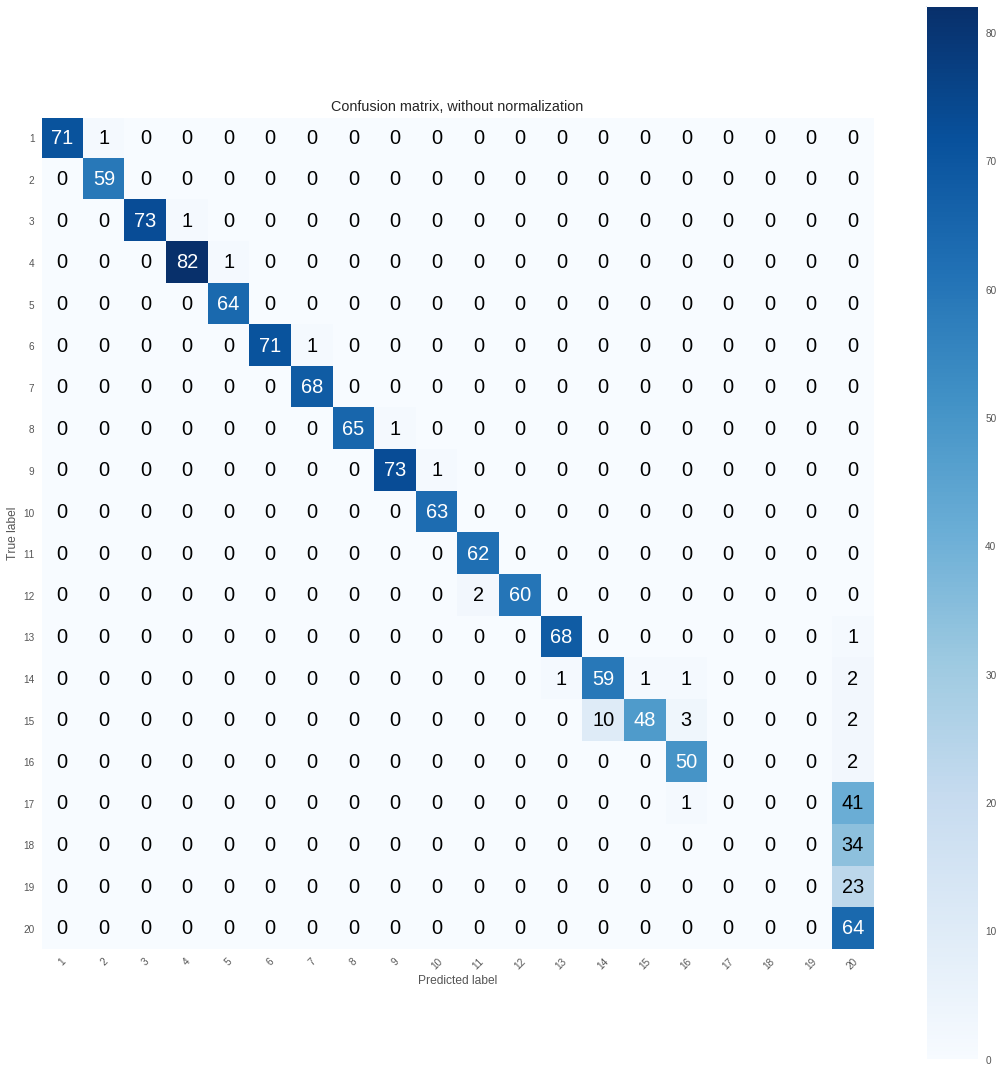

In [141]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    #plt.axis('off')
    

plt.figure(figsize=(15,15))    
plot_confusion_matrix(conf_matrix, classes=range(1,21),
                      title='Confusion matrix, without normalization')



In [117]:
pd.DataFrame(predict_number_rounded).sort_values(0,ascending=False)

0      1      2      3      4      5      6      7      8      9   \
364   0.849  0.151  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
940   0.842  0.157  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
349   0.841  0.158  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1088  0.840  0.160  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
793   0.838  0.161  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
913   0.836  0.164  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
896   0.836  0.163  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
211   0.836  0.164  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
882   0.835  0.165  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
737   0.835  0.165  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
131   0.834  0.165  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1001  0.834  0.166  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
87    0.834  0.166  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
838   0.833  0.166  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
747   0.833  0.167  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
743   0.832  0.168  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
563   0.831  0.168  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
968   0.830  0.170  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
302   0.830  0.170  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
917   0.830  0.170  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
44    0.830  0.169  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
653   0.829  0.171  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
72    0.829  0.171  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1047  0.828  0.172  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
376   0.828  0.172  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
872   0.828  0.171  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
835   0.827  0.172  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1068  0.827  0.172  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
449   0.827  0.172  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
378   0.827  0.172  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
413   0.000  0.020  0.903  0.077  0.000  0.000  0.000  0.000  0.000  0.000   
412   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
411   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
409   0.000  0.000  0.000  0.023  0.935  0.042  0.000  0.000  0.000  0.000   
418   0.000  0.001  0.041  0.896  0.062  0.000  0.000  0.000  0.000  0.000   
408   0.000  0.017  0.892  0.092  0.000  0.000  0.000  0.000  0.000  0.000   
407   0.000  0.001  0.033  0.890  0.076  0.000  0.000  0.000  0.000  0.000   
406   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
405   0.000  0.000  0.000  0.027  0.934  0.039  0.000  0.000  0.000  0.000   
404   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.078  0.745  0.173   
403   0.000  0.000  0.000  0.000  0.000  0.048  0.922  0.030  0.000  0.000   
417   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.106  0.756  0.135   
419   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001   
436   0.000  0.027  0.912  0.061  0.000  0.000  0.000  0.000  0.000  0.000   
429   0.000  0.000  0.000  0.000  0.000  0.000  0.041  0.863  0.093  0.003   
435   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.083  0.748  0.165   
434   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
433   0.000  0.012  0.820  0.168  0.000  0.000  0.000  0.000  0.000  0.000   
432   0.000  0.000  0.000  0.000  0.020  0.937  0.043  0.001  0.000  0.000   
431   0.000  0.000  0.000  0.00

In [376]:
print(X.shape)
print(y.shape)

(4198, 271)
(4198, 20)


In [475]:
!pip install -q pydot
!pip install graphviz
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [476]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: ignored

In [473]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: ignored

# 2018 predictions

In [467]:
input_layer_2018 = X.shape[1]

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import RNN


model_2018 = Sequential()
model_2018.add(Dense(input_layer_2018, input_shape=(input_layer_2018,), activation='softmax'))
model_2018.add(Dense(150, activation='softmax'))
model_2018.add(Dense(20, activation='softmax'))

model_2018.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_2018.fit(X, y, epochs=150, batch_size=32, validation_split=0.0)

model_2018.summary()

Epoch 1/150
4118/4118 [==============================] - 1s 287us/step - loss: 2.9892 - acc: 0.0568
Epoch 2/150
4118/4118 [==============================] - 1s 193us/step - loss: 2.9798 - acc: 0.0644
Epoch 3/150
4118/4118 [==============================] - 1s 201us/step - loss: 2.9721 - acc: 0.0644
Epoch 4/150
4118/4118 [==============================] - 1s 204us/step - loss: 2.9623 - acc: 0.0644
Epoch 5/150
4118/4118 [==============================] - 1s 199us/step - loss: 2.9455 - acc: 0.0665
Epoch 6/150
4118/4118 [==============================] - 1s 189us/step - loss: 2.9179 - acc: 0.1139
Epoch 7/150
4118/4118 [==============================] - 1s 191us/step - loss: 2.8790 - acc: 0.1190
Epoch 8/150
4118/4118 [==============================] - 1s 192us/step - loss: 2.8312 - acc: 0.1166
Epoch 9/150
4118/4118 [==============================] - 1s 197us/step - loss: 2.7763 - acc: 0.1178
Epoch 10/150
4118/4118 [==============================] - 1s 197us/step - loss: 2.7209 - acc: 0.1202

4118/4118 [==============================] - 1s 198us/step - loss: 2.6674 - acc: 0.1175
Epoch 12/150
4118/4118 [==============================] - 1s 194us/step - loss: 2.6172 - acc: 0.1204
Epoch 13/150
4118/4118 [==============================] - 1s 200us/step - loss: 2.5724 - acc: 0.1185
Epoch 14/150
4118/4118 [==============================] - 1s 192us/step - loss: 2.5346 - acc: 0.1236
Epoch 15/150
4118/4118 [==============================] - 1s 198us/step - loss: 2.5006 - acc: 0.1355
Epoch 16/150
4118/4118 [==============================] - 1s 201us/step - loss: 2.4733 - acc: 0.1338
Epoch 17/150
4118/4118 [==============================] - 1s 188us/step - loss: 2.4494 - acc: 0.1309
Epoch 18/150
4118/4118 [==============================] - 1s 198us/step - loss: 2.4288 - acc: 0.1319
Epoch 19/150
4118/4118 [==============================] - 1s 199us/step - loss: 2.4087 - acc: 0.1423
Epoch 20/150
4118/4118 [==============================] - 1s 199us/step - loss: 2.3943 - acc: 0.1418
Epo

4118/4118 [==============================] - 1s 202us/step - loss: 2.3806 - acc: 0.1399
Epoch 22/150
4118/4118 [==============================] - 1s 207us/step - loss: 2.3676 - acc: 0.1408
Epoch 23/150
4118/4118 [==============================] - 1s 198us/step - loss: 2.3568 - acc: 0.1532
Epoch 24/150
4118/4118 [==============================] - 1s 196us/step - loss: 2.3418 - acc: 0.1535
Epoch 25/150
4118/4118 [==============================] - 1s 201us/step - loss: 2.3301 - acc: 0.1824
Epoch 26/150
4118/4118 [==============================] - 1s 197us/step - loss: 2.3144 - acc: 0.1965
Epoch 27/150
4118/4118 [==============================] - 1s 202us/step - loss: 2.3018 - acc: 0.2363
Epoch 28/150
4118/4118 [==============================] - 1s 200us/step - loss: 2.2835 - acc: 0.2579
Epoch 29/150
4118/4118 [==============================] - 1s 201us/step - loss: 2.2608 - acc: 0.2598
Epoch 30/150
4118/4118 [==============================] - 1s 204us/step - loss: 2.2348 - acc: 0.2555
Epo

4118/4118 [==============================] - 1s 199us/step - loss: 2.2080 - acc: 0.2579
Epoch 32/150
4118/4118 [==============================] - 1s 199us/step - loss: 2.1839 - acc: 0.2574
Epoch 33/150
4118/4118 [==============================] - 1s 204us/step - loss: 2.1523 - acc: 0.2601
Epoch 34/150
4118/4118 [==============================] - 1s 205us/step - loss: 2.1228 - acc: 0.2666
Epoch 35/150
4118/4118 [==============================] - 1s 203us/step - loss: 2.1016 - acc: 0.2630
Epoch 36/150
4118/4118 [==============================] - 1s 201us/step - loss: 2.0730 - acc: 0.2625
Epoch 37/150
4118/4118 [==============================] - 1s 204us/step - loss: 2.0484 - acc: 0.2712
Epoch 38/150
4118/4118 [==============================] - 1s 199us/step - loss: 2.0248 - acc: 0.2739
Epoch 39/150
4118/4118 [==============================] - 1s 202us/step - loss: 2.0111 - acc: 0.2829
Epoch 40/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.9888 - acc: 0.2953
Epo

4118/4118 [==============================] - 1s 199us/step - loss: 1.9752 - acc: 0.2895
Epoch 42/150
4118/4118 [==============================] - 1s 196us/step - loss: 1.9549 - acc: 0.3023
Epoch 43/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.9410 - acc: 0.3203
Epoch 44/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.9327 - acc: 0.3159
Epoch 45/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.9090 - acc: 0.3380
Epoch 46/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.8966 - acc: 0.3424
Epoch 47/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.8824 - acc: 0.3536
Epoch 48/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.8641 - acc: 0.3558
Epoch 49/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.8458 - acc: 0.3800
Epoch 50/150
4118/4118 [==============================] - 1s 206us/step - loss: 1.8347 - acc: 0.3808
Epo

4118/4118 [==============================] - 1s 194us/step - loss: 1.8190 - acc: 0.4072
Epoch 52/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.8020 - acc: 0.4036
Epoch 53/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.7801 - acc: 0.4240
Epoch 54/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.7738 - acc: 0.4186
Epoch 55/150
4118/4118 [==============================] - 1s 194us/step - loss: 1.7515 - acc: 0.4349
Epoch 56/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.7436 - acc: 0.4386
Epoch 57/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.7280 - acc: 0.4296
Epoch 58/150
4118/4118 [==============================] - 1s 207us/step - loss: 1.7086 - acc: 0.4378
Epoch 59/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.7013 - acc: 0.4444
Epoch 60/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.6791 - acc: 0.4607
Epo

4118/4118 [==============================] - 1s 198us/step - loss: 1.6748 - acc: 0.4531
Epoch 62/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.6550 - acc: 0.4621
Epoch 63/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.6484 - acc: 0.4723
Epoch 64/150
4118/4118 [==============================] - 1s 190us/step - loss: 1.6299 - acc: 0.4743
Epoch 65/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.6196 - acc: 0.4764
Epoch 66/150
4118/4118 [==============================] - 1s 191us/step - loss: 1.6172 - acc: 0.4845
Epoch 67/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.5968 - acc: 0.4823
Epoch 68/150
4118/4118 [==============================] - 1s 196us/step - loss: 1.5905 - acc: 0.4966
Epoch 69/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.5774 - acc: 0.5070
Epoch 70/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.5715 - acc: 0.5102
Epo

4118/4118 [==============================] - 1s 193us/step - loss: 1.5606 - acc: 0.5095
Epoch 72/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.5500 - acc: 0.5058
Epoch 73/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.5420 - acc: 0.5041
Epoch 74/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.5379 - acc: 0.5126
Epoch 75/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.5170 - acc: 0.5233
Epoch 76/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.5160 - acc: 0.5172
Epoch 77/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.5043 - acc: 0.5294
Epoch 78/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.5074 - acc: 0.5240
Epoch 79/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.4949 - acc: 0.5323
Epoch 80/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.4760 - acc: 0.5340
Epo

4118/4118 [==============================] - 1s 202us/step - loss: 1.4805 - acc: 0.5345
Epoch 82/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.4638 - acc: 0.5277
Epoch 83/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.4697 - acc: 0.5454
Epoch 84/150
4118/4118 [==============================] - 1s 205us/step - loss: 1.4579 - acc: 0.5440
Epoch 85/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.4478 - acc: 0.5466
Epoch 86/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.4433 - acc: 0.5466
Epoch 87/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.4340 - acc: 0.5522
Epoch 88/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.4238 - acc: 0.5588
Epoch 89/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.4247 - acc: 0.5546
Epoch 90/150
4118/4118 [==============================] - 1s 194us/step - loss: 1.4128 - acc: 0.5500
Epo

4118/4118 [==============================] - 1s 201us/step - loss: 1.4125 - acc: 0.5580
Epoch 92/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.4055 - acc: 0.5486
Epoch 93/150
4118/4118 [==============================] - 1s 204us/step - loss: 1.3906 - acc: 0.5668
Epoch 94/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.3941 - acc: 0.5614
Epoch 95/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.3885 - acc: 0.5597
Epoch 96/150
4118/4118 [==============================] - 1s 206us/step - loss: 1.3803 - acc: 0.5631
Epoch 97/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.3764 - acc: 0.5663
Epoch 98/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.3677 - acc: 0.5855
Epoch 99/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.3570 - acc: 0.5840
Epoch 100/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.3604 - acc: 0.5585
Ep

4118/4118 [==============================] - 1s 200us/step - loss: 1.3509 - acc: 0.5855
Epoch 102/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.3510 - acc: 0.5741
Epoch 103/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.3451 - acc: 0.5697
Epoch 104/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.3381 - acc: 0.5860
Epoch 105/150
4118/4118 [==============================] - 1s 196us/step - loss: 1.3360 - acc: 0.5532
Epoch 106/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.3220 - acc: 0.5804
Epoch 107/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.3177 - acc: 0.5872
Epoch 108/150
4118/4118 [==============================] - 1s 193us/step - loss: 1.3118 - acc: 0.5753
Epoch 109/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.3072 - acc: 0.5881
Epoch 110/150
4118/4118 [==============================] - 1s 194us/step - loss: 1.3181 - acc: 0

4118/4118 [==============================] - 1s 198us/step - loss: 1.2968 - acc: 0.5833
Epoch 112/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.2980 - acc: 0.5763
Epoch 113/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.2888 - acc: 0.5719
Epoch 114/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.2912 - acc: 0.5758
Epoch 115/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.2851 - acc: 0.5823
Epoch 116/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.2767 - acc: 0.5971
Epoch 117/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.2844 - acc: 0.5847
Epoch 118/150
4118/4118 [==============================] - 1s 201us/step - loss: 1.2708 - acc: 0.5828
Epoch 119/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.2638 - acc: 0.5906
Epoch 120/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.2610 - acc: 0

4118/4118 [==============================] - 1s 199us/step - loss: 1.2693 - acc: 0.6134
Epoch 122/150
4118/4118 [==============================] - 1s 199us/step - loss: 1.2552 - acc: 0.5962
Epoch 123/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.2476 - acc: 0.6168
Epoch 124/150
4118/4118 [==============================] - 1s 207us/step - loss: 1.2396 - acc: 0.6141
Epoch 125/150
4118/4118 [==============================] - 1s 204us/step - loss: 1.2442 - acc: 0.5986
Epoch 126/150
4118/4118 [==============================] - 1s 191us/step - loss: 1.2341 - acc: 0.6124
Epoch 127/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.2361 - acc: 0.6217
Epoch 128/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.2267 - acc: 0.6022
Epoch 129/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.2243 - acc: 0.6158
Epoch 130/150
4118/4118 [==============================] - 1s 205us/step - loss: 1.2179 - acc: 0

4118/4118 [==============================] - 1s 204us/step - loss: 1.2158 - acc: 0.6229
Epoch 132/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.2118 - acc: 0.6173
Epoch 133/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.2094 - acc: 0.6141
Epoch 134/150
4118/4118 [==============================] - 1s 194us/step - loss: 1.2005 - acc: 0.6200
Epoch 135/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.1977 - acc: 0.6304
Epoch 136/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.2084 - acc: 0.6238
Epoch 137/150
4118/4118 [==============================] - 1s 196us/step - loss: 1.1838 - acc: 0.6413
Epoch 138/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.1921 - acc: 0.6292
Epoch 139/150
4118/4118 [==============================] - 1s 202us/step - loss: 1.1803 - acc: 0.6248
Epoch 140/150
4118/4118 [==============================] - 1s 204us/step - loss: 1.1920 - acc: 0

4118/4118 [==============================] - 1s 202us/step - loss: 1.1788 - acc: 0.6333
Epoch 142/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.1666 - acc: 0.6311
Epoch 143/150
4118/4118 [==============================] - 1s 200us/step - loss: 1.1767 - acc: 0.6265
Epoch 144/150
4118/4118 [==============================] - 1s 196us/step - loss: 1.1673 - acc: 0.6374
Epoch 145/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.1644 - acc: 0.6246
Epoch 146/150
4118/4118 [==============================] - 1s 195us/step - loss: 1.1593 - acc: 0.6561
Epoch 147/150
4118/4118 [==============================] - 1s 197us/step - loss: 1.1577 - acc: 0.6435
Epoch 148/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.1591 - acc: 0.6277
Epoch 149/150
4118/4118 [==============================] - 1s 203us/step - loss: 1.1606 - acc: 0.6530
Epoch 150/150
4118/4118 [==============================] - 1s 198us/step - loss: 1.1383 - acc: 0

In [468]:
print(x_2018.shape)
print(y_2018.shape)

(80, 271)
(80, 20)


In [469]:
eval_model_2018 = model_2018.evaluate(x_2018, y_2018)
prediction_probability_2018 = model_2018.predict_proba(x_2018)

80/80 [==============================] - 0s 2ms/step


In [498]:
eval_model_2018

[1.0910516500473022, 0.6625]

In [506]:
predictions_2018 = prediction_probability_2018.argmax(1)
ml_df_2018['pred'] = predictions_2018
ml_df_2018['pred'] = ml_df_2018['pred'] +1
predictions_2018 = ml_df_2018

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
predictions_2018 = predictions_2018.merge(drivers[['driverId', 'driverRef']], on='driverId')

In [520]:
predictions_2018['pred_diff'] = predictions_2018['pred'] - predictions_2018['position_res']
predictions_2018[['driverRef','grid','position_res', 'pred','pred_diff', 'raceId']]

driverRef  grid  position_res  pred  pred_diff  raceId
0          hamilton     9           3.0     3        0.0     990
1          hamilton     2           1.0     1        0.0     992
2          hamilton     1           1.0     1        0.0     993
3          hamilton     4           4.0     4        0.0     991
4            alonso    13           7.0     7        0.0     990
5            alonso    12           7.0     7        0.0     992
6            alonso     8           8.0     8        0.0     993
7            alonso    13           7.0     7        0.0     991
8         raikkonen     2          20.0    20        0.0     990
9         raikkonen     6           2.0     1       -1.0     992
10        raikkonen     4          20.0    20        0.0     993
11        raikkonen     2           3.0     3        0.0     991
12           vettel     1           1.0     1        0.0     990
13           vettel     1           4.0     4        0.0     992
14           vettel     3           4.0     4        0.0     993
15           vettel     1           8.0     8        0.0     991
16         grosjean    16          13.0    12       -1.0     990
17         grosjean    20          20.0    20        0.0     992
18         grosjean    10          20.0    20        0.0     993
19         grosjean    10          17.0    20        3.0     991
20       hulkenberg     7           6.0     6        0.0     990
21       hulkenberg    14          20.0    20        0.0     992
22       hulkenberg    16          20.0    20        0.0     993
23       hulkenberg     7           6.0     6        0.0     991
24            perez    12          16.0    15       -1.0     990
25            perez     8           3.0     3        0.0     992
26            perez    15           9.0     9        0.0     993
27            perez     8          12.0    11       -1.0     991
28        ricciardo     4          20.0    20        0.0     990
29        ricciardo     4          20.0    20        0.0     992
..              ...   ...           ...   ...        ...     ...
50            sainz     9           7.0     7        0.0     993
51            sainz     9           9.0     9        0.0     991
52        vandoorne    14           8.0     9        1.0     990
53        vandoorne    16           9.0     9        0.0     992
54        vandoorne    11          20.0    20        0.0     993
55        vandoorne    14          13.0    12       -1.0     991
56             ocon     8          10.0    10        0.0     990
57             ocon     7          20.0    20        0.0     992
58             ocon    13          20.0    20        0.0     993
59             ocon    12          11.0    10       -1.0     991
60           stroll    20          14.0    13       -1.0     990
61           stroll    10           8.0     8        0.0     992
62           stroll    18          11.0    11        0.0     993
63           stroll    18          14.0    13       -1.0     991
64            gasly     5           4.0     4        0.0     990
65            gasly    17          12.0    12        0.0     992
66            gasly    12          20.0    20        0.0     993
67            gasly    17          18.0    20        2.0     991
68  brendon_hartley    11          17.0    20        3.0     990
69  brendon_hartley    19          10.0    10        0.0     992
70  brendon_hartley    20          12.0    11       -1.0     993
71  brendon_hartley    15          20.0    20        0.0     991
72          leclerc    19          12.0    11       -1.0     990
73          leclerc    13           6.0     7        1.0     992
74          leclerc    14          10.0    10        0.0     993
75          leclerc    19          19.0    20        1.0     991
76         sirotkin    18          15.0    13       -2.0     990
77         sirotkin    11          20.0    20        0.0     992
78         sirotkin    19          14.0    13       -1.0     993
79         sirotkin    16          15.0    14

In [0]:
from google.colab import files

predictions_2018[['driverRef','grid','position_res', 'pred', 'raceId']].to_csv('pred_2018.csv')
files.download('pred_2018.csv')

In [510]:
race_991 = predictions_2018[['driverRef','grid','position_res', 'pred', 'raceId']]
race_991[race_991['raceId']==991].sort_values('position_res')

driverRef  position_res  pred  raceId
31        ricciardo           1.0     1     991
35           bottas           2.0     2     991
11        raikkonen           3.0     3     991
3          hamilton           4.0     4     991
47   max_verstappen           5.0     5     991
23       hulkenberg           6.0     6     991
7            alonso           7.0     7     991
15           vettel           8.0     8     991
51            sainz           9.0     9     991
39  kevin_magnussen          10.0    10     991
59             ocon          11.0    10     991
27            perez          12.0    11     991
55        vandoorne          13.0    12     991
63           stroll          14.0    13     991
79         sirotkin          15.0    14     991
43         ericsson          16.0    15     991
19         grosjean          17.0    20     991
67            gasly          18.0    20     991
75          leclerc          19.0    20     991
71  brendon_hartley          20.0    20     991

In [470]:
eval_model_2018

[1.0910516500473022, 0.6625]

In [479]:
y_pred_2018 = model_2018.predict(x_2018).argmax(1)
y_test_cat_2018 = y_2018.argmax(1)

conf_matrix_2018 = confusion_matrix(y_test_cat_2018, y_pred_2018)
pd.DataFrame(conf_matrix_2018)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0    4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1    3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4    0   0   0   0   3   1   0   0   0   0   0   0   0   0   0   0   0   0   
5    0   0   0   0   0   2   2   0   0   0   0   0   0   0   0   0   0   0   
6    0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   
7    0   0   0   0   0   0   0   3   1   0   0   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   
9    0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   
10   0   0   0   0   0   0   0   0   0   2   2   0   0   0   0   0   0   0   
11   0   0   0   0   0   0   0   0   0   0   3   1   0   0   0   0   0   0   
12   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   
13   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0   
14   0   0   0   0   0   0   0   0   0   0   0   0   1   1   0   0   0   0   
15   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   
16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
19   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

    18  19  
0    0   0  
1    0   0  
2    0   0  
3    0   0  
4    0   0  
5    0   0  
6    0   0  
7    0   0  
8    0   0  
9    0   0  
10   0   0  
11   0   0  
12   0   0  
13   0   0  
14   0   0  
15   0   0  
16   0   2  
17   0   1  
18   0   1  
19   0  17

Confusion matrix, without normalization


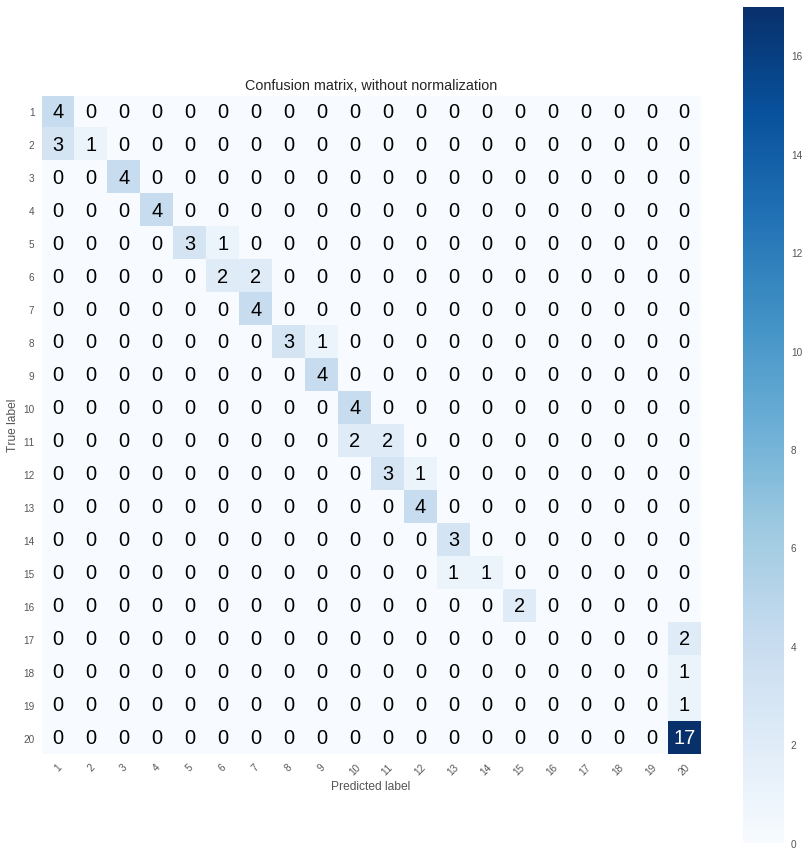

In [481]:
plt.figure(figsize=(12,12))    
plot_confusion_matrix(conf_matrix_2018, classes=range(1,21),
                      title='Confusion matrix, without normalization')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


4198

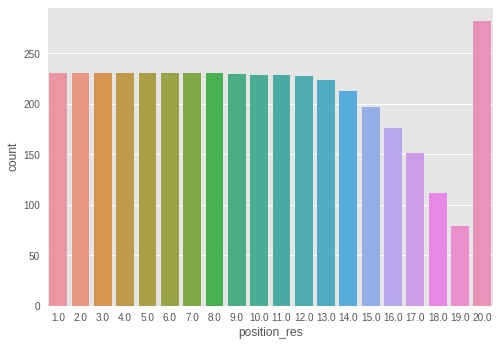

In [63]:
sns.countplot(x = 'position_res', data = ml_df)
sum(ml_df.position_res.value_counts())

# Qualifing Statistics


## Defining the data

In [0]:
# merging many tables here to check correlations and do some awesome statistics later!
results_qualifying = pd.merge(qualifying, results, on = ['raceId', 'driverId', 'constructorId'], suffixes=('_quali', '_results'))
results_qualifying = pd.merge(results_qualifying, drivers, on = ['driverId'], suffixes=('_qualiresults', '_drivers'))
results_qualifying = pd.merge(results_qualifying, constructors, on = ['constructorId'], suffixes=('_qualiresults', '_constructors'))
results_qualifying = results_qualifying.drop(["url_qualiresults", "url_constructors"], axis=1)
results_qualifying = results_qualifying.rename(index=str, columns={"nationality_qualiresults": "nationality_driver"})
results_qualifying = pd.merge(results_qualifying, status, on = ['statusId'], suffixes=('_qualiresults', '_status'))
results_qualifying = pd.merge(results_qualifying, races, on = ['raceId'], suffixes=('_qualiresults', '_race'))
results_qualifying = pd.merge(results_qualifying, circuitData, on = ['circuitId'], suffixes=('_qualiresults', '_circuit'))
results_qualifying = results_qualifying.drop(["statusId","resultId", 'constructorId',"circuitId"], axis=1)
results_qualifying = results_qualifying.drop(["url_qualiresults", "url_circuit"], axis=1)

Checking the correlation heatmap for any unexpected correlations

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text yticklabel objects>)

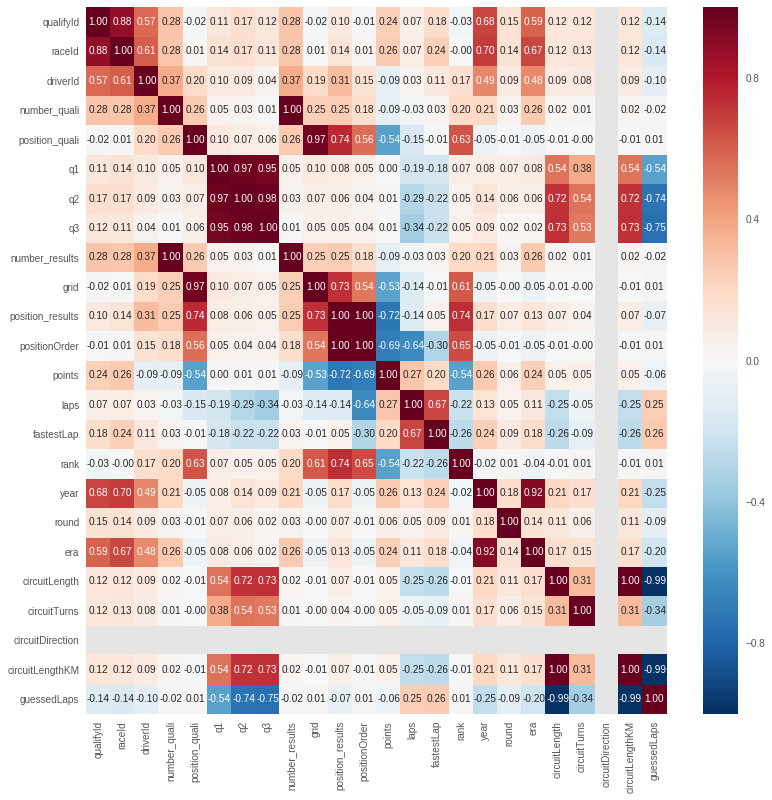

In [51]:
plt.figure(figsize=(13,13))
sns.heatmap(results_qualifying.corr(),annot = True,fmt = ".2f",cbar = True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)

In [38]:
results.isnull().sum()

resultId             0
raceId               0
driverId             0
constructorId        0
number               0
grid                 0
position           995
positionText         0
positionOrder        0
points               0
laps                 0
time                 0
milliseconds         0
fastestLap         253
rank               105
fastestLapTime       0
fastestLapSpeed      0
statusId             0
era                  0
dtype: int64

In [37]:
a = pd.merge(qualifying, races[['raceId', 'year']], on = 'raceId')
a[['year', 'q1']].sort_values('year').head()

year       q1
769  2006  94536.0
869  2006  77702.0
870  2006  78024.0
871  2006  78920.0
872  2006  80763.0

## Descriptive Representation

### Qualifing Q1
From 2017, grouped by driver. Average qualifying time in q1. <br>
The thing is here, that Button, Resta, Hartly and Gasly didn't do too much qualifying. <br>
So, because they did only qualify on a short track, with lower round times, they will be higher in rankings.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Driver name'), Text(0.5,0,'Q1 Result')]

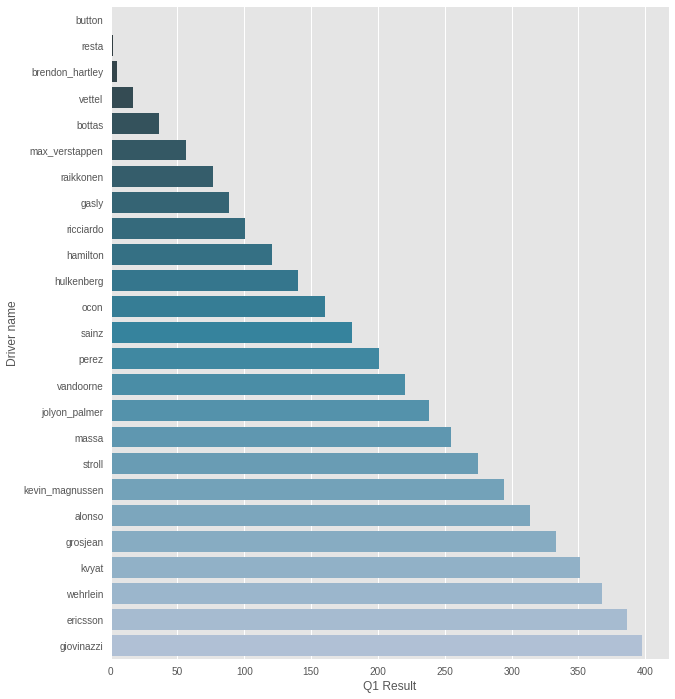

In [52]:
results_qualifying2017 = results_qualifying.loc[results_qualifying['year'] == 2017]
results_qualifying2017['avgq1'] = results_qualifying2017.groupby(['driverId'])['q1'].transform('mean')
results_qualifying2017 = results_qualifying2017.sort_values(['avgq1'], ascending=True)
results_qualifying2017['q1grid'] = results_qualifying2017['avgq1'].rank()
# results_qualifying2017.head()

#Plot the results
plt.figure(figsize=(10,12))
race_wins_plot = sns.barplot(y='driverRef', x='q1grid', data=results_qualifying2017, palette='PuBuGn_d')
race_wins_plot.set(xlabel='Q1 Result', ylabel='Driver name')

### Qualifing Q2

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Driver name'), Text(0.5,0,'Q2 Result')]

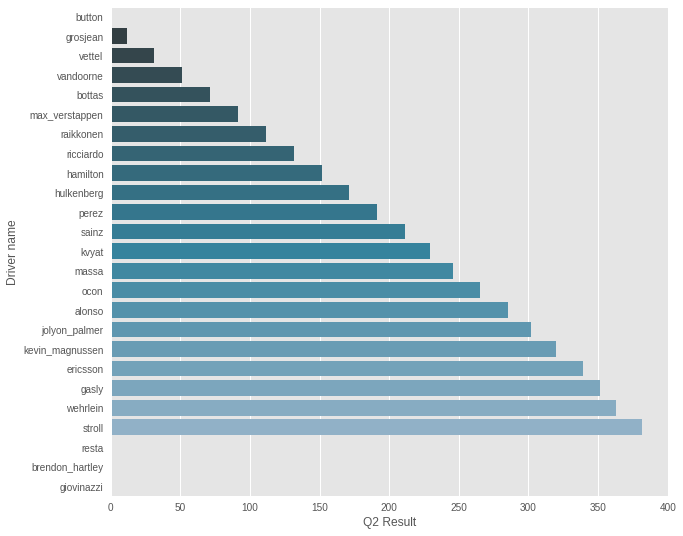

In [53]:
results_qualifying2017['avgq2'] = results_qualifying2017.groupby(['driverId'])['q2'].transform('mean')
results_qualifying2017 = results_qualifying2017.sort_values(['avgq2'], ascending=True)
results_qualifying2017['q2grid'] = results_qualifying2017['avgq2'].rank()

#Plot the results
plt.figure(figsize=(10,9))
race_wins_plot = sns.barplot(y='driverRef', x='q2grid', data=results_qualifying2017, palette='PuBuGn_d')
race_wins_plot.set(xlabel='Q2 Result', ylabel='Driver name')

### Qualifing Q3

In [35]:
results_qualifying2017['avgq3'] = results_qualifying2017.groupby(['driverId'])['q3'].transform('mean')
results_qualifying2017 = results_qualifying2017.sort_values(['avgq3'], ascending=True)
results_qualifying2017['q3grid'] = results_qualifying2017['avgq3'].rank()

#Plot the results
plt.figure(figsize=(10,6))
race_wins_plot = sns.barplot(y='driverRef', x='q3grid', data=results_qualifying2017, palette='PuBuGn_d')
race_wins_plot.set(xlabel='Starting Position', ylabel='Driver name')

NameError: ignored

### Fastest Lap time in race vs Fastest Qualifying

In [0]:
# results_qualifyingfastest = results_qualifying2017q1

# results_qualifyingfastest['q2ms'] = results_qualifying2017q2.apply(lambda row: toMs(row['q2']), axis=1)
# results_qualifyingfastest['q3ms'] = results_qualifying2017q3.apply(lambda row: toMs(row['q3']), axis=1)

# results_qualifyingfastest = pd.merge(results_qualifyingfastest,results_qualifying2017q2['q2grid'], on = ['qualifyId'])

# results_qualifyingfastest[['q1','fastestLapTime']] = results_qualifyingfastest[['q1','fastestLapTime']].apply(pd.to_datetime)
# results_qualifyingfastest[['q1','q2','q3','fastestLapTime']] = results_qualifyingfastest[['q1','q2','q3','fastestLapTime']].apply(pd.to_datetime)
# results_qualifyingfastest['q1ms'] = results_qualifyingfastest['q1'].astype(np.int64) / int(1e6)
# results_qualifyingfastest['q2ms'] = results_qualifyingfastest['q2'].astype(np.int64) / int(1e6)
# results_qualifyingfastest['q3ms'] = results_qualifyingfastest['q3'].astype(np.int64) / int(1e6)
# results_qualifyingfastest['lapms'] = results_qualifyingfastest['fastestLapTime'].astype(np.int64) / int(1e6)

In [37]:
races.head()

raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time                                                url  \
0   6:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...   
1   9:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...   
2   7:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...   
3  12:00:00  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...   
4  12:00:00  http://en.wikipedia.org/wiki/2009_Spanish_Gran...   

             datetime  era  
0 2009-03-29 06:00:00    8  
1 2009-04-05 09:00:00    8  
2 2009-04-19 07:00:00    8  
3 2009-04-26 12:00:00    8  
4 2009-05-10 12:00:00    8

### Feature Engineering

In [38]:
#Selecting the age of the driver as a feature.
ages = pd.merge(results[['raceId', 'driverId']], races[['raceId', 'date']], on = ['raceId'])
ages = pd.merge(ages, drivers[['driverId', 'dob']], on = ['driverId'])
ages['dob'] = ages['dob'].apply(pd.to_datetime).map(lambda x: pd.to_datetime(x, format = '%d/%m/%Y'))
ages['date'] = ages['date'].apply(pd.to_datetime).map(lambda x: pd.to_datetime(x, format = '%Y/%m/%d'))
ages['age'] = ((ages['date'] - ages['dob']) / timedelta(days = 365)).round(decimals=0)
ages = ages[['raceId','driverId','age']]

TypeError: ignored

In [0]:
# Selecting the driver's names
driversname = drivers[['driverId','forename','surname']]

In [0]:
# Selecting the grid position from last year at that circuit
grid_pos = pd.merge(qualifying, races[['raceId','year','circuitId']], on=['raceId'])
grid_pos = grid_pos.sort_values(['driverId', 'circuitId', 'year'])
grid_pos['grid_circ_last_year'] = grid_pos.groupby(['driverId', 'circuitId'])['position'].shift(1)

In [0]:
# Selecting the qualification position and time for last year on the same circuit. Shifting the values when the same driver drove on the same circuit a year later or earlier
feature_qualiPosNTime = pd.merge(qualifying, races[['raceId','year','circuitId']], on=['raceId'])
feature_qualiPosNTime = feature_qualiPosNTime.sort_values(['driverId','circuitId','year'], ascending=True)
feature_qualiPosNTime['posLastYear'] = feature_qualiPosNTime['position'].shift().where(feature_qualiPosNTime['year'].shift() +1 == feature_qualiPosNTime['year'], '')
feature_qualiPosNTime['qualitimeLastYear'] = feature_qualiPosNTime[['q1','q2','q3']].min(axis=1).shift().where(feature_qualiPosNTime['year'].shift() +1 == feature_qualiPosNTime['year'], '')

In [129]:
feature_qualiPosNTime.head(20)

qualifyId  raceId  driverId  constructorId  number  position        q1  \
371         372      36         1              1       2         4   86674.0   
0             1      18         1              1      22         1   86572.0   
2998       3000       1         1              1       1        15   86454.0   
3358       3360     338         1              1       2        11   85046.0   
4537       4538     841         1              1       3         2   85384.0   
4964       4966     860         1              1       4         1   86800.0   
5442       5444     880         1            131      10         3  105456.0   
5858       5860     900         1            131      44         1   91699.0   
6287       6309     926         1            131      44         1   88586.0   
6661       6683     948         1            131      44         1   85351.0   
7118       7140     969         1            131      44         1   84191.0   
393         394      37         1              1       2         4   95028.0   
25           26      19         1              1      22         4   95392.0   
3016       3018       2         1              1       1        13   95280.0   
3391       3393     339         1              1       2        20  113050.0   
4561       4563     842         1              1       3         2   96861.0   
4988       4990     861         1              1       4         1   97813.0   
5465       5467     881         1            131      10         4   97513.0   
5880       5882     901         1            131      44         1  117202.0   
6305       6327     927         1            131      44         1   99269.0   

            q2        q3  year  circuitId posLastYear qualitimeLastYear  
371    85577.0   86755.0  2007          1                                
0      85187.0   86714.0  2008          1           4             85577  
2998       NaN       NaN  2009          1           1             85187  
3358   85184.0       NaN  2010          1          15             86454  
4537   84595.0   84307.0  2011          1          11             85046  
4964   85626.0   84922.0  2012          1           2             84307  
5442   96625.0   88087.0  2013          1           1             84922  
5858  102890.0  104231.0  2014          1           3             88087  
6287   86894.0   86327.0  2015          1           1             91699  
6661   84605.0   83837.0  2016          1           1             86327  
7118   83251.0   82188.0  2017          1           1             83837  
393    94650.0   96045.0  2007          2                                
25     94627.0   96709.0  2008          2           4             94650  
3016   94905.0       NaN  2009          2           4             94627  
3391       NaN       NaN  2010          2          13             94905  
4561   95852.0   94974.0  2011          2          20            113050  
4988   97106.0   96219.0  2012          2           2             94974  
5465   96517.0  111699.0  2013          2           1             96219  
5880  119041.0  119431.0  2014          2           4             96517  
6305  101517.0  109834.0  2015          2           1            117202

In [126]:
# Takes the relative difference for every round from the pole position. 
feature_precentageDiffQualiVSPole = results_race[['resultId','raceId','driverId','constructorId','q1','q2','q3','rel_q1_diff','rel_q2_diff','rel_q3_diff']]

KeyError: ignored

In [0]:
# The rank selection from last year if the same driver drove on the same circuit a year before
rankLastYear = pd.merge(driverStandings, races[['raceId','year','circuitId']], on=['raceId'])
rankLastYear = rankLastYear.sort_values(['driverId','circuitId','year'], ascending=True)
rankLastYear['posLastYear'] = rankLastYear['position'].shift().where(rankLastYear['year'].shift() +1 == rankLastYear['year'], '')
feature_rankLastYear = rankLastYear[['raceId','driverId','year','posLastYear']]

In [0]:
# Calculates the DNF percentage up to that point, also calculates the amount of races and DNFs up to that point
DNFs = pd.merge(results[['position', 'raceId', 'driverId']], races[['raceId', 'date', 'year']], on = ['raceId'])
DNFs = DNFs.loc[DNFs['year'] > 1993]
DNFs = DNFs.sort_values('date')

def race_counter(driverId, drivers):
  '''
  Similar as DNF count but for the amount of races.
  '''
  if driverId in drivers:
    drivers[driverId] += 1
    return drivers[driverId]
  else:
    drivers[driverId] = 1
    return drivers[driverId]

def DNF_counter(driverId, result, drivers):
  '''
  counts the amount of DNFs up to that point in time assuming the DF is ordered on date
  '''
  if not(math.isnan(result)) and driverId not in drivers:
    return 0
  elif math.isnan(result) and driverId not in drivers:
    drivers[driverId] = 1 
    return drivers[driverId]
  elif not(math.isnan(result)) and driverId in drivers:
    return drivers[driverId]
  elif math.isnan(result) and driverId in drivers:
    drivers[driverId] +=1 
    return drivers[driverId]
      
drivers2 = {}
drivers1 = {}

DNFs['DNFCount'] = DNFs.apply(lambda x: DNF_counter(x['driverId'], x['position'], drivers1), axis = 1)
DNFs['raceCount'] = DNFs.driverId.map(lambda x: race_counter(x, drivers2) )
DNFs['DNFPercentage'] = DNFs.apply(lambda x: x['DNFCount']/x['raceCount'], axis = 1)


In [0]:
# Feature selection from circuits. Getting the amount of turns, length and altitude
features_circuit = pd.merge(circuitData, circuits[['circuitId','alt']], on = ['circuitId'], suffixes=('_circuitData', '_circuit'))
# features_circuit = features_circuit[['circuitId','circuitTurns','circuitLength','alt']]

In [0]:
# Selecting the name of the constructor
features_constructorname = constructors[['constructorId','name']]

In [66]:
championship_winners.head()

constructorId  era  constructor_season_points constructorRef  \
year                                                                 
1950             51    1                      92.00           alfa   
1951              6    1                      86.00        ferrari   
1952              6    1                     120.50        ferrari   
1953              6    1                     122.50        ferrari   
1954              6    2                      80.28        ferrari   

      cons_win_era-count  
year                      
1950                   1  
1951                   3  
1952                   3  
1953                   3  
1954                   3

In [0]:
# the Amount of races won by constructors.
'''constructorwins = championship_winners
constructorwins['total_win-count'] = constructorwins.groupby(['constructorId'])['constructorId'].transform('count')
constructorwins = constructorwins.drop(["era","constructor_season_points","cons_win_era-count"], axis=1)
constructorwins = constructorwins.drop_duplicates()'''

cul_champ = pd.merge(constructorStandings[['raceId', 'constructorId', 'points', 'position']], constructors[['constructorId', 'name']], on = 'constructorId')
cul_champ = pd.merge(cul_champ, races[['date', 'raceId', 'round', 'year']] , on = 'raceId')
cul_champ = cul_champ.sort_values('date')
champions = {}

years = cul_champ.year.unique()
idx = []
for year in years:
  idx.append(cul_champ[cul_champ['year']==year].points.idxmax())

for i in idx:
  cul_champ.loc[i,'champion'] = 1
  
def champ(name, champion, champions):
  if champion == 1 and name not in champions:
    champions[name] = 1
    return champions[name]
  elif champion == 1 and name in champions:
    champions[name] += 1 
    return champions[name]
  elif math.isnan(champion) and name not in champions:
    return 0 
  elif math.isnan(champion) and name in champions:
    return champions[name]

cul_champ['champion_cum'] = cul_champ.apply(lambda x: champ(x['name'], x['champion'], champions), axis = 1)

In [68]:
results_qualifying.columns

Index(['qualifyId', 'raceId', 'driverId', 'number_quali', 'position_quali',
       'q1', 'q2', 'q3', 'number_results', 'grid', 'position_results',
       'positionText', 'positionOrder', 'points', 'laps', 'time_qualiresults',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'driverRef', 'number', 'code', 'forename', 'surname',
       'dob', 'nationality_driver', 'constructorRef', 'name_qualiresults',
       'nationality_constructors', 'status', 'year', 'round', 'name_race',
       'date', 'time_race', 'datetime', 'era', 'name', 'circuitType',
       'circuitLength', 'circuitTurns', 'circuitDirection', 'circuitLengthKM',
       'guessedLaps'],
      dtype='object')

In [0]:
# 
results_qualifying = results_qualifying.sort_values(['driverId', 'datetime'], ascending=True) 
#previous 5 races
results_qualifying['avg_grid_5'] = results_qualifying['grid'].shift(1).rolling(window=5, min_periods=3).mean() 
feature_avggrid5 = results_qualifying[['raceId','driverId','avg_grid_5']]

In [70]:
#- ages.info() #raceId, driverId
#- driversname.info() #driverId
#- grid_pos.info() #qualifyId, raceId, driverId, constructorId, circuitId
#- feature_qualiPosNTime.info() #qualifyId, raceId, driverId, constructorId, circuitId
#- feature_precentageDiffQualiVSPole.info() #resultId, raceId, driverId, constructorId
#- feature_rankLastYear.info() #raceId, driverId, year
#- DNFs.info()  #driverId
#- features_circuit.info() #circuitId
#- features_constructorname.info() #constructorId
#- constructorwins.info() #constructorId
#- feature_avggrid5.info() #raceId, driverId
features_quali = pd.merge(ages, driversname, on = ['driverId'], suffixes=('_ages', '_driversname'))
features_quali = pd.merge(features_quali, DNFs, on = ['raceId','driverId'], suffixes=('_qualiresults', '_DNFs'))
features_quali = pd.merge(features_quali, feature_avggrid5, on = ['raceId','driverId'], suffixes=('_qualiresults', '_avggrid5'))
features_quali = pd.merge(features_quali, feature_rankLastYear, on = ['raceId','driverId','year'], suffixes=('_qualiresults', '_rankLastYear'))
features_quali = pd.merge(features_quali, grid_pos[['constructorId', 'grid_circ_last_year', 'raceId', 'driverId', 'circuitId']], on = ['raceId', 'driverId'])
features_quali = pd.merge(features_quali, feature_qualiPosNTime[['raceId', 'driverId', 'posLastYear', 'qualitimeLastYear']], on = ['raceId', 'driverId'], suffixes = ('_rankLastYear', '_qualiPosNTime'))
features_quali = pd.merge(features_quali, feature_precentageDiffQualiVSPole[['rel_q1_diff','rel_q2_diff', 'rel_q3_diff', 'driverId', 'raceId']], on = ['raceId', 'driverId'])
features_quali = pd.merge(features_quali, features_circuit[['circuitId', 'circuitType', 'circuitLength', 'circuitTurns', 'circuitDirection', 'alt']], on = ['circuitId'])
features_quali = pd.merge(features_quali, features_constructorname, on = ['constructorId'])
features_quali = pd.merge(features_quali, cul_champ[['constructorId','raceId', 'champion_cum']], on = ['constructorId', 'raceId'])
 
# features_quali = features_quali.drop(["statusId"], axis=1)
# features_quali = pd.merge(features_quali, races, on = ['raceId'], suffixes=('_qualiresults', '_race'))
# features_quali = features_quali.drop(["url","datetime"], axis=1)
# features_quali = pd.merge(features_quali, circuitData, on = ['circuitId'], suffixes=('_qualiresults', '_circuit'))
# features_quali = features_quali.drop(["circuitType","circuitDirection","url"], axis=1)
# features_quali = pd.merge(features_quali, circuits, on = ['circuitId'], suffixes=('_qualiresults', '_circuit'))
# features_quali = features_quali.drop(["lat", "lng","country","location","circuitRef","url"], axis=1)
# features_quali = pd.merge(features_quali, constructorResults, on = ['constructorId',"raceId"], suffixes=('_qualiresults', '_constructor'))
features_quali.head()

raceId  driverId   age  forename     surname  position        date  year  \
0      18         1  23.0     Lewis    Hamilton       1.0  2008-03-16  2008   
1      18         5  26.0    Heikki  Kovalainen       5.0  2008-03-16  2008   
2      36         1  22.0     Lewis    Hamilton       3.0  2007-03-18  2007   
3      36         4  26.0  Fernando      Alonso       2.0  2007-03-18  2007   
4     338         1  25.0     Lewis    Hamilton       6.0  2010-03-28  2010   

   DNFCount  raceCount      ...       rel_q1_diff  rel_q2_diff rel_q3_diff  \
0         1         18      ...          0.010600     0.000000    0.000000   
1         1         18      ...          0.000000     0.003111    0.004209   
2         0          1      ...          0.000346     0.002942    0.007935   
3        22         89      ...          0.000612     0.000000    0.004891   
4         5         54      ...          0.003209     0.012938         NaN   

   circuitType  circuitLength  circuitTurns circuitDirection alt     name  \
0       Street           5303            16                1  10  McLaren   
1       Street           5303            16                1  10  McLaren   
2       Street           5303            16                1  10  McLaren   
3       Street           5303            16                1  10  McLaren   
4       Street           5303            16                1  10  McLaren   

   champion_cum  
0             9  
1             9  
2             8  
3             8  
4             9  

[5 rows x 28 columns]

In [71]:
features_quali.head()

raceId  driverId   age  forename     surname  position        date  year  \
0      18         1  23.0     Lewis    Hamilton       1.0  2008-03-16  2008   
1      18         5  26.0    Heikki  Kovalainen       5.0  2008-03-16  2008   
2      36         1  22.0     Lewis    Hamilton       3.0  2007-03-18  2007   
3      36         4  26.0  Fernando      Alonso       2.0  2007-03-18  2007   
4     338         1  25.0     Lewis    Hamilton       6.0  2010-03-28  2010   

   DNFCount  raceCount      ...       rel_q1_diff  rel_q2_diff rel_q3_diff  \
0         1         18      ...          0.010600     0.000000    0.000000   
1         1         18      ...          0.000000     0.003111    0.004209   
2         0          1      ...          0.000346     0.002942    0.007935   
3        22         89      ...          0.000612     0.000000    0.004891   
4         5         54      ...          0.003209     0.012938         NaN   

   circuitType  circuitLength  circuitTurns circuitDirection alt     name  \
0       Street           5303            16                1  10  McLaren   
1       Street           5303            16                1  10  McLaren   
2       Street           5303            16                1  10  McLaren   
3       Street           5303            16                1  10  McLaren   
4       Street           5303            16                1  10  McLaren   

   champion_cum  
0             9  
1             9  
2             8  
3             8  
4             9  

[5 rows x 28 columns]

#### Feature correlation

raceId  constructorId  points  position        name        date  round  \
11332     765             87     8.0         1      Cooper  1958-01-19      1   
11333     765            105     3.0         3    Maserati  1958-01-19      1   
11331     765              6     6.0         2     Ferrari  1958-01-19      1   
11314     766              6    12.0         2     Ferrari  1958-05-18      2   
11315     766             32     0.0         5  Team Lotus  1958-05-18      2   

       year  champion  champion_cum  
11332  1958       NaN             0  
11333  1958       NaN             0  
11331  1958       NaN             0  
11314  1958       NaN             0  
11315  1958       NaN             0

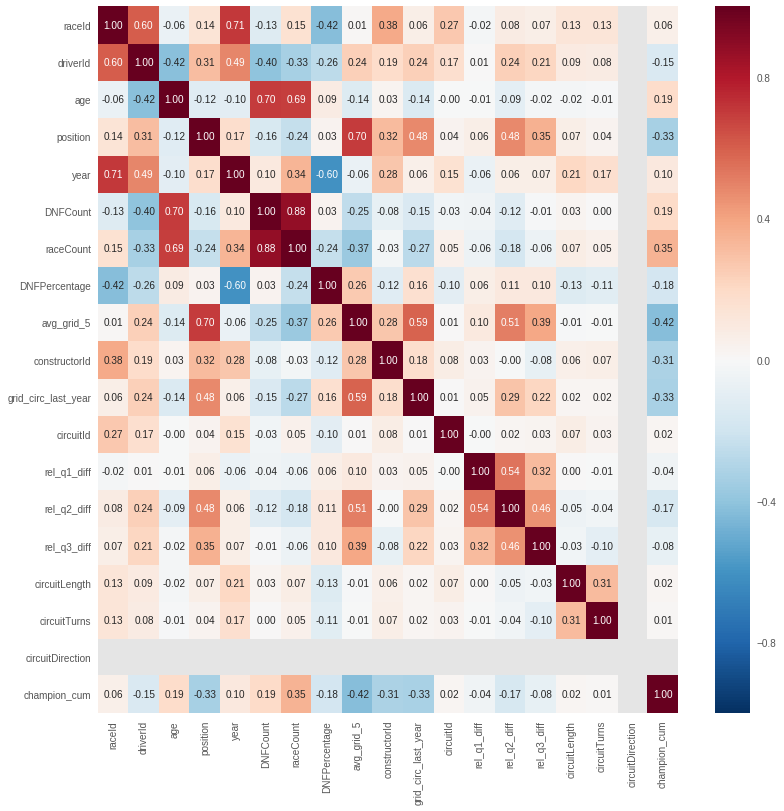

In [72]:
plt.figure(figsize=(13,13))
sns.heatmap(features_quali.corr(),annot = True,fmt = ".2f",cbar = True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)
cul_champ.head()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

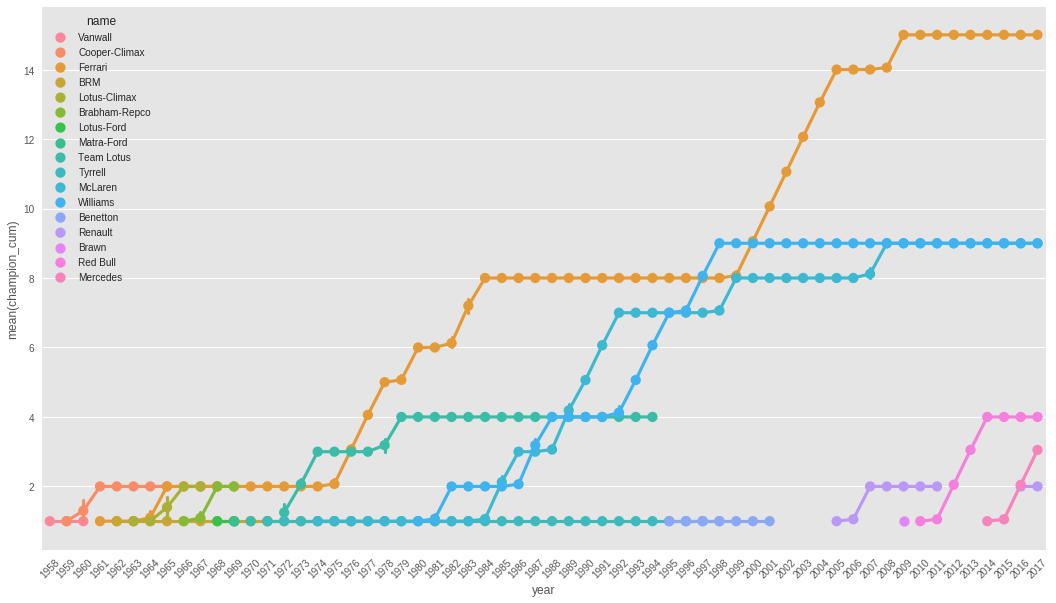

In [73]:
a = cul_champ[cul_champ['champion_cum']>0].sort_values('year')
#sns.tsplot(data=a, time="year", condition="name", value="champion_cum")
plt.figure(figsize = (18,10))

sns.pointplot(x="year", y="champion_cum", hue="name", data=a, scatter_kws={"s": 5})
plt.xticks(rotation=45)

In [74]:
constructorStandings.head()

constructorStandingsId  raceId  constructorId  points  position  \
0                       1      18              1    14.0         1   
1                       2      18              2     8.0         3   
2                       3      18              3     9.0         2   
3                       4      18              4     5.0         4   
4                       5      18              5     2.0         5   

  positionText  wins  
0            1     1  
1            3     0  
2            2     0  
3            4     0  
4            5     0

In [75]:
aa = pd.merge(constructorStandings, results, on =['raceId', 'constructorId'])

aa[aa['raceId'] == 18][['constructorId', 'points_x', 'points_y']]

constructorId  points_x  points_y
0               1      14.0      10.0
1               1      14.0       4.0
2               2       8.0       8.0
3               2       8.0       0.0
4               3       9.0       6.0
5               3       9.0       3.0
6               4       5.0       5.0
7               4       5.0       0.0
8               5       2.0       2.0
9               5       2.0       0.0
10              6       1.0       1.0
11              6       1.0       0.0

## Predictive representation